In [ ]:
pada# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
Gen RAM Free: 12.7 GB  | Proc size: 98.9 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total 15360MB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import time
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import sympy as sp
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from imblearn import*
from sklearn import metrics
import warnings
warnings.simplefilter(action='ignore')

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Replace 'your_file.xlsx' with the actual filename
file_path = '/content/drive/MyDrive/EL5114/revisi/dataset revisi/anemia_dataset.xlsx'

# Read the XLSX file into a DataFrame
df = pd.read_excel(file_path)
df.head()


Mounted at /content/drive


,GENDER,WBC,NE#,LY#,MO#,EO#,BA#,RBC,HGB,HCT,...,MPV,PCT,PDW,SD,SDTSD,TSD,FERRITTE,FOLATE,B12,Type_of_Anemia
0,1,10.63,6.31,2.79,0.91,0.56,0.06,4.31,12.7,37.6,...,9.6,0.35,10.6,100.00,248.90,40.176778,194.00,5.06,178.2,4
1,1,5.08,2.50,1.87,0.43,0.26,0.02,4.34,12.8,36.9,...,9.8,0.20,10.8,116.68,348.48,33.482553,57.37,9.88,197.7,4
2,1,13.68,9.40,2.69,1.55,0.03,0.01,3.18,9.4,27.5,...,9.7,0.36,8.8,71.97,357.27,20.144429,114.20,8.37,143.0,4
3,1,5.60,3.94,0.83,0.54,0.26,0.03,3.35,10.5,31.4,...,10.1,0.18,10.8,100.00,360.60,27.731559,214.20,6.39,139.9,4
4,1,3.57,2.03,1.25,0.10,0.18,0.01,1.31,5.1,14.3,...,11.2,0.14,12.6,176.08,223.28,78.860623,303.40,4.30,50.0,4


0 is not anemia

1 is HGB Anemia

2 is Iron Anemia

3 is Folate Anemia

4 is B12 Anemia

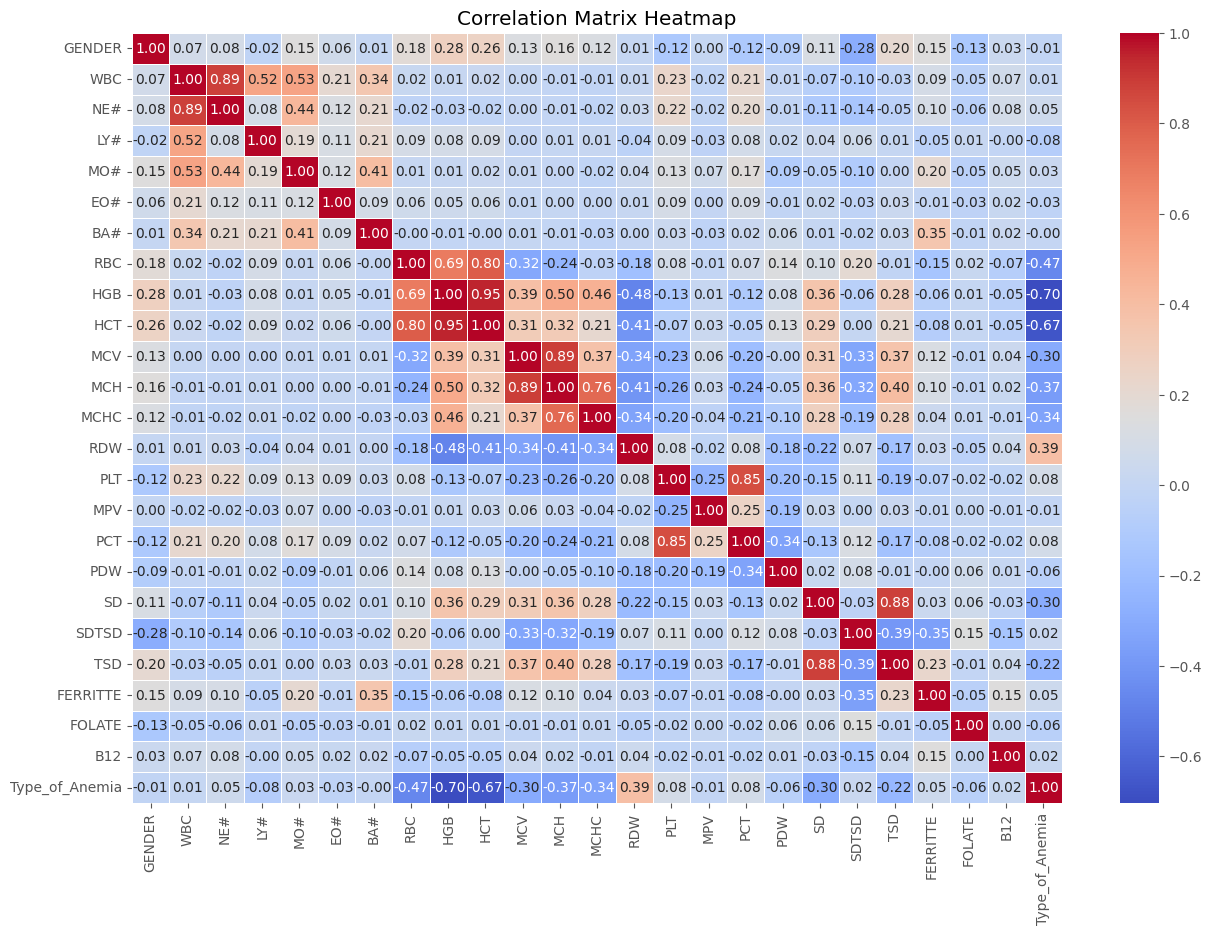

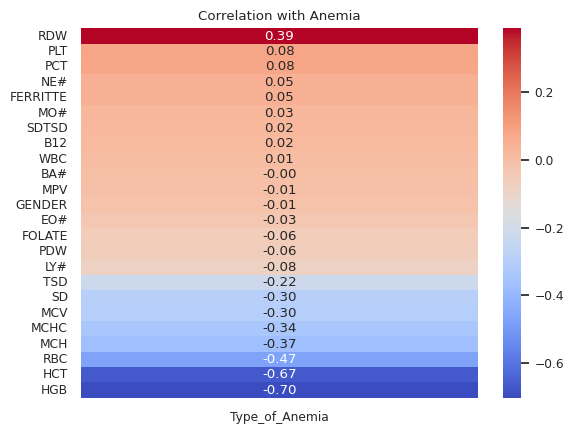

In [ ]:
data = df.copy()

# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['Type_of_Anemia'].drop('Type_of_Anemia')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Anemia')
plt.show()



In [ ]:
Compare1 = {"Method":[],"P_Count_LR":[],"N_Count_LR":[],"Score_P_LR":[],"Score_N_LR":[],"Score_accLR":[],"CV_accLR":[],"STCV_accLR":[]}
Compare2 = {"Method":[],"P_Count_RF":[],"N_Count_RF":[],"Score_P_RF":[],"Score_N_RF":[],"Score_accRF":[],"CV_accRF":[],"STCV_accRF":[]}
Compare3 = {"Method":[],"P_Count_DT":[],"N_Count_DT":[],"Score_P_DT":[],"Score_N_DT":[],"Score_accDT":[],"CV_accDT":[],"STCV_accDT":[]}
Compare4 = {"Method":[],"P_Count_KN":[],"N_Count_KN":[],"Score_P_KN":[],"Score_N_KN":[],"Score_accKN":[],"CV_accKN":[],"STCV_accKN":[]}
Compare5 = {"Method":[],"Score_accLR":[], "Score_accRF":[], "Score_accDT":[], "Score_accKN":[]}
Compare6 = {"Method":[],"CV_accLR":[], "CV_accRF":[], "CV_accDT":[], "CV_accKN":[]}
Compare7 = {"Method":[],"STCV_accLR":[], "STCV_accRF":[], "STCV_accDT":[], "STCV_accKN":[]}

In [ ]:
def plot_resampling(x_res, y_res, sampler, ax, title=None):
    x_res = pd.DataFrame(x_res)
    ax.scatter(x_res.iloc[:, 0], x_res.iloc[:, 3], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)

def plot_decision_function(x, y, clf, ax, title=None):
    x = pd.DataFrame(x)
    plot_step = 0.02
    x_min, x_max = x.iloc[:, 0].min() - 1, x.iloc[:, 0].max() + 1
    y_min, y_max = x.iloc[:, 3].min() - 1, x.iloc[:, 3].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    clf.fit(x.iloc[:, [0,3]],y)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(x.iloc[:, 0], x.iloc[:, 3], alpha=0.8, c=y, edgecolor="k")
    if title is None:
        title = f"Decision function of {clf.__class__.__name__}"
    ax.set_title(title)

def cross_val_info(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print("Cross-Validation Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

def stratified_cross_val_info(model, X, y):
    stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=308)
    scores = cross_val_score(model, X, y, cv=stratified_kf, scoring='accuracy')
    print("Stratified Cross-Validation Scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std())
    return scores.mean()

def shareplot(df,target):
    dfi = df.groupby(target).size().reset_index(name="Count")
    fig = px.pie(dfi, values='Count', names=target)
    fig.update_traces(textposition='auto', textinfo='percent+label',sort=False,showlegend=False,rotation=90)
    fig.update_layout(title_text='Class label shares',title_x=0.5)
    fig.show()

def info_func_LR(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = LogisticRegression()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuracy Linear Regression", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare1["Method"].append("NoMethod")
        Compare5["Method"].append("NoMethod")
        Compare6["Method"].append("NoMethod")
        Compare7["Method"].append("NoMethod")
    else:
        Compare1["Method"].append(method.__class__.__name__+ver)
        Compare5["Method"].append(method.__class__.__name__+ver)
        Compare6["Method"].append(method.__class__.__name__+ver)
        Compare7["Method"].append(method.__class__.__name__+ver)
    Compare1["P_Count_LR"].append(dfi[dfi[target]==1].values[0][1])
    Compare1["N_Count_LR"].append(dfi[dfi[target]==0].values[0][1])
    Compare1["Score_P_LR"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare1["Score_N_LR"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare1["Score_accLR"].append(metrics.accuracy_score(y,model.predict(x)))
    # Compare1["CV_accLR"].append(metrics.accuracy_score(y,model.predict(x)))
    Compare5["Score_accLR"].append(metrics.accuracy_score(y,model.predict(x)))

def info_func_RF(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = RandomForestClassifier()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuracy Random Forest", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare2["Method"].append("NoMethod")
    else:
        Compare2["Method"].append(method.__class__.__name__+ver)
    Compare2["P_Count_RF"].append(dfi[dfi[target]==1].values[0][1])
    Compare2["N_Count_RF"].append(dfi[dfi[target]==0].values[0][1])
    Compare2["Score_P_RF"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare2["Score_N_RF"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare2["Score_accRF"].append(metrics.accuracy_score(y,model.predict(x)))
    Compare5["Score_accRF"].append(metrics.accuracy_score(y,model.predict(x)))

def info_func_DT(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = DecisionTreeClassifier()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuracy Decision Tree", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare3["Method"].append("NoMethod")
    else:
        Compare3["Method"].append(method.__class__.__name__+ver)
    Compare3["P_Count_DT"].append(dfi[dfi[target]==1].values[0][1])
    Compare3["N_Count_DT"].append(dfi[dfi[target]==0].values[0][1])
    Compare3["Score_P_DT"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare3["Score_N_DT"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare3["Score_accDT"].append(metrics.accuracy_score(y,model.predict(x)))
    Compare5["Score_accDT"].append(metrics.accuracy_score(y,model.predict(x)))

def info_func_KN(df,target,method,ver=""):
    #Scaling the dataset using standard scaler
    DF = df.copy()
    scal_s = preprocessing.StandardScaler()
    Ns = scal_s.fit_transform(DF.drop(columns=target))
    DFs = pd.DataFrame(Ns,columns = list(DF.drop(columns=target)))
    DFs[target] = DF[target]
    #--------------------------------------------------------------------------------------------------------------------------
    # Defining x_train  x_test  y_train  y_test using train_test_split
    ts = 0.15 #test size
    x = DFs.drop(columns=target).values
    y = DFs[target].values.reshape(-1,1)
    x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=ts,random_state=308)
    #-------------------------------------------------------------------------------------------------------------------------------
    #Modeling
    model = KNeighborsClassifier()
    model.fit(x_train,y_train)
    #-------------------------------------------------------------------------------------------------------------------------------
    # Accuracy Metrics
    # Accuracy given whole data to the model
    print("Accuracy KNearest", metrics.accuracy_score(y,model.predict(x)))
    # Accuracy given test data to the model
    print("Accuracy test: ",metrics.accuracy_score(y_test,model.predict(x_test)))
    # Accuracy given train data to the model
    print("Accuracy train: ",metrics.accuracy_score(y_train,model.predict(x_train)))
    # Classification Report
    print(metrics.classification_report(y,model.predict(x)))
    #-------------------------------------------------------------------------------------------------------------------------------
    # Confusion Matrix
    cm = metrics.confusion_matrix(y,model.predict(x)) #confusion Matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
    fig , ax = plt.subplots(figsize=(10,5))
    cm_display.plot(ax=ax)
    plt.show()
    #-------------------------------------------------------------------------------------------------------------------------------
    # Classification Error
    c = 0
    for i in range(len(DF[target].drop_duplicates())):
        for j in range(len(DF[target].drop_duplicates())):
            if i!=j:
                c += cm[i][j]
    ce = c/float(len(DF.drop(columns=target)))
    print(f"classification Error is : {ce*100}%")
    #-------------------------------------------------------------------------------------------------------------------------------
    dfi = df.groupby(target).size().reset_index(name="Count")
    if method=="None":
        Compare4["Method"].append("NoMethod")
    else:
        Compare4["Method"].append(method.__class__.__name__+ver)
    Compare4["P_Count_KN"].append(dfi[dfi[target]==1].values[0][1])
    Compare4["N_Count_KN"].append(dfi[dfi[target]==0].values[0][1])
    Compare4["Score_P_KN"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["1"]["f1-score"])
    Compare4["Score_N_KN"].append(metrics.classification_report(y,model.predict(x),output_dict=True)["0"]["f1-score"])
    Compare4["Score_accKN"].append(metrics.accuracy_score(y,model.predict(x)))
    Compare5["Score_accKN"].append(metrics.accuracy_score(y,model.predict(x)))

In [ ]:
shareplot(df,"Type_of_Anemia")

Accuracy Linear Regression 0.9619607843137254
Accuracy test:  0.9581699346405229
Accuracy train:  0.9626297577854671
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9747
           1       0.83      0.75      0.79      1019
           2       0.94      0.97      0.95      4182
           3       0.82      0.75      0.78       153
           4       0.81      0.52      0.63       199

    accuracy                           0.96     15300
   macro avg       0.88      0.80      0.83     15300
weighted avg       0.96      0.96      0.96     15300



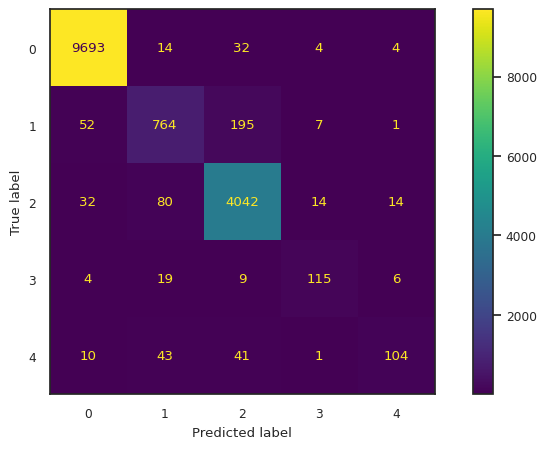

classification Error is : 3.8039215686274512%
___________________________________________________________________________
Accuracy Random Forest 0.998562091503268
Accuracy test:  0.9904139433551198
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       0.99      1.00      0.99      1019
           2       1.00      1.00      1.00      4182
           3       1.00      0.97      0.98       153
           4       1.00      0.96      0.98       199

    accuracy                           1.00     15300
   macro avg       1.00      0.98      0.99     15300
weighted avg       1.00      1.00      1.00     15300



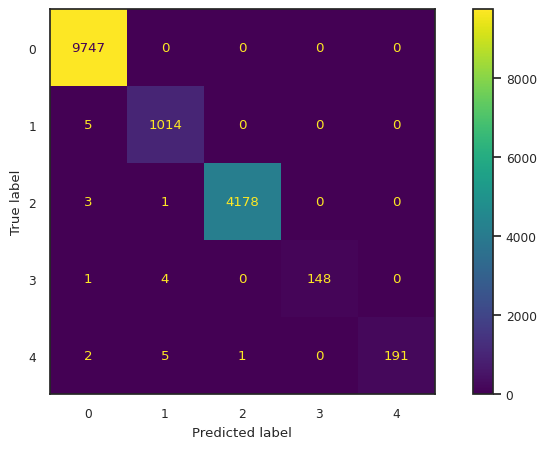

classification Error is : 0.1437908496732026%
___________________________________________________________________________
Accuracy Decision Tree 0.9999346405228758
Accuracy test:  0.9995642701525055
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      1019
           2       1.00      1.00      1.00      4182
           3       1.00      1.00      1.00       153
           4       0.99      1.00      1.00       199

    accuracy                           1.00     15300
   macro avg       1.00      1.00      1.00     15300
weighted avg       1.00      1.00      1.00     15300



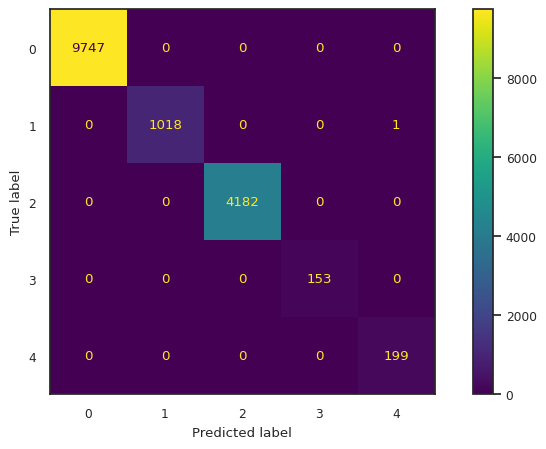

classification Error is : 0.006535947712418302%
___________________________________________________________________________
Accuracy KNearest 0.8965359477124183
Accuracy test:  0.8531590413943355
Accuracy train:  0.9041906958861976
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9747
           1       0.69      0.53      0.60      1019
           2       0.90      0.86      0.88      4182
           3       0.75      0.18      0.29       153
           4       0.77      0.14      0.23       199

    accuracy                           0.90     15300
   macro avg       0.81      0.54      0.59     15300
weighted avg       0.89      0.90      0.89     15300



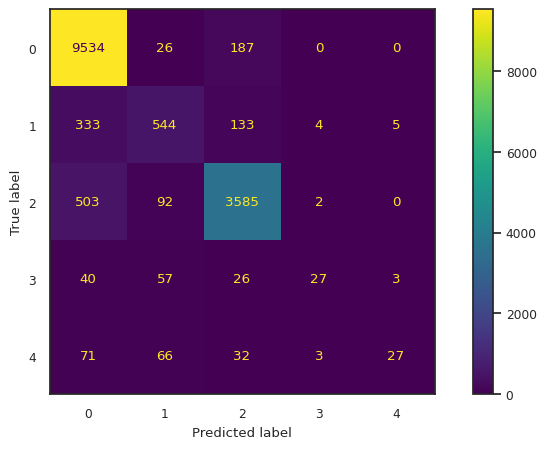

classification Error is : 10.346405228758169%


In [ ]:
info_func_LR(df,"Type_of_Anemia","None")
print('___________________________________________________________________________')
info_func_RF(df,"Type_of_Anemia","None")
print('___________________________________________________________________________')
info_func_DT(df,"Type_of_Anemia","None")
print('___________________________________________________________________________')
info_func_KN(df,"Type_of_Anemia","None")

In [ ]:
X = df.drop(columns="Type_of_Anemia").values
Y = df["Type_of_Anemia"].values.reshape(-1,1)

lr = LogisticRegression()
print("Cross-Validation for Logistic Regression on Original Data:")
mean_lr = cross_val_info(lr, X, Y)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest
rf = RandomForestClassifier()
print("Cross-Validation for Random Forest on Original Data:")
mean_rf = cross_val_info(rf, X, Y)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree
dt = DecisionTreeClassifier()
print("Cross-Validation for Decision Tree on Original Data:")
mean_dt = cross_val_info(dt, X, Y)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors
kn = KNeighborsClassifier()
print("Cross-Validation for K-Nearest Neighbors on Original Data:")
mean_kn = cross_val_info(kn, X, Y)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Original Data:
Cross-Validation Scores: [0.78660131 0.83888889 0.82418301 0.78986928 0.79509804]
Mean Accuracy: 0.8069281045751634
Standard Deviation: 0.020800749862435058
Cross-Validation for Random Forest on Original Data:
Cross-Validation Scores: [0.90882353 0.98823529 0.99052288 0.99575163 0.99575163]
Mean Accuracy: 0.9758169934640524
Standard Deviation: 0.03362552952201448
Cross-Validation for Decision Tree on Original Data:
Cross-Validation Scores: [0.99836601 0.99934641 0.9996732  1.         1.        ]
Mean Accuracy: 0.9994771241830065
Standard Deviation: 0.0006061188559147498
Cross-Validation for K-Nearest Neighbors on Original Data:
Cross-Validation Scores: [0.69183007 0.68235294 0.68660131 0.68464052 0.68562092]
Mean Accuracy: 0.6862091503267974
Standard Deviation: 0.0031440558093609543


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Original Data:")
mean_lr = stratified_cross_val_info(lr_st, X, Y)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Original Data:")
mean_rf = stratified_cross_val_info(rf_st, X, Y)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Original Data:")
mean_dt = stratified_cross_val_info(rf_st, X, Y)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Original Data:")
mean_kn = stratified_cross_val_info(kn_st, X, Y)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Original Data:
Stratified Cross-Validation Scores: [0.83006536 0.80555556 0.81928105 0.8248366  0.82908497]
Mean Accuracy: 0.8217647058823528
Standard Deviation: 0.008953532722702143
Stratified Cross-Validation for Random Forest on Original Data:
Stratified Cross-Validation Scores: [0.99411765 0.9879085  0.99183007 0.99084967 0.99313725]
Mean Accuracy: 0.9915686274509804
Standard Deviation: 0.0021419568115259974
Stratified Cross-Validation for Decision Tree on Original Data:
Stratified Cross-Validation Scores: [0.99150327 0.98823529 0.99052288 0.99019608 0.99183007]
Mean Accuracy: 0.9904575163398693
Standard Deviation: 0.0012639921310989312
Stratified Cross-Validation for K-Nearest Neighbors on Original Data:
Stratified Cross-Validation Scores: [0.6879085  0.69836601 0.68366013 0.69379085 0.69640523]
Mean Accuracy: 0.6920261437908497
Standard Deviation: 0.005466803572895794


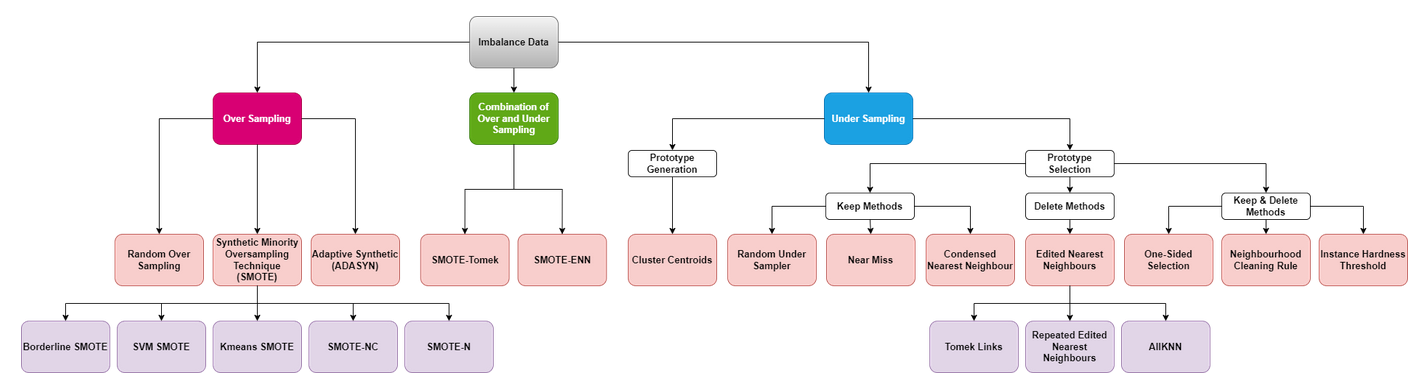

## Over-sampling
One way to fight the imbalance issue is to generate new samples in the classes which are under-represented.

1. Random Over Sampler
This method generates new samples by randomly sampling with replacement the current available samples. This method randomly duplicate examples in the minority class.

In [ ]:
X = df.drop(columns="Type_of_Anemia").values
Y = df["Type_of_Anemia"].values.reshape(-1,1)



B_method = over_sampling.RandomOverSampler(random_state=42)
x_ROS , y_ROS = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_ROS);newdf["Type_of_Anemia"]=y_ROS
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9480455524776854
Accuracy test:  0.9463821638626727
Accuracy train:  0.9483391270760911
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9747
           1       0.96      0.89      0.92      9747
           2       0.95      0.92      0.93      9747
           3       0.94      0.97      0.95      9747
           4       0.91      0.99      0.95      9747

    accuracy                           0.95     48735
   macro avg       0.95      0.95      0.95     48735
weighted avg       0.95      0.95      0.95     48735



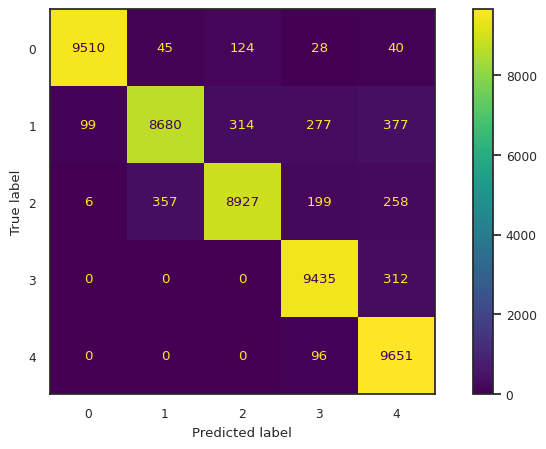

classification Error is : 5.195444752231456%
___________________________________________________________________________
Accuracy Random Forest 0.9999589617318149
Accuracy test:  0.9997264396115443
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



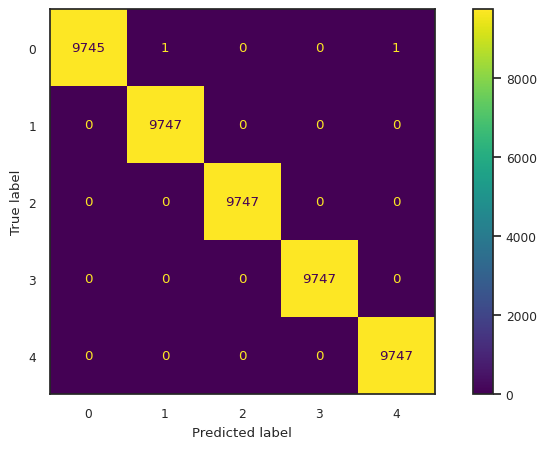

classification Error is : 0.004103826818508259%
___________________________________________________________________________
Accuracy Decision Tree 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



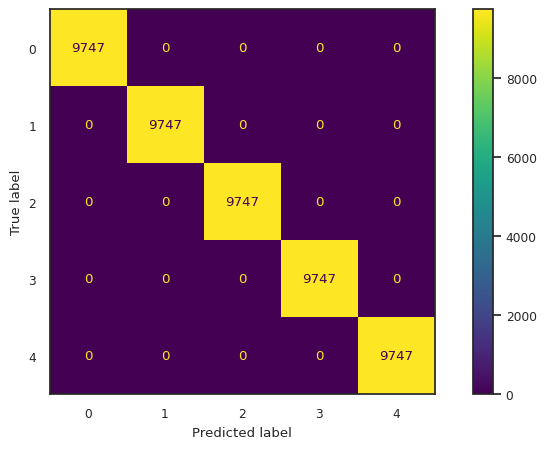

classification Error is : 0.0%
___________________________________________________________________________
Accuracy KNearest 0.9645634554221811
Accuracy test:  0.9489809875530023
Accuracy train:  0.9673136346079567
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9747
           1       0.93      1.00      0.96      9747
           2       0.94      0.93      0.93      9747
           3       0.99      1.00      1.00      9747
           4       0.99      1.00      0.99      9747

    accuracy                           0.96     48735
   macro avg       0.97      0.96      0.96     48735
weighted avg       0.97      0.96      0.96     48735



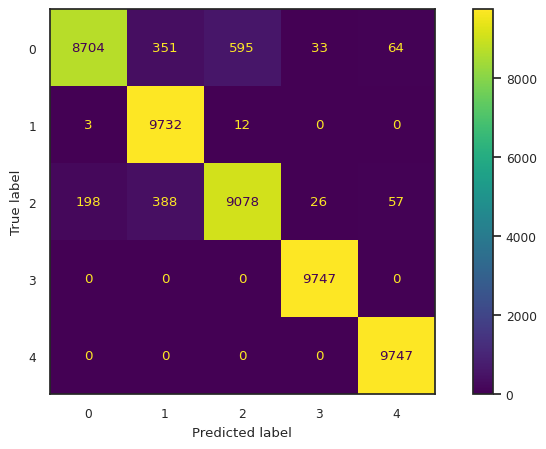

classification Error is : 3.5436544577818814%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_ROS,y_ROS,B_method,ax[1][0])
# plot_decision_function(x_ROS, y_ROS, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Random Oversampled Data:")
mean_lr = cross_val_info(lr, x_ROS, y_ROS)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Random Oversampled Data:")
mean_rf = cross_val_info(rf, x_ROS, y_ROS)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Random Oversampled Data:")
mean_dt = cross_val_info(dt, x_ROS, y_ROS)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Random Oversampled Data:")
mean_kn = cross_val_info(kn, x_ROS, y_ROS)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Random Oversampled Data:
Cross-Validation Scores: [0.7299682  0.72401765 0.70729455 0.69754796 0.70236996]
Mean Accuracy: 0.7122396634862008
Standard Deviation: 0.012575634750255093
Cross-Validation for Random Forest on Random Oversampled Data:
Cross-Validation Scores: [0.99938443 1.         0.99835847 0.9975377  0.99661434]
Mean Accuracy: 0.9983789884066893
Standard Deviation: 0.0012215349187349603
Cross-Validation for Decision Tree on Random Oversampled Data:
Cross-Validation Scores: [1.         0.99907664 1.         1.         0.99928183]
Mean Accuracy: 0.9996716938545193
Standard Deviation: 0.0004072931823387437
Cross-Validation for K-Nearest Neighbors on Random Oversampled Data:
Cross-Validation Scores: [0.85800759 0.85728942 0.87473069 0.86826716 0.86744639]
Mean Accuracy: 0.8651482507438185
Standard Deviation: 0.006626949714216616


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Random Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_ROS, y_ROS)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Random Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_ROS, y_ROS)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Random Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_ROS, y_ROS)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Random Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_ROS, y_ROS)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Random Oversampled Data:
Stratified Cross-Validation Scores: [0.72052939 0.73017339 0.72299169 0.73520057 0.70739715]
Mean Accuracy: 0.7232584384938956
Standard Deviation: 0.0094818827613187
Stratified Cross-Validation for Random Forest on Random Oversampled Data:
Stratified Cross-Validation Scores: [0.99866626 0.99907664 0.99938443 0.99876885 0.99897404]
Mean Accuracy: 0.9989740432953729
Standard Deviation: 0.0002513070424523511
Stratified Cross-Validation for Decision Tree on Random Oversampled Data:
Stratified Cross-Validation Scores: [0.99794809 0.99917923 0.99917923 0.99897404 0.99887145]
Mean Accuracy: 0.9988304093567251
Standard Deviation: 0.00045698281422632816
Stratified Cross-Validation for K-Nearest Neighbors on Random Oversampled Data:
Stratified Cross-Validation Scores: [0.86447112 0.86221401 0.86765159 0.86785678 0.86672822]
Mean Accuracy: 0.8657843439006874
Standard Deviation: 0.0021514779324457987


2. Adaptive Synthetic (ADASYN).

  This method generate new samples in by interpolation.It focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier.The essential idea of ADASYN is to use a weighted distribution for different minority class examples according to their level of difficulty in learning, where more synthetic data is generated for minority class examples that are harder to learn compared to those minority examples that are easier to learn.

In [ ]:
B_method = over_sampling.ADASYN()
x_ASYN , y_ASYN = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_ASYN);newdf["Type_of_Anemia"]=y_ASYN
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9636367291147383
Accuracy test:  0.9656974407074903
Accuracy train:  0.9632730282606126
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9747
           1       0.96      0.93      0.94      9942
           2       0.96      0.92      0.94     10492
           3       0.97      0.99      0.98      9744
           4       0.94      1.00      0.97      9823

    accuracy                           0.96     49748
   macro avg       0.96      0.96      0.96     49748
weighted avg       0.96      0.96      0.96     49748



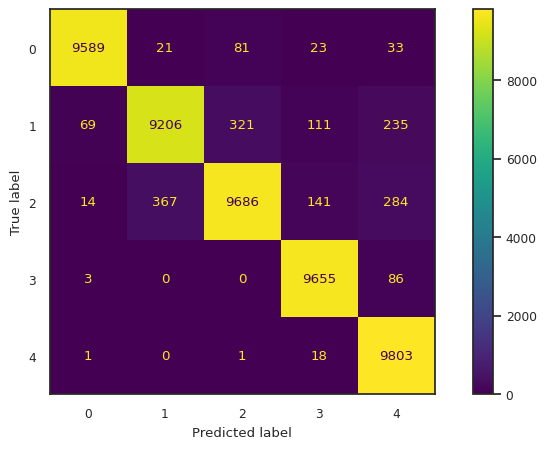

classification Error is : 3.6363270885261723%
___________________________________________________________________________
Accuracy Random Forest 0.9998190882045509
Accuracy test:  0.9987940506498727
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9942
           2       1.00      1.00      1.00     10492
           3       1.00      1.00      1.00      9744
           4       1.00      1.00      1.00      9823

    accuracy                           1.00     49748
   macro avg       1.00      1.00      1.00     49748
weighted avg       1.00      1.00      1.00     49748



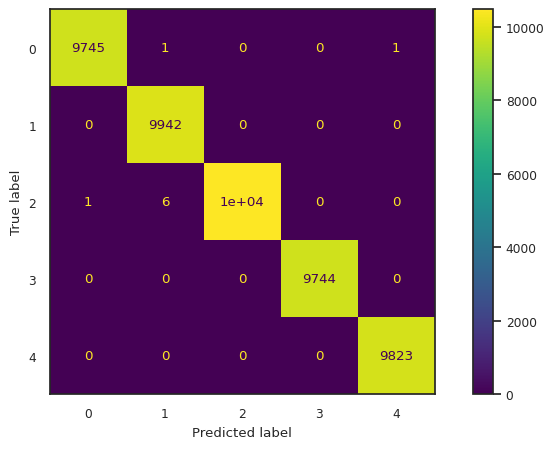

classification Error is : 0.018091179544906327%
___________________________________________________________________________
Accuracy Decision Tree 0.9998592908257619
Accuracy test:  0.9990620393943455
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9942
           2       1.00      1.00      1.00     10492
           3       1.00      1.00      1.00      9744
           4       1.00      1.00      1.00      9823

    accuracy                           1.00     49748
   macro avg       1.00      1.00      1.00     49748
weighted avg       1.00      1.00      1.00     49748



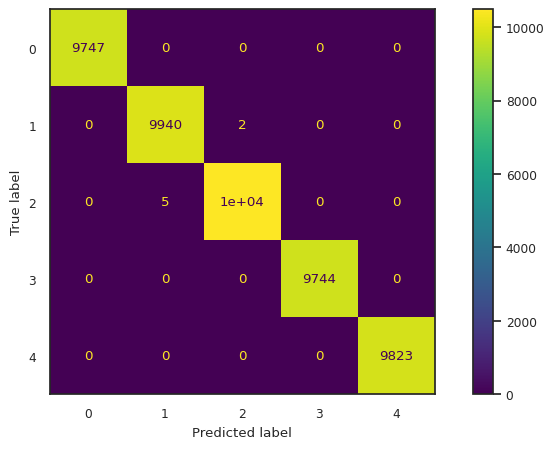

classification Error is : 0.014070917423816031%
___________________________________________________________________________
Accuracy KNearest 0.9643000723647182
Accuracy test:  0.9500200991558354
Accuracy train:  0.9668203854794845
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      9747
           1       0.94      0.99      0.96      9942
           2       0.95      0.94      0.95     10492
           3       0.99      1.00      0.99      9744
           4       0.97      1.00      0.98      9823

    accuracy                           0.96     49748
   macro avg       0.97      0.96      0.96     49748
weighted avg       0.97      0.96      0.96     49748



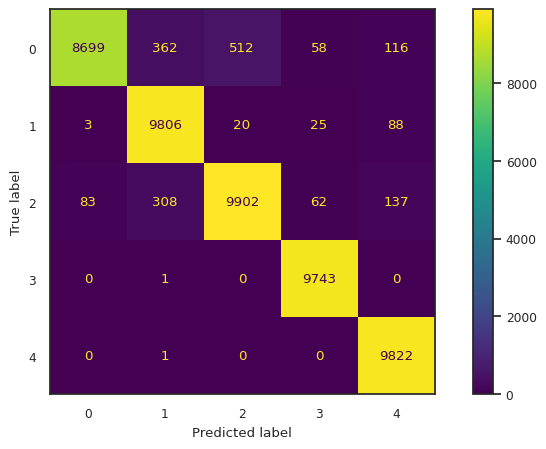

classification Error is : 3.569992763528182%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_ASYN,y_ASYN,B_method,ax[1][0])
# plot_decision_function(x_ASYN, y_ASYN, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on ADASYN Oversampled Data:")
mean_lr = cross_val_info(lr, x_ASYN, y_ASYN)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on ADASYN Oversampled Data:")
mean_rf = cross_val_info(rf, x_ASYN, y_ASYN)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on ADASYN Oversampled Data:")
mean_dt = cross_val_info(dt, x_ASYN, y_ASYN)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on ADASYN Oversampled Data:")
mean_kn = cross_val_info(kn, x_ASYN, y_ASYN)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on ADASYN Oversampled Data:
Cross-Validation Scores: [0.74663317 0.79879397 0.73788945 0.68308373 0.73082722]
Mean Accuracy: 0.7394455057476547
Standard Deviation: 0.0369519930155878
Cross-Validation for Random Forest on ADASYN Oversampled Data:
Cross-Validation Scores: [0.99507538 1.         0.99778894 0.9967836  0.99547693]
Mean Accuracy: 0.9970249700608784
Standard Deviation: 0.0017714432527707372
Cross-Validation for Decision Tree on ADASYN Oversampled Data:
Cross-Validation Scores: [0.99628141 0.9958794  0.99909548 0.99798975 0.9983918 ]
Mean Accuracy: 0.9975275654582088
Standard Deviation: 0.0012400184326137819
Cross-Validation for K-Nearest Neighbors on ADASYN Oversampled Data:
Cross-Validation Scores: [0.83296482 0.81798995 0.78703518 0.81304654 0.80440245]
Mean Accuracy: 0.811087787919394
Standard Deviation: 0.015187515304843219


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on ADASYN Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_ASYN, y_ASYN)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on ADASYN Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_ASYN, y_ASYN)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on ADASYN Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_ASYN, y_ASYN)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on ADASYN Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_ASYN, y_ASYN)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on ADASYN Oversampled Data:
Stratified Cross-Validation Scores: [0.76954774 0.76100503 0.74502513 0.73937079 0.76620766]
Mean Accuracy: 0.7562312679085448
Standard Deviation: 0.011912168885646507
Stratified Cross-Validation for Random Forest on ADASYN Oversampled Data:
Stratified Cross-Validation Scores: [0.99819095 0.99758794 0.99849246 0.99849231 0.99788924]
Mean Accuracy: 0.9981305805335857
Standard Deviation: 0.0003516131225118063
Stratified Cross-Validation for Decision Tree on ADASYN Oversampled Data:
Stratified Cross-Validation Scores: [0.99839196 0.99819095 0.99849246 0.99829129 0.99778872]
Mean Accuracy: 0.9982310769850862
Standard Deviation: 0.00024294770491926036
Stratified Cross-Validation for K-Nearest Neighbors on ADASYN Oversampled Data:
Stratified Cross-Validation Scores: [0.86321608 0.85869347 0.86633166 0.86259926 0.85908131]
Mean Accuracy: 0.8619843553883599
Standard Deviation: 0.0028302608160664378


3. Synthetic Minority Oversampling Technique (SMOTE)

  This method generate new samples in by interpolation. It will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [ ]:
B_method = over_sampling.SMOTE()
x_SMT , y_SMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_SMT);newdf["Type_of_Anemia"]=y_SMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9688724735816149
Accuracy test:  0.9701819176583231
Accuracy train:  0.9686413673232909
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9747
           1       0.97      0.94      0.95      9747
           2       0.97      0.94      0.95      9747
           3       0.97      0.99      0.98      9747
           4       0.95      1.00      0.97      9747

    accuracy                           0.97     48735
   macro avg       0.97      0.97      0.97     48735
weighted avg       0.97      0.97      0.97     48735



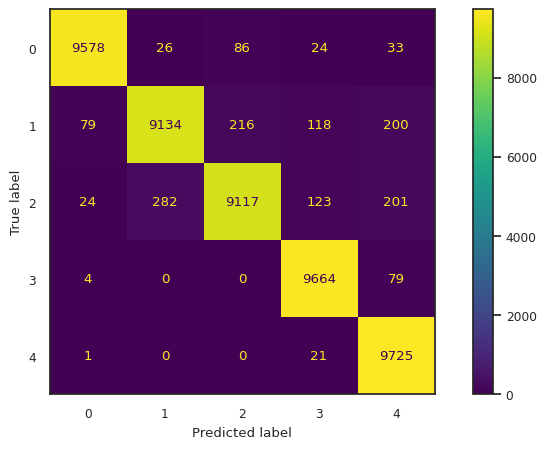

classification Error is : 3.1127526418385143%
___________________________________________________________________________
Accuracy Random Forest 0.9999179234636298
Accuracy test:  0.9994528792230885
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



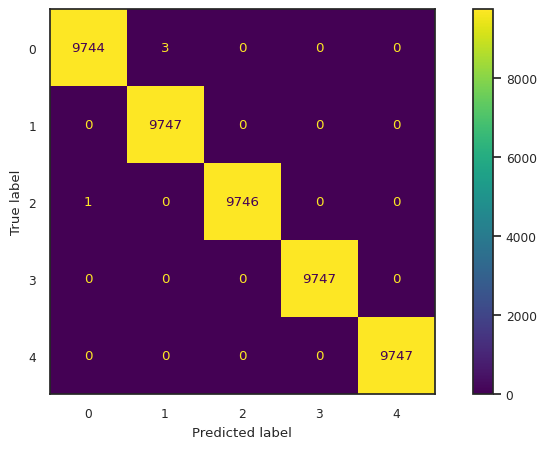

classification Error is : 0.008207653637016518%
___________________________________________________________________________
Accuracy Decision Tree 0.9999179234636298
Accuracy test:  0.9994528792230885
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



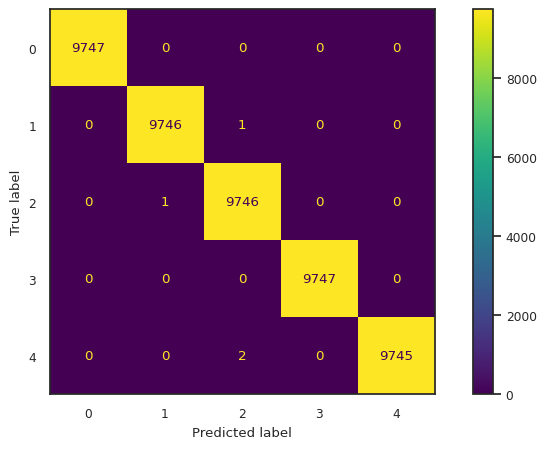

classification Error is : 0.008207653637016518%
___________________________________________________________________________
Accuracy KNearest 0.9609315686878014
Accuracy test:  0.9444672411434825
Accuracy train:  0.9638373889532638
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      9747
           1       0.93      0.99      0.96      9747
           2       0.95      0.92      0.94      9747
           3       0.99      1.00      0.99      9747
           4       0.96      1.00      0.98      9747

    accuracy                           0.96     48735
   macro avg       0.96      0.96      0.96     48735
weighted avg       0.96      0.96      0.96     48735



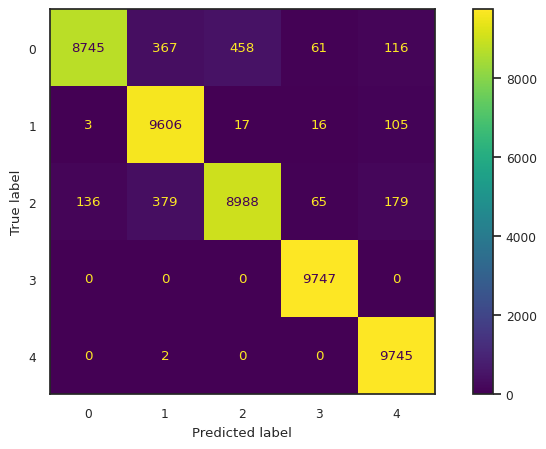

classification Error is : 3.9068431312198624%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_SMT,y_SMT,B_method,ax[1][0])
# plot_decision_function(x_SMT, y_SMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SMOTE Oversampled Data:")
mean_lr = cross_val_info(lr, x_SMT , y_SMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SMOTE Oversampled Data:")
mean_rf = cross_val_info(rf, x_SMT , y_SMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SMOTE Oversampled Data:")
mean_dt = cross_val_info(dt, x_SMT , y_SMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SMOTE Oversampled Data:")
mean_kn = cross_val_info(kn, x_SMT , y_SMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SMOTE Oversampled Data:
Cross-Validation Scores: [0.75418077 0.72340207 0.73663691 0.76043911 0.76485072]
Mean Accuracy: 0.7479019185390376
Standard Deviation: 0.015562840023670293
Cross-Validation for Random Forest on SMOTE Oversampled Data:
Cross-Validation Scores: [0.99374166 1.         0.99805068 0.99671694 0.99569098]
Mean Accuracy: 0.9968400533497487
Standard Deviation: 0.0021159595324094344
Cross-Validation for Decision Tree on SMOTE Oversampled Data:
Cross-Validation Scores: [0.99230532 0.99856366 0.99928183 0.99917923 0.99866626]
Mean Accuracy: 0.9975992613111726
Standard Deviation: 0.0026616409637873592
Cross-Validation for K-Nearest Neighbors on SMOTE Oversampled Data:
Cross-Validation Scores: [0.84682466 0.84702986 0.87011388 0.86518929 0.86836975]
Mean Accuracy: 0.8595054888683699
Standard Deviation: 0.010390991613396268


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SMOTE Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_SMT , y_SMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SMOTE Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_SMT , y_SMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SMOTE Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_SMT , y_SMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SMOTE Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_SMT , y_SMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.75377039 0.76218324 0.74607572 0.76587668 0.75418077]
Mean Accuracy: 0.7564173591874422
Standard Deviation: 0.006952444643149525
Stratified Cross-Validation for Random Forest on SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99692213 0.99866626 0.99876885 0.99825587 0.99835847]
Mean Accuracy: 0.9981943161998563
Standard Deviation: 0.0006636282601332197
Stratified Cross-Validation for Decision Tree on SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.9976403  0.99846106 0.99897404 0.99846106 0.99856366]
Mean Accuracy: 0.9984200266748744
Standard Deviation: 0.000433337685071174
Stratified Cross-Validation for K-Nearest Neighbors on SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.85852057 0.85657125 0.86149584 0.86375295 0.86354776]
Mean Accuracy: 0.8607776751821072
Standard Deviation: 0.0028224067079592754


4. Borderline SMOTE

  This algorithm is a variant of the original SMOTE algorithm. Borderline samples will be detected and used to generate new synthetic samples.This algorithm starts by classifying the minority class observations. It classifies any minority observation as a noise point if all the neighbors are the majority class and such an observation is ignored while creating synthetic data (Similar to DBSCAN).

In [ ]:
B_method = over_sampling.BorderlineSMOTE()
x_BSMT , y_BSMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_BSMT);newdf["Type_of_Anemia"]=y_BSMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9658766800041039
Accuracy test:  0.9685405553275885
Accuracy train:  0.9654065276168404
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9747
           1       0.96      0.93      0.95      9747
           2       0.96      0.93      0.94      9747
           3       0.97      0.99      0.98      9747
           4       0.95      0.99      0.97      9747

    accuracy                           0.97     48735
   macro avg       0.97      0.97      0.97     48735
weighted avg       0.97      0.97      0.97     48735



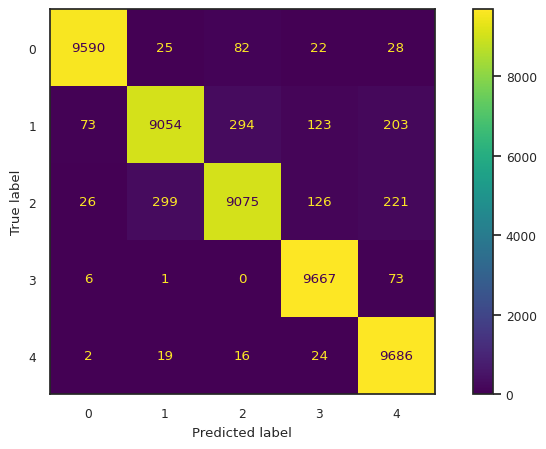

classification Error is : 3.412331999589617%
___________________________________________________________________________
Accuracy Random Forest 0.999774289524982
Accuracy test:  0.9984954178634934
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



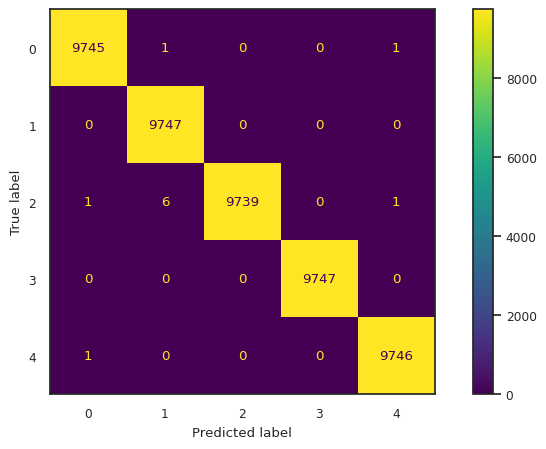

classification Error is : 0.02257104750179542%
___________________________________________________________________________
Accuracy Decision Tree 0.9998974043295373
Accuracy test:  0.9993160990288606
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



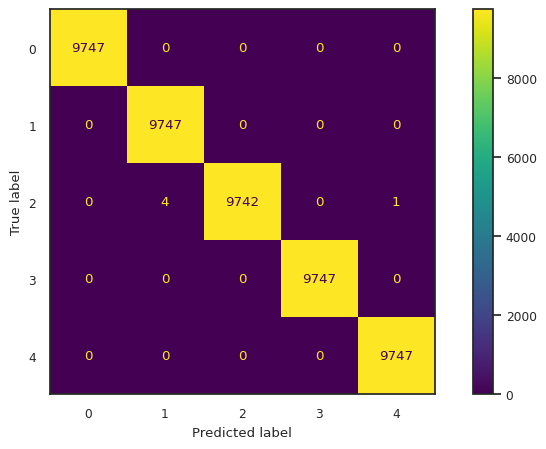

classification Error is : 0.010259567046270648%
___________________________________________________________________________
Accuracy KNearest 0.9630655586334257
Accuracy test:  0.9470660648338121
Accuracy train:  0.9658893395133256
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      9747
           1       0.93      0.98      0.96      9747
           2       0.94      0.94      0.94      9747
           3       0.99      1.00      0.99      9747
           4       0.97      1.00      0.98      9747

    accuracy                           0.96     48735
   macro avg       0.96      0.96      0.96     48735
weighted avg       0.96      0.96      0.96     48735



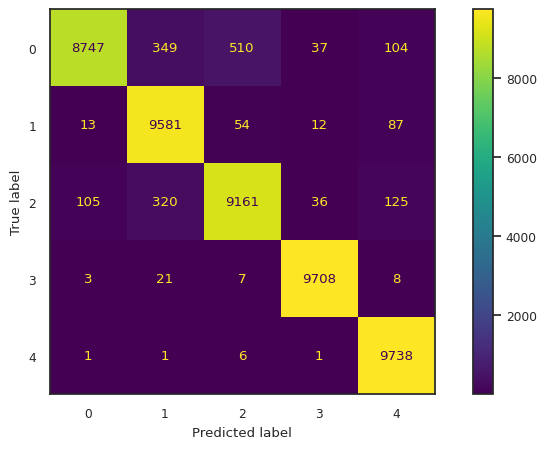

classification Error is : 3.6934441366574333%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_BSMT,y_BSMT,B_method,ax[1][0])
# plot_decision_function(x_BSMT, y_BSMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Borderline SMOTE Oversampled Data:")
mean_lr = cross_val_info(lr, x_BSMT , y_BSMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Borderline SMOTE Oversampled Data:")
mean_rf = cross_val_info(rf, x_BSMT , y_BSMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Borderline SMOTE Oversampled Data:")
mean_dt = cross_val_info(dt, x_BSMT , y_BSMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Borderline SMOTE Oversampled Data:")
mean_kn = cross_val_info(kn, x_BSMT , y_BSMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Borderline SMOTE Oversampled Data:
Cross-Validation Scores: [0.73561096 0.73540577 0.7416641  0.73745768 0.7299682 ]
Mean Accuracy: 0.7360213398994563
Standard Deviation: 0.003770722391553465
Cross-Validation for Random Forest on Borderline SMOTE Oversampled Data:
Cross-Validation Scores: [0.99322869 0.9998974  0.99733251 0.99712732 0.9975377 ]
Mean Accuracy: 0.9970247255565814
Standard Deviation: 0.002146187645838604
Cross-Validation for Decision Tree on Borderline SMOTE Oversampled Data:
Cross-Validation Scores: [0.98891967 0.99887145 0.99876885 0.99825587 0.99805068]
Mean Accuracy: 0.9965733046065456
Standard Deviation: 0.0038391075064333076
Cross-Validation for K-Nearest Neighbors on Borderline SMOTE Oversampled Data:
Cross-Validation Scores: [0.85800759 0.86323997 0.88365651 0.8767826  0.8791423 ]
Mean Accuracy: 0.8721657946034677
Standard Deviation: 0.009819858190461744


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Borderline SMOTE Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_BSMT , y_BSMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Borderline SMOTE Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_BSMT , y_BSMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Borderline SMOTE Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_BSMT , y_BSMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Borderline SMOTE Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_BSMT , y_BSMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Borderline SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.73663691 0.75766903 0.74094593 0.75951575 0.76423515]
Mean Accuracy: 0.7518005540166206
Standard Deviation: 0.010920999498149751
Stratified Cross-Validation for Random Forest on Borderline SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99692213 0.99805068 0.99866626 0.99856366 0.99794809]
Mean Accuracy: 0.998030163127116
Standard Deviation: 0.0006203433449402225
Stratified Cross-Validation for Decision Tree on Borderline SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99661434 0.99887145 0.99846106 0.99887145 0.99815328]
Mean Accuracy: 0.9981943161998563
Standard Deviation: 0.0008350052303016443
Stratified Cross-Validation for K-Nearest Neighbors on Borderline SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.87473069 0.87514107 0.87709039 0.87473069 0.87247358]
Mean Accuracy: 0.8748332820354981
Standard Deviation: 

5. SVM SMOTE

  Variant of SMOTE algorithm which use an SVM algorithm to detect sample to use for generating new synthetic samples. SVM-SMOTE focuses on generating new minority class instances near borderlines with SVM so as to help establish boundary between classes.

In [ ]:
B_method = over_sampling.SVMSMOTE(random_state=42)
x_SSMT , y_SSMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_SSMT);newdf["Type_of_Anemia"]=y_SSMT
newdf = newdf.reset_index(drop=True)
shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9408657736222242
Accuracy test:  0.9427629607431826
Accuracy train:  0.9405309640911735
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      9747
           1       0.95      0.91      0.93      9747
           2       0.93      0.92      0.93      9747
           3       0.91      0.96      0.93      5504
           4       0.95      0.98      0.97      9747

    accuracy                           0.94     44492
   macro avg       0.94      0.94      0.94     44492
weighted avg       0.94      0.94      0.94     44492



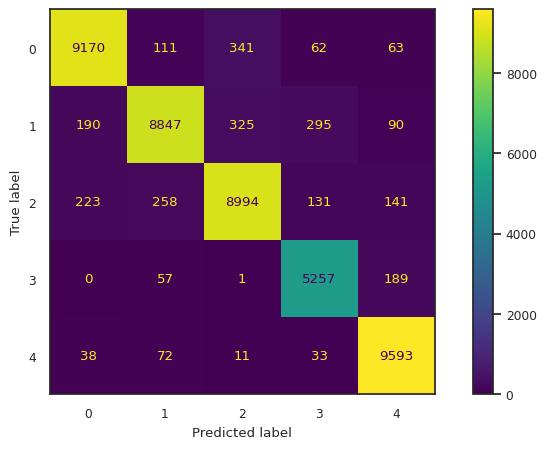

classification Error is : 5.913422637777578%
___________________________________________________________________________
Accuracy Random Forest 0.9991234379214241
Accuracy test:  0.9941564279292778
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      5504
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     44492
   macro avg       1.00      1.00      1.00     44492
weighted avg       1.00      1.00      1.00     44492



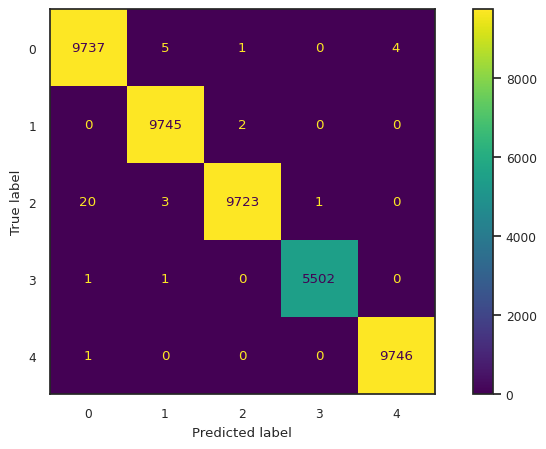

classification Error is : 0.08765620785759237%
___________________________________________________________________________
Accuracy Decision Tree 0.9990335341184932
Accuracy test:  0.9935570872040755
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      5504
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     44492
   macro avg       1.00      1.00      1.00     44492
weighted avg       1.00      1.00      1.00     44492



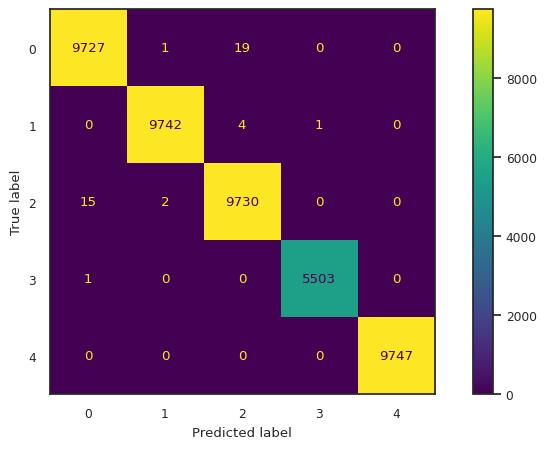

classification Error is : 0.09664658815067877%
___________________________________________________________________________
Accuracy KNearest 0.9546884833228445
Accuracy test:  0.9304764758765358
Accuracy train:  0.9589613411602941
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      9747
           1       0.93      0.98      0.96      9747
           2       0.94      0.92      0.93      9747
           3       0.98      0.99      0.99      5504
           4       0.97      1.00      0.98      9747

    accuracy                           0.95     44492
   macro avg       0.96      0.96      0.96     44492
weighted avg       0.95      0.95      0.95     44492



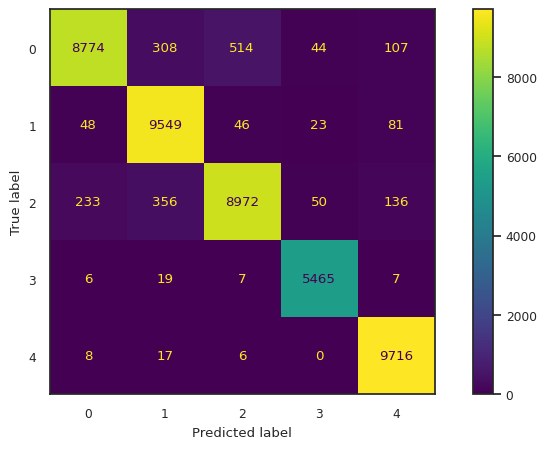

classification Error is : 4.531151667715545%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_SSMT,y_SSMT,B_method,ax[1][0])
# plot_decision_function(x_SSMT, y_SSMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SVM SMOTE Oversampled Data:")
mean_lr = cross_val_info(lr, x_SSMT , y_SSMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SVM SMOTE Oversampled Data:")
mean_rf = cross_val_info(rf, x_SSMT , y_SSMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SVM SMOTE Oversampled Data:")
mean_dt = cross_val_info(dt, x_SSMT , y_SSMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SVM SMOTE Oversampled Data:")
mean_kn = cross_val_info(kn, x_SSMT , y_SSMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SVM SMOTE Oversampled Data:
Cross-Validation Scores: [0.65962468 0.65288235 0.71499213 0.76230614 0.79028995]
Mean Accuracy: 0.7160190490666833
Standard Deviation: 0.05445417261306735
Cross-Validation for Random Forest on SVM SMOTE Oversampled Data:
Cross-Validation Scores: [0.9890999  0.99887628 0.99527984 0.99145875 0.97875927]
Mean Accuracy: 0.9906948083574489
Standard Deviation: 0.0068343738892348745
Cross-Validation for Decision Tree on SVM SMOTE Oversampled Data:
Cross-Validation Scores: [0.98921227 0.99640409 0.99527984 0.99134637 0.98460328]
Mean Accuracy: 0.9913691702323805
Standard Deviation: 0.0042678736324781264
Cross-Validation for K-Nearest Neighbors on SVM SMOTE Oversampled Data:
Cross-Validation Scores: [0.82031689 0.84987077 0.86255338 0.88334457 0.89064958]
Mean Accuracy: 0.8613470400615524
Standard Deviation: 0.02513628348906709


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SVM SMOTE Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_SSMT , y_SSMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SVM SMOTE Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_SSMT , y_SSMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SVM SMOTE Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_SSMT , y_SSMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SVM SMOTE Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_SSMT , y_SSMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SVM SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.74626363 0.74188111 0.724882   0.73926725 0.75151719]
Mean Accuracy: 0.740762235452116
Standard Deviation: 0.00896217949104974
Stratified Cross-Validation for Random Forest on SVM SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99415665 0.99528037 0.99460553 0.99381884 0.99438076]
Mean Accuracy: 0.9944484280284245
Standard Deviation: 0.0004904911186450237
Stratified Cross-Validation for Decision Tree on SVM SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99449376 0.99494325 0.99415599 0.99348168 0.99449314]
Mean Accuracy: 0.9943135662617353
Standard Deviation: 0.00048540424527745616
Stratified Cross-Validation for K-Nearest Neighbors on SVM SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.8727947  0.87178335 0.8587323  0.86480108 0.86806024]
Mean Accuracy: 0.8672343318039453
Standard Deviation: 0.0051087881314029835


6. KMeans SMOTE

  Apply a KMeans clustering before to over-sample using SMOTE.This method helps create clusters of the minority class (that are not greatly influenced by other classes). This can ultimately benefit the ML model. However, it inherits the weaknesses of the K-Means algorithm — such as finding the right K, among others

In [ ]:
B_method = over_sampling.KMeansSMOTE(cluster_balance_threshold=0.01)
x_KSMT, y_KSMT = B_method.fit_resample(X, Y)
newdf = pd.DataFrame(x_KSMT);newdf["Type_of_Anemia"]=y_KSMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9716342603987201
Accuracy test:  0.9708777686628384
Accuracy train:  0.9717677718256841
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9747
           1       0.96      0.95      0.95      9753
           2       0.97      0.94      0.95      9754
           3       0.99      0.99      0.99      9752
           4       0.95      0.99      0.97      9750

    accuracy                           0.97     48756
   macro avg       0.97      0.97      0.97     48756
weighted avg       0.97      0.97      0.97     48756



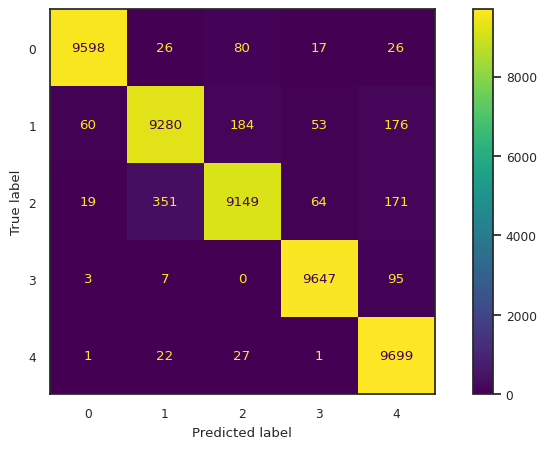

classification Error is : 2.8365739601279842%
___________________________________________________________________________
Accuracy Random Forest 0.9998154073344819
Accuracy test:  0.9987694831829368
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9753
           2       1.00      1.00      1.00      9754
           3       1.00      1.00      1.00      9752
           4       1.00      1.00      1.00      9750

    accuracy                           1.00     48756
   macro avg       1.00      1.00      1.00     48756
weighted avg       1.00      1.00      1.00     48756



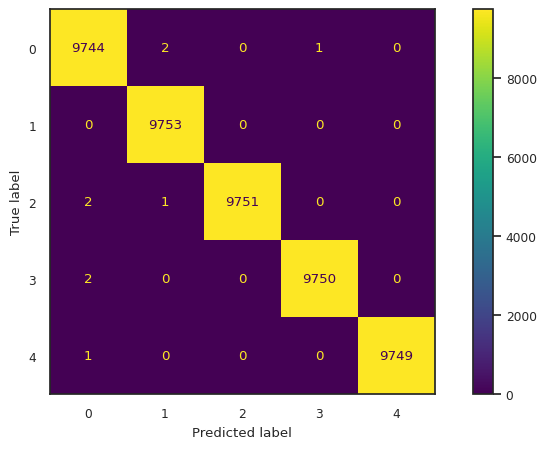

classification Error is : 0.018459266551809007%
___________________________________________________________________________
Accuracy Decision Tree 0.9998359176306506
Accuracy test:  0.9989062072737216
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9753
           2       1.00      1.00      1.00      9754
           3       1.00      1.00      1.00      9752
           4       1.00      1.00      1.00      9750

    accuracy                           1.00     48756
   macro avg       1.00      1.00      1.00     48756
weighted avg       1.00      1.00      1.00     48756



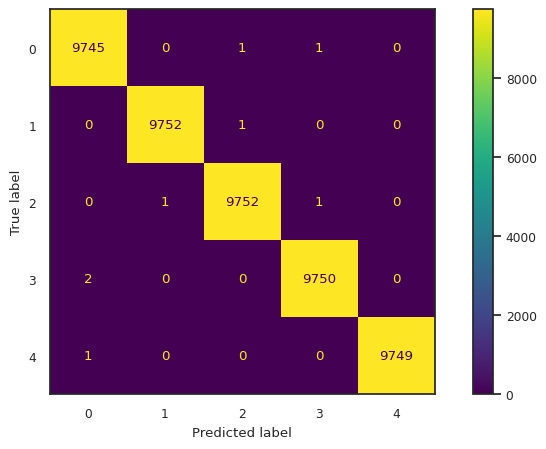

classification Error is : 0.01640823693494134%
___________________________________________________________________________
Accuracy KNearest 0.961050947575683
Accuracy test:  0.9477713973202079
Accuracy train:  0.9633946238115921
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      9747
           1       0.93      0.98      0.95      9753
           2       0.94      0.93      0.94      9754
           3       0.99      1.00      0.99      9752
           4       0.98      0.99      0.99      9750

    accuracy                           0.96     48756
   macro avg       0.96      0.96      0.96     48756
weighted avg       0.96      0.96      0.96     48756



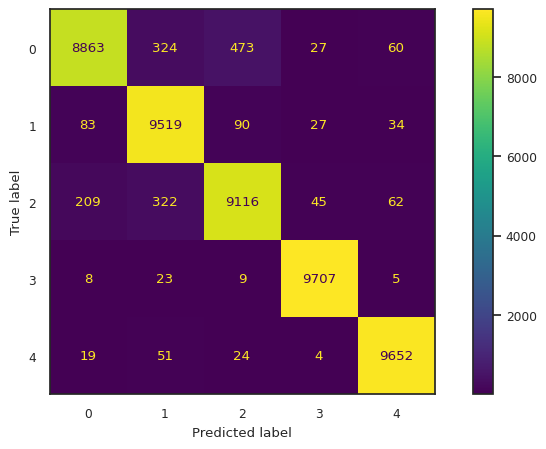

classification Error is : 3.894905242431701%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_KSMT,y_KSMT,B_method,ax[1][0])
# plot_decision_function(x_KSMT, y_KSMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on KMeans SMOTE Oversampled Data:")
mean_lr = cross_val_info(lr, x_KSMT, y_KSMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on KMeans SMOTE Oversampled Data:")
mean_rf = cross_val_info(rf, x_KSMT, y_KSMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on KMeans SMOTE Oversampled Data:")
mean_dt = cross_val_info(dt, x_KSMT, y_KSMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on KMeans SMOTE Oversampled Data:")
mean_kn = cross_val_info(kn, x_KSMT, y_KSMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on KMeans SMOTE Oversampled Data:
Cross-Validation Scores: [0.7285685  0.80278946 0.85365604 0.81755717 0.73612963]
Mean Accuracy: 0.7877401585786326
Standard Deviation: 0.04821902281058633
Cross-Validation for Random Forest on KMeans SMOTE Oversampled Data:
Cross-Validation Scores: [0.94462674 0.99979489 0.99969234 0.9984617  0.99825659]
Mean Accuracy: 0.9881664521229979
Standard Deviation: 0.021778778076505093
Cross-Validation for Decision Tree on KMeans SMOTE Oversampled Data:
Cross-Validation Scores: [0.95057424 0.99907702 0.99969234 0.99938468 0.99876936]
Mean Accuracy: 0.9894995267307726
Standard Deviation: 0.019465074336252823
Cross-Validation for K-Nearest Neighbors on KMeans SMOTE Oversampled Data:
Cross-Validation Scores: [0.73615669 0.86052713 0.91529074 0.91508563 0.82883807]
Mean Accuracy: 0.8511796501551471
Standard Deviation: 0.06634909227921391


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on KMeans SMOTE Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_KSMT, y_KSMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on KMeans SMOTE Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_KSMT, y_KSMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on KMeans SMOTE Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_KSMT, y_KSMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on KMeans SMOTE Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_KSMT, y_KSMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on KMeans SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.79204266 0.79725156 0.81930058 0.80494308 0.80043073]
Mean Accuracy: 0.8027937228456997
Standard Deviation: 0.009262622874117355
Stratified Cross-Validation for Random Forest on KMeans SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.9985644  0.99876936 0.99887191 0.99856425 0.99825659]
Mean Accuracy: 0.9986053006994761
Standard Deviation: 0.00021116504279367963
Stratified Cross-Validation for Decision Tree on KMeans SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.99815422 0.99835914 0.99825659 0.9984617  0.9984617 ]
Mean Accuracy: 0.9983386697933592
Standard Deviation: 0.00011953857936816045
Stratified Cross-Validation for K-Nearest Neighbors on KMeans SMOTE Oversampled Data:
Stratified Cross-Validation Scores: [0.88484413 0.88175572 0.88308891 0.88513999 0.87775613]
Mean Accuracy: 0.8825169758151056
Standard Deviation: 0.00267836337

7. SMOTE-NC

  Synthetic Minority Over-sampling Technique for Nominal and Continuous (for continuous and categorical features).

In [ ]:
B_method = over_sampling.SMOTENC(categorical_features=[0,4,3,5])
x_NCSMT , y_NCSMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_NCSMT);newdf["Type_of_Anemia"]=y_NCSMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9386888273314866
Accuracy test:  0.938312132403228
Accuracy train:  0.9387553109308613
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      9747
           1       0.94      0.91      0.92      9747
           2       0.94      0.91      0.92      9747
           3       0.96      0.99      0.97      9747
           4       0.93      0.98      0.96      9747

    accuracy                           0.94     48735
   macro avg       0.94      0.94      0.94     48735
weighted avg       0.94      0.94      0.94     48735



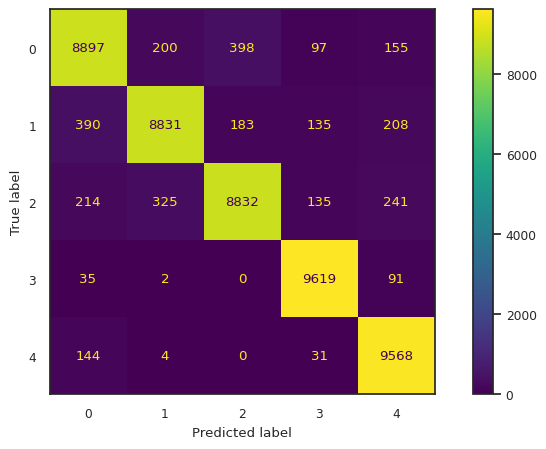

classification Error is : 6.131117266851339%
___________________________________________________________________________
Accuracy Random Forest 0.9982969118703191
Accuracy test:  0.9886472438790863
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



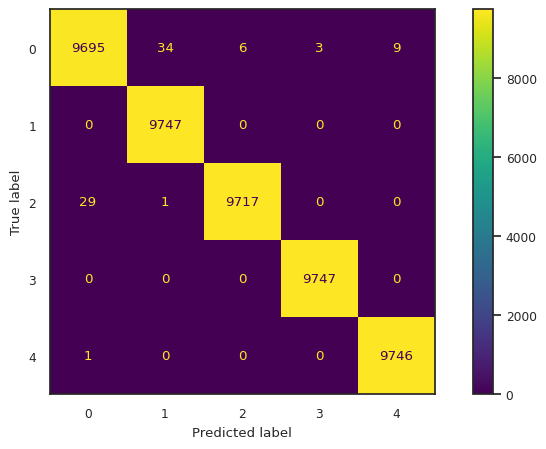

classification Error is : 0.17030881296809275%
___________________________________________________________________________
Accuracy Decision Tree 0.9979070483225608
Accuracy test:  0.9860484201887567
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



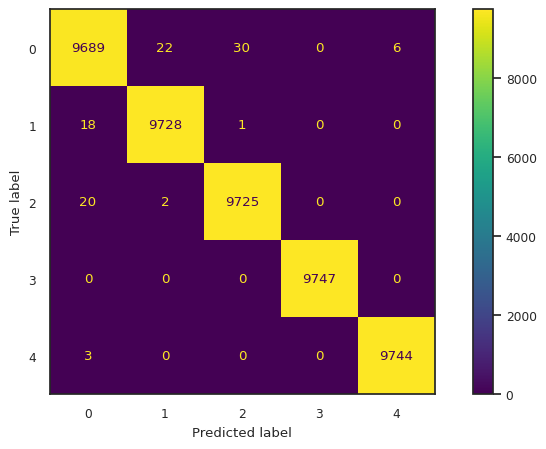

classification Error is : 0.2092951677439212%
___________________________________________________________________________
Accuracy KNearest 0.949810198009644
Accuracy test:  0.9232663110381617
Accuracy train:  0.9544949787562765
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      9747
           1       0.92      0.95      0.94      9747
           2       0.95      0.90      0.92      9747
           3       0.97      1.00      0.99      9747
           4       0.94      1.00      0.97      9747

    accuracy                           0.95     48735
   macro avg       0.95      0.95      0.95     48735
weighted avg       0.95      0.95      0.95     48735



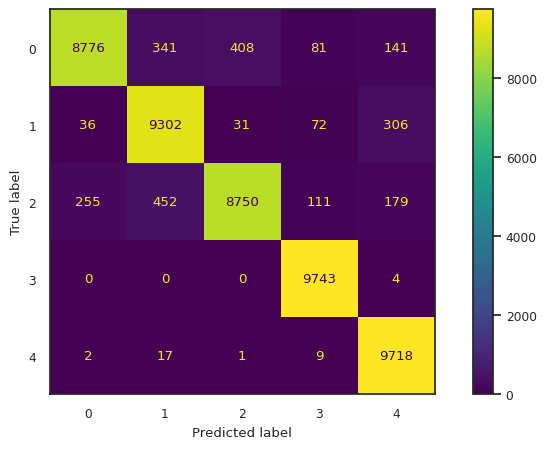

classification Error is : 5.0189801990356%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NCSMT,y_NCSMT,B_method,ax[1][0])
# plot_decision_function(x_NCSMT, y_NCSMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SMOTE-NC Oversampled Data:")
mean_lr = cross_val_info(lr, x_NCSMT , y_NCSMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SMOTE-NC Oversampled Data:")
mean_rf = cross_val_info(rf, x_NCSMT , y_NCSMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SMOTE-NC Oversampled Data:")
mean_dt = cross_val_info(dt, x_NCSMT , y_NCSMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SMOTE-NC Oversampled Data:")
mean_kn = cross_val_info(kn, x_NCSMT , y_NCSMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SMOTE-NC Oversampled Data:
Cross-Validation Scores: [0.73355904 0.74833282 0.78003488 0.76659485 0.76597928]
Mean Accuracy: 0.7589001744126398
Standard Deviation: 0.016185422216407123
Cross-Validation for Random Forest on SMOTE-NC Oversampled Data:
Cross-Validation Scores: [0.97568483 0.99948702 0.98255874 0.98040423 0.97660819]
Mean Accuracy: 0.9829485995690982
Standard Deviation: 0.008638384864650066
Cross-Validation for Decision Tree on SMOTE-NC Oversampled Data:
Cross-Validation Scores: [0.98266133 0.99466503 0.97989125 0.97589002 0.97209398]
Mean Accuracy: 0.9810403200984918
Standard Deviation: 0.007696015751370977
Cross-Validation for K-Nearest Neighbors on SMOTE-NC Oversampled Data:
Cross-Validation Scores: [0.84887658 0.848261   0.87411511 0.8673438  0.87103724]
Mean Accuracy: 0.8619267466912897
Standard Deviation: 0.011117205498276944


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SMOTE-NC Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_NCSMT , y_NCSMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SMOTE-NC Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_NCSMT , y_NCSMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SMOTE-NC Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_NCSMT , y_NCSMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-NC Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_NCSMT , y_NCSMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SMOTE-NC Oversampled Data:
Stratified Cross-Validation Scores: [0.74371602 0.69180261 0.75879758 0.74597312 0.74125372]
Mean Accuracy: 0.7363086077767519
Standard Deviation: 0.023061936697243164
Stratified Cross-Validation for Random Forest on SMOTE-NC Oversampled Data:
Stratified Cross-Validation Scores: [0.98614958 0.98840669 0.98697035 0.98850928 0.98625218]
Mean Accuracy: 0.9872576177285319
Standard Deviation: 0.001020607786227216
Stratified Cross-Validation for Decision Tree on SMOTE-NC Oversampled Data:
Stratified Cross-Validation Scores: [0.98645737 0.98840669 0.98717554 0.98738073 0.98748333]
Mean Accuracy: 0.9873807325330869
Standard Deviation: 0.0006257494893598644
Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-NC Oversampled Data:
Stratified Cross-Validation Scores: [0.86149584 0.85985431 0.86385555 0.86713861 0.85841797]
Mean Accuracy: 0.8621524571663077
Standard Deviation: 0.0030796479253941663


8. SMOTE-N
  
  Synthetic Minority Over-sampling Technique for Nominal (for categorical features).

In [ ]:
B_method = over_sampling.SMOTEN()
x_NSMT , y_NSMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_NSMT);newdf["Type_of_Anemia"]=y_NSMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9771211654868165
Accuracy test:  0.9782519491177677
Accuracy train:  0.9769215913480108
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9747
           1       0.96      0.97      0.97      9747
           2       0.98      0.96      0.97      9747
           3       0.98      0.99      0.99      9747
           4       0.98      0.98      0.98      9747

    accuracy                           0.98     48735
   macro avg       0.98      0.98      0.98     48735
weighted avg       0.98      0.98      0.98     48735



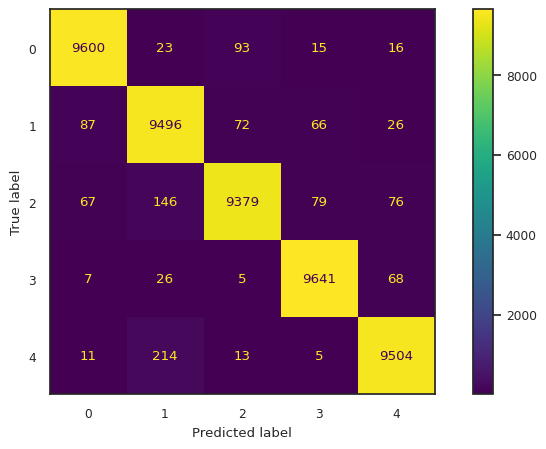

classification Error is : 2.2878834513183546%
___________________________________________________________________________
Accuracy Random Forest 0.9996511747204267
Accuracy test:  0.9976747366981261
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



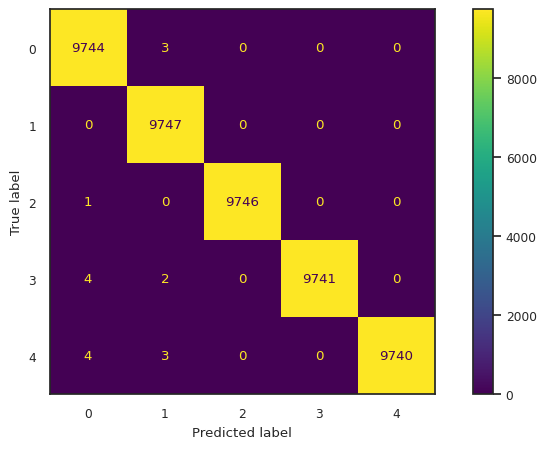

classification Error is : 0.034882527957320206%
___________________________________________________________________________
Accuracy Decision Tree 0.999774289524982
Accuracy test:  0.9984954178634934
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9747
           1       1.00      1.00      1.00      9747
           2       1.00      1.00      1.00      9747
           3       1.00      1.00      1.00      9747
           4       1.00      1.00      1.00      9747

    accuracy                           1.00     48735
   macro avg       1.00      1.00      1.00     48735
weighted avg       1.00      1.00      1.00     48735



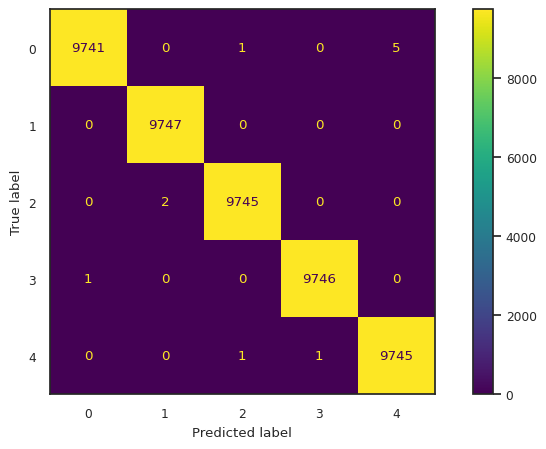

classification Error is : 0.02257104750179542%
___________________________________________________________________________
Accuracy KNearest 0.9609315686878014
Accuracy test:  0.9446040213377103
Accuracy train:  0.9638132483584395
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      9747
           1       0.97      0.95      0.96      9747
           2       0.96      0.92      0.94      9747
           3       1.00      0.99      0.99      9747
           4       1.00      0.98      0.99      9747

    accuracy                           0.96     48735
   macro avg       0.96      0.96      0.96     48735
weighted avg       0.96      0.96      0.96     48735



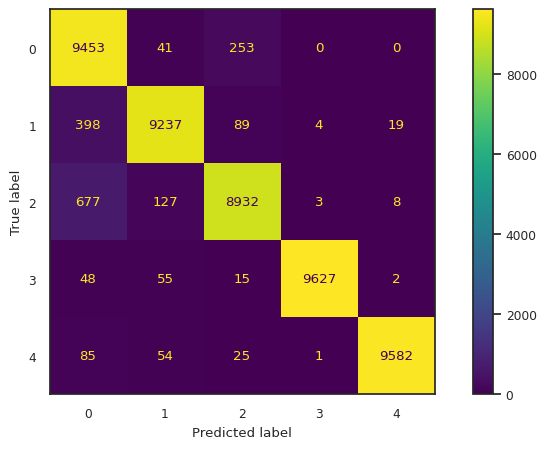

classification Error is : 3.9068431312198624%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NSMT,y_NSMT,B_method,ax[1][0])
# plot_decision_function(x_NSMT, y_NSMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SMOTE-N Oversampled Data:")
mean_lr = cross_val_info(lr, x_NSMT , y_NSMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SMOTE-N Oversampled Data:")
mean_rf = cross_val_info(rf, x_NSMT , y_NSMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SMOTE-N Oversampled Data:")
mean_dt = cross_val_info(dt, x_NSMT , y_NSMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SMOTE-N Oversampled Data:")
mean_kn = cross_val_info(kn, x_NSMT , y_NSMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SMOTE-N Oversampled Data:
Cross-Validation Scores: [0.69877911 0.739407   0.76084949 0.75715605 0.76741562]
Mean Accuracy: 0.7447214527546937
Standard Deviation: 0.024773776355433926
Cross-Validation for Random Forest on SMOTE-N Oversampled Data:
Cross-Validation Scores: [0.87247358 0.99917923 0.9977429  0.99702473 0.9977429 ]
Mean Accuracy: 0.9728326664614754
Standard Deviation: 0.05018442444758744
Cross-Validation for Decision Tree on SMOTE-N Oversampled Data:
Cross-Validation Scores: [0.90910024 0.9976403  0.99928183 0.99917923 0.99846106]
Mean Accuracy: 0.9807325330871037
Standard Deviation: 0.0358209900063621
Cross-Validation for K-Nearest Neighbors on SMOTE-N Oversampled Data:
Cross-Validation Scores: [0.72678773 0.84846619 0.94603468 0.94593208 0.94747102]
Mean Accuracy: 0.882938340002052
Standard Deviation: 0.08681609019146733


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SMOTE-N Oversampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_NSMT , y_NSMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SMOTE-N Oversampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_NSMT , y_NSMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SMOTE-N Oversampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_NSMT , y_NSMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-N Oversampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_NSMT , y_NSMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SMOTE-N Oversampled Data:
Stratified Cross-Validation Scores: [0.75510413 0.75756643 0.77316097 0.76659485 0.78701139]
Mean Accuracy: 0.7678875551451728
Standard Deviation: 0.011533797790009098
Stratified Cross-Validation for Random Forest on SMOTE-N Oversampled Data:
Stratified Cross-Validation Scores: [0.99651175 0.99640915 0.99671694 0.99671694 0.99712732]
Mean Accuracy: 0.9966964194111008
Standard Deviation: 0.0002462296091104858
Stratified Cross-Validation for Decision Tree on SMOTE-N Oversampled Data:
Stratified Cross-Validation Scores: [0.99651175 0.99702473 0.99569098 0.99784549 0.99671694]
Mean Accuracy: 0.9967579768133785
Standard Deviation: 0.0007006615811619484
Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-N Oversampled Data:
Stratified Cross-Validation Scores: [0.89863548 0.9029445  0.89925105 0.90017441 0.89730173]
Mean Accuracy: 0.899661434287473
Standard Deviation: 0.0018884293201753765


## Under-sampling
Generally there are two ways for this method :
1. Prototype Generation - This technique will reduce the number of samples in the targeted classes but the remaining samples are generated and not selected from the original set.
2. Prototype Selection -These algorithms will select samples from the original set.In addition, these algorithms can be divided into three groups:
- Methods that Select Examples to Keep
- Methods that Select Examples to Delete (Since these methods remove part of our data,we may need to repeat them multiple times to reach balance in our classes.)
- Combinations of Keep and Delete Methods (Since these methods remove part of our data,we may need to repeat them multiple times to reach balance in our classes.)

1. Cluster Centroids (Prototype Generation)

  This technique is a Prototype Generation algorithm which makes undersampling by generating a new set based on centroids by clustering methods. The algorithm is generating a new set according to the cluster centroid of a KMeans algorithm. Supports multi-class resampling by sampling each class independently.

In [ ]:
B_method = under_sampling.ClusterCentroids(random_state=42)
x_CC , y_CC = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_CC);newdf["Type_of_Anemia"]=y_CC
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.930718954248366
Accuracy test:  0.8608695652173913
Accuracy train:  0.943076923076923
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.92      0.80      0.86       153
           2       0.99      0.97      0.98       153
           3       0.93      0.98      0.96       153
           4       0.82      0.92      0.87       153

    accuracy                           0.93       765
   macro avg       0.93      0.93      0.93       765
weighted avg       0.93      0.93      0.93       765



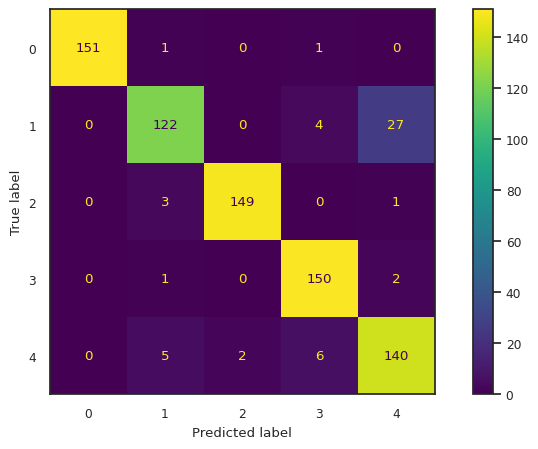

classification Error is : 6.928104575163399%
___________________________________________________________________________
Accuracy Random Forest 0.9934640522875817
Accuracy test:  0.9565217391304348
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.99      0.99      0.99       153
           2       0.99      0.99      0.99       153
           3       0.99      1.00      0.99       153
           4       1.00      1.00      1.00       153

    accuracy                           0.99       765
   macro avg       0.99      0.99      0.99       765
weighted avg       0.99      0.99      0.99       765



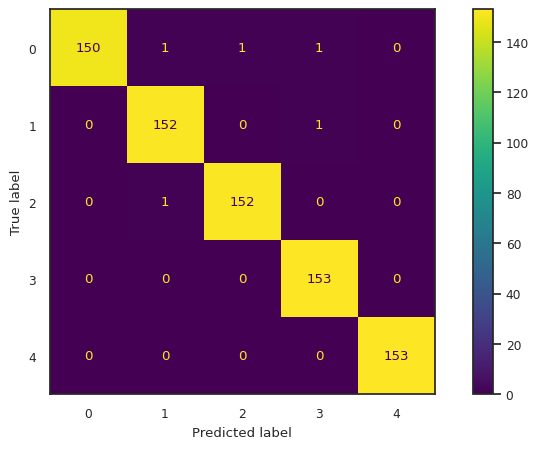

classification Error is : 0.6535947712418301%
___________________________________________________________________________
Accuracy Decision Tree 0.996078431372549
Accuracy test:  0.9739130434782609
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.99      1.00      1.00       153
           2       0.99      1.00      0.99       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



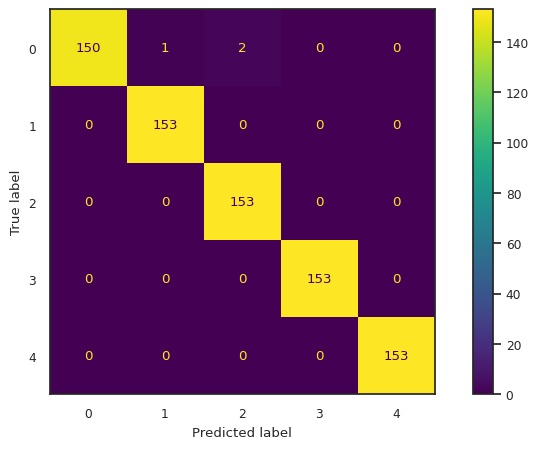

classification Error is : 0.39215686274509803%
___________________________________________________________________________
Accuracy KNearest 0.8352941176470589
Accuracy test:  0.7652173913043478
Accuracy train:  0.8476923076923077
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       153
           1       0.69      0.86      0.77       153
           2       0.87      0.93      0.90       153
           3       0.80      0.86      0.83       153
           4       0.90      0.54      0.67       153

    accuracy                           0.84       765
   macro avg       0.85      0.84      0.83       765
weighted avg       0.85      0.84      0.83       765



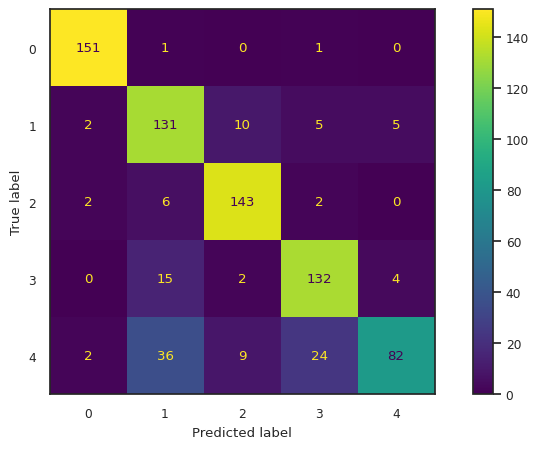

classification Error is : 16.470588235294116%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_CC,y_CC,B_method,ax[1][0])
# plot_decision_function(x_CC, y_CC, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Cluster Centroids Undersampled Data:")
mean_lr = cross_val_info(lr, x_CC , y_CC)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Cluster Centroids Undersampled Data:")
mean_rf = cross_val_info(rf, x_CC , y_CC)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Cluster Centroids Undersampled Data:")
mean_dt = cross_val_info(dt, x_CC , y_CC)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Cluster Centroids Undersampled Data:")
mean_kn = cross_val_info(kn, x_CC , y_CC)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Cluster Centroids Undersampled Data:
Cross-Validation Scores: [0.69281046 0.67973856 0.67973856 0.5751634  0.64705882]
Mean Accuracy: 0.6549019607843136
Standard Deviation: 0.04263923249751659
Cross-Validation for Random Forest on Cluster Centroids Undersampled Data:
Cross-Validation Scores: [0.98039216 0.97385621 0.99346405 0.9869281  0.99346405]
Mean Accuracy: 0.9856209150326798
Standard Deviation: 0.007622159339667082
Cross-Validation for Decision Tree on Cluster Centroids Undersampled Data:
Cross-Validation Scores: [0.98039216 0.9869281  0.97385621 0.9869281  0.98039216]
Mean Accuracy: 0.9816993464052288
Standard Deviation: 0.004891055407547666
Cross-Validation for K-Nearest Neighbors on Cluster Centroids Undersampled Data:
Cross-Validation Scores: [0.32026144 0.32026144 0.35294118 0.31372549 0.33333333]
Mean Accuracy: 0.3281045751633987
Standard Deviation: 0.013956965035335061


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Cluster Centroids Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_CC , y_CC)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Cluster Centroids Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_CC , y_CC)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Cluster Centroids Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_CC , y_CC)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Cluster Centroids Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_CC , y_CC)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Cluster Centroids Undersampled Data:
Stratified Cross-Validation Scores: [0.70588235 0.62091503 0.62091503 0.69281046 0.64705882]
Mean Accuracy: 0.6575163398692812
Standard Deviation: 0.035703268715680164
Stratified Cross-Validation for Random Forest on Cluster Centroids Undersampled Data:
Stratified Cross-Validation Scores: [0.98039216 0.99346405 0.9869281  1.         0.98039216]
Mean Accuracy: 0.9882352941176471
Standard Deviation: 0.007622159339667078
Stratified Cross-Validation for Decision Tree on Cluster Centroids Undersampled Data:
Stratified Cross-Validation Scores: [0.98039216 0.99346405 0.9869281  1.         0.98039216]
Mean Accuracy: 0.9882352941176471
Standard Deviation: 0.007622159339667078
Stratified Cross-Validation for K-Nearest Neighbors on Cluster Centroids Undersampled Data:
Stratified Cross-Validation Scores: [0.32026144 0.32026144 0.33333333 0.33986928 0.30718954]
Mean Accuracy: 0.32418300653594767
Standard Dev

2. Random Under Sampler (Prototype Selection) (i)

  It is a controlled under-sampling technique which randomly deletes the rows of the majority class(es) according to our sampling strategy.Supports multi-class resampling by sampling each class independently. Supports heterogeneous data as object array containing string and numeric data.

In [ ]:
B_method = under_sampling.RandomUnderSampler(random_state=42)
x_RUS , y_RUS = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_RUS);newdf["Type_of_Anemia"]=y_RUS
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9137254901960784
Accuracy test:  0.8608695652173913
Accuracy train:  0.9230769230769231
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       153
           1       0.90      0.78      0.84       153
           2       0.95      0.94      0.94       153
           3       0.91      0.98      0.95       153
           4       0.83      0.95      0.89       153

    accuracy                           0.91       765
   macro avg       0.92      0.91      0.91       765
weighted avg       0.92      0.91      0.91       765



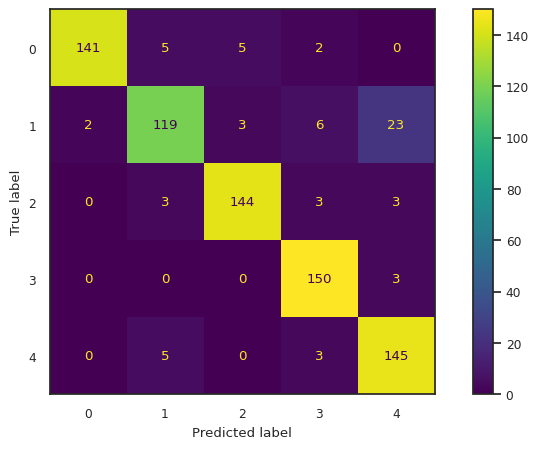

classification Error is : 8.627450980392156%
___________________________________________________________________________
Accuracy Random Forest 0.996078431372549
Accuracy test:  0.9739130434782609
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       153
           1       0.98      1.00      0.99       153
           2       1.00      0.99      1.00       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



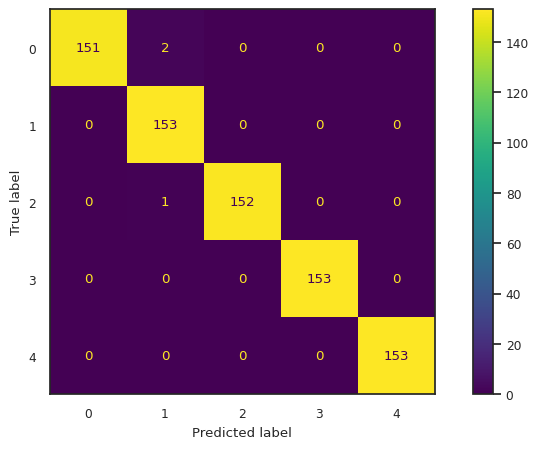

classification Error is : 0.39215686274509803%
___________________________________________________________________________
Accuracy Decision Tree 0.9986928104575163
Accuracy test:  0.991304347826087
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       153
           2       1.00      1.00      1.00       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



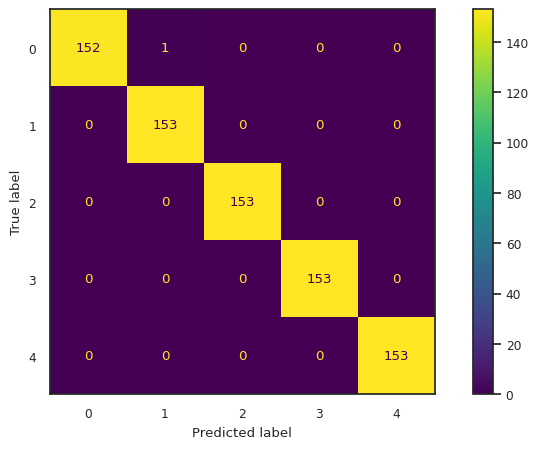

classification Error is : 0.130718954248366%
___________________________________________________________________________
Accuracy KNearest 0.7254901960784313
Accuracy test:  0.6086956521739131
Accuracy train:  0.7461538461538462
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       153
           1       0.55      0.71      0.62       153
           2       0.78      0.73      0.75       153
           3       0.73      0.80      0.77       153
           4       0.79      0.54      0.64       153

    accuracy                           0.73       765
   macro avg       0.74      0.73      0.73       765
weighted avg       0.74      0.73      0.73       765



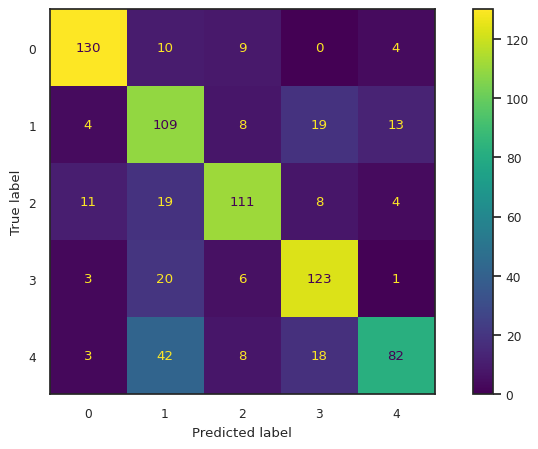

classification Error is : 27.450980392156865%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_RUS,y_RUS,B_method,ax[1][0])
# plot_decision_function(x_RUS, y_RUS, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Random Under Sampler Data:")
mean_lr = cross_val_info(lr, x_RUS , y_RUS)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Random Under Sampler Data:")
mean_rf = cross_val_info(rf, x_RUS , y_RUS)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Random Under Sampler Data:")
mean_dt = cross_val_info(dt, x_RUS , y_RUS)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Random Under Sampler Data:")
mean_kn = cross_val_info(kn, x_RUS , y_RUS)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Random Under Sampler Data:
Cross-Validation Scores: [0.58823529 0.67320261 0.61437908 0.54248366 0.58823529]
Mean Accuracy: 0.6013071895424836
Standard Deviation: 0.042759286885741536
Cross-Validation for Random Forest on Random Under Sampler Data:
Cross-Validation Scores: [0.93464052 0.92156863 0.91503268 0.94771242 0.96078431]
Mean Accuracy: 0.9359477124183007
Standard Deviation: 0.01674019408479178
Cross-Validation for Decision Tree on Random Under Sampler Data:
Cross-Validation Scores: [0.97385621 0.98039216 0.94117647 1.         0.99346405]
Mean Accuracy: 0.9777777777777779
Standard Deviation: 0.020502466851448534
Cross-Validation for K-Nearest Neighbors on Random Under Sampler Data:
Cross-Validation Scores: [0.49673203 0.53594771 0.53594771 0.52287582 0.55555556]
Mean Accuracy: 0.5294117647058822
Standard Deviation: 0.019388754214629184


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Random Under Sampler Data:")
mean_lr = stratified_cross_val_info(lr_st, x_RUS , y_RUS)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Random Under Sampler Data:")
mean_rf = stratified_cross_val_info(rf_st, x_RUS , y_RUS)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Random Under Sampler Data:")
mean_dt = stratified_cross_val_info(rf_st, x_RUS , y_RUS)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Random Under Sampler Data:")
mean_kn = stratified_cross_val_info(kn_st, x_RUS , y_RUS)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Random Under Sampler Data:
Stratified Cross-Validation Scores: [0.58169935 0.66013072 0.58169935 0.59477124 0.61437908]
Mean Accuracy: 0.6065359477124184
Standard Deviation: 0.029346332445285797
Stratified Cross-Validation for Random Forest on Random Under Sampler Data:
Stratified Cross-Validation Scores: [0.93464052 0.94771242 0.94771242 0.94771242 0.93464052]
Mean Accuracy: 0.9424836601307189
Standard Deviation: 0.006403894752374299
Stratified Cross-Validation for Decision Tree on Random Under Sampler Data:
Stratified Cross-Validation Scores: [0.92156863 0.94771242 0.94771242 0.94117647 0.92810458]
Mean Accuracy: 0.9372549019607843
Standard Deviation: 0.010619658045275761
Stratified Cross-Validation for K-Nearest Neighbors on Random Under Sampler Data:
Stratified Cross-Validation Scores: [0.55555556 0.5751634  0.51633987 0.46405229 0.50326797]
Mean Accuracy: 0.5228758169934641
Standard Deviation: 0.03921568627450979


3. Near Miss (Prototype Selection) (i)

  Method that under samples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm. This algorithm keeps N majority samples by fitting the KMeans algorithm with N cluster to the majority class and using the coordinates of the N cluster centroids as the new majority samples.If there are k instances in the minority class, the nearest method will result in k*n instances of the majority class. Supports multi-class resampling.

  NearMiss has 3 versions :
  - NearMiss-1 selects the positive samples for which the average distance to the k closest samples of the negative class is the smallest.
  - NearMiss-2 selects the positive samples for which the average distance to the k farthest samples of the negative class is the smallest.
  - NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their m nearest-neighbors will be kept. Then, the positive samples selected are the ones for which the average distance to the k nearest-neighbors is the largest.

- Near Miss V1

In [ ]:
B_method = under_sampling.NearMiss(version=1)
x_NM , y_NM = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_NM);newdf["Type_of_Anemia"]=y_NM
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9019607843137255
Accuracy test:  0.8608695652173913
Accuracy train:  0.9092307692307692
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       153
           1       0.87      0.80      0.84       153
           2       0.84      0.86      0.85       153
           3       0.94      0.97      0.95       153
           4       0.88      0.92      0.89       153

    accuracy                           0.90       765
   macro avg       0.90      0.90      0.90       765
weighted avg       0.90      0.90      0.90       765



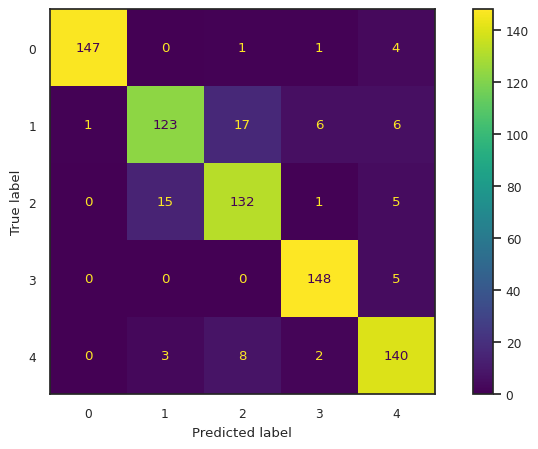

classification Error is : 9.803921568627452%
___________________________________________________________________________
Accuracy Random Forest 0.9947712418300654
Accuracy test:  0.9652173913043478
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       153
           1       0.99      1.00      1.00       153
           2       1.00      1.00      1.00       153
           3       1.00      1.00      1.00       153
           4       0.98      1.00      0.99       153

    accuracy                           0.99       765
   macro avg       0.99      0.99      0.99       765
weighted avg       0.99      0.99      0.99       765



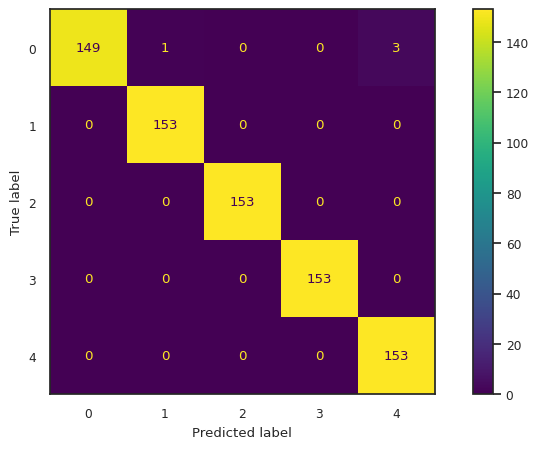

classification Error is : 0.522875816993464%
___________________________________________________________________________
Accuracy Decision Tree 0.9934640522875817
Accuracy test:  0.9565217391304348
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.99      0.99       153
           2       1.00      1.00      1.00       153
           3       1.00      0.99      0.99       153
           4       1.00      1.00      1.00       153

    accuracy                           0.99       765
   macro avg       0.99      0.99      0.99       765
weighted avg       0.99      0.99      0.99       765



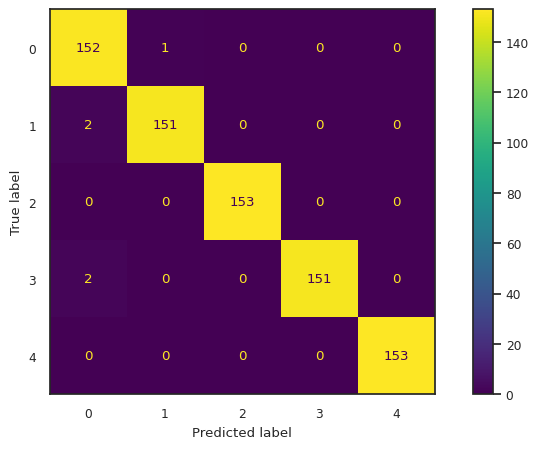

classification Error is : 0.6535947712418301%
___________________________________________________________________________
Accuracy KNearest 0.7150326797385621
Accuracy test:  0.591304347826087
Accuracy train:  0.7369230769230769
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       153
           1       0.53      0.75      0.62       153
           2       0.70      0.76      0.73       153
           3       0.89      0.69      0.77       153
           4       0.74      0.42      0.53       153

    accuracy                           0.72       765
   macro avg       0.74      0.72      0.71       765
weighted avg       0.74      0.72      0.71       765



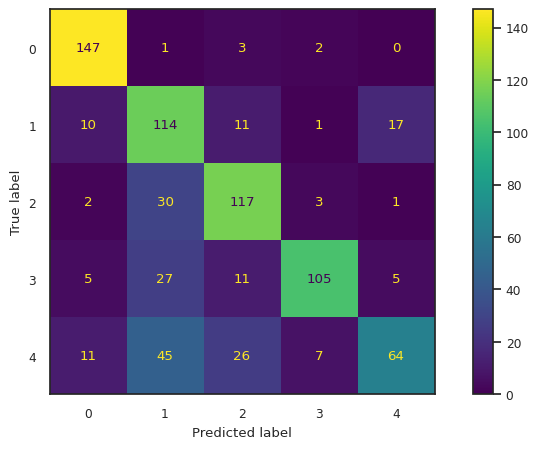

classification Error is : 28.49673202614379%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method,"V1")

info_func_LR(newdf,"Type_of_Anemia",B_method,"V1")
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method,"V1")
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method,"V1")
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method,"V1")

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NM,y_NM,B_method,ax[1][0])
# plot_decision_function(x_NM, y_NM, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Near Miss V1 Undersampled Data:")
mean_lr = cross_val_info(lr, x_NM , y_NM)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Near Miss V1 Undersampled Data:")
mean_rf = cross_val_info(rf, x_NM , y_NM)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Near Miss V1 Undersampled Data:")
mean_dt = cross_val_info(dt, x_NM , y_NM)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Near Miss V1 Undersampled Data:")
mean_kn = cross_val_info(kn, x_NM , y_NM)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Near Miss V1 Undersampled Data:
Cross-Validation Scores: [0.79738562 0.77777778 0.7254902  0.7124183  0.80392157]
Mean Accuracy: 0.7633986928104577
Standard Deviation: 0.03752339893962701
Cross-Validation for Random Forest on Near Miss V1 Undersampled Data:
Cross-Validation Scores: [0.94117647 0.95424837 0.95424837 0.9869281  0.98039216]
Mean Accuracy: 0.9633986928104574
Standard Deviation: 0.01734182896917856
Cross-Validation for Decision Tree on Near Miss V1 Undersampled Data:
Cross-Validation Scores: [0.97385621 0.94771242 0.98039216 0.95424837 0.97385621]
Mean Accuracy: 0.9660130718954247
Standard Deviation: 0.012673672829846598
Cross-Validation for K-Nearest Neighbors on Near Miss V1 Undersampled Data:
Cross-Validation Scores: [0.45751634 0.66666667 0.64705882 0.71895425 0.76470588]
Mean Accuracy: 0.6509803921568628
Standard Deviation: 0.1051129960416974


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Near Miss V1 Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_NM , y_NM)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Near Miss V1 Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Near Miss V1 Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V1 Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_NM , y_NM)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Near Miss V1 Undersampled Data:
Stratified Cross-Validation Scores: [0.75816993 0.77777778 0.77777778 0.71895425 0.7254902 ]
Mean Accuracy: 0.7516339869281046
Standard Deviation: 0.02514429289107366
Stratified Cross-Validation for Random Forest on Near Miss V1 Undersampled Data:
Stratified Cross-Validation Scores: [0.95424837 0.97385621 0.94771242 0.96732026 0.95424837]
Mean Accuracy: 0.9594771241830065
Standard Deviation: 0.009605842128561476
Stratified Cross-Validation for Decision Tree on Near Miss V1 Undersampled Data:
Stratified Cross-Validation Scores: [0.95424837 0.97385621 0.96078431 0.96078431 0.95424837]
Mean Accuracy: 0.9607843137254901
Standard Deviation: 0.007159771993531558
Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V1 Undersampled Data:
Stratified Cross-Validation Scores: [0.66666667 0.67973856 0.68627451 0.62091503 0.65359477]
Mean Accuracy: 0.661437908496732
Standard Deviation: 0.0231634577080

- Near Miss V2

In [ ]:
B_method = under_sampling.NearMiss(version=2)
x_NM , y_NM = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_NM);newdf["Type_of_Anemia"]=y_NM
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9267973856209151
Accuracy test:  0.8869565217391304
Accuracy train:  0.9338461538461539
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       153
           1       0.94      0.86      0.90       153
           2       0.92      0.94      0.93       153
           3       0.88      0.90      0.89       153
           4       0.94      0.96      0.95       153

    accuracy                           0.93       765
   macro avg       0.93      0.93      0.93       765
weighted avg       0.93      0.93      0.93       765



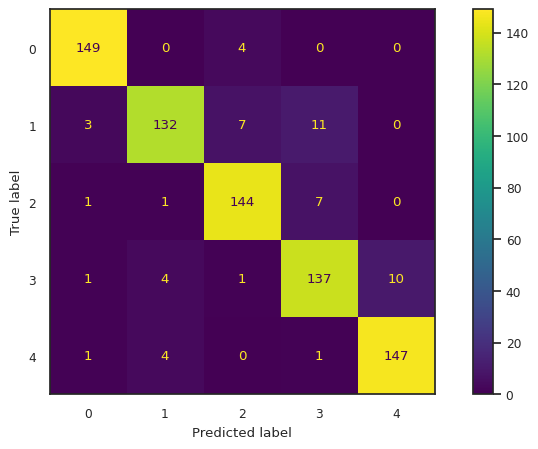

classification Error is : 7.320261437908497%
___________________________________________________________________________
Accuracy Random Forest 0.996078431372549
Accuracy test:  0.9739130434782609
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       153
           1       0.99      1.00      1.00       153
           2       0.99      1.00      1.00       153
           3       0.99      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



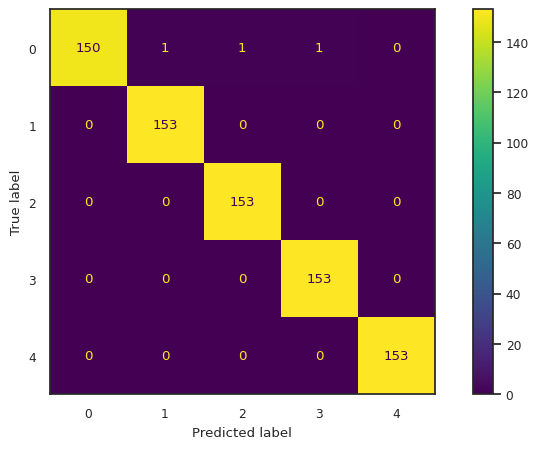

classification Error is : 0.39215686274509803%
___________________________________________________________________________
Accuracy Decision Tree 0.996078431372549
Accuracy test:  0.9739130434782609
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       1.00      1.00      1.00       153
           2       1.00      0.99      1.00       153
           3       0.99      0.99      0.99       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



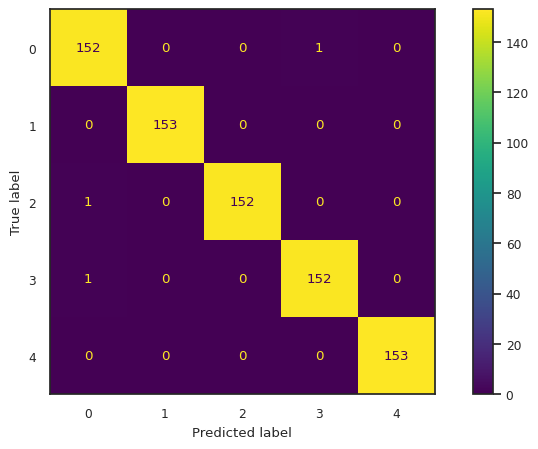

classification Error is : 0.39215686274509803%
___________________________________________________________________________
Accuracy KNearest 0.7320261437908496
Accuracy test:  0.5739130434782609
Accuracy train:  0.76
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       153
           1       0.66      0.67      0.67       153
           2       0.74      0.74      0.74       153
           3       0.68      0.64      0.66       153
           4       0.81      0.73      0.77       153

    accuracy                           0.73       765
   macro avg       0.73      0.73      0.73       765
weighted avg       0.73      0.73      0.73       765



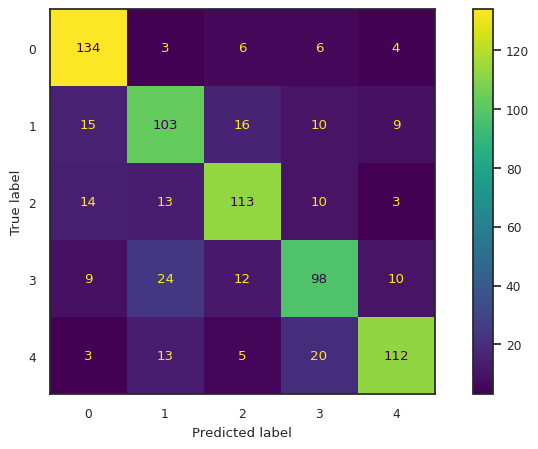

classification Error is : 26.797385620915033%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method,"V2")

info_func_LR(newdf,"Type_of_Anemia",B_method,"V2")
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method,"V2")
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method,"V2")
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method,"V2")

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NM,y_NM,B_method,ax[1][0])
# plot_decision_function(x_NM, y_NM, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Near Miss V2 Undersampled Data:")
mean_lr = cross_val_info(lr, x_NM , y_NM)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Near Miss V2 Undersampled Data:")
mean_rf = cross_val_info(rf, x_NM , y_NM)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Near Miss V2 Undersampled Data:")
mean_dt = cross_val_info(dt, x_NM , y_NM)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Near Miss V2 Undersampled Data:")
mean_kn = cross_val_info(kn, x_NM , y_NM)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Near Miss V2 Undersampled Data:
Cross-Validation Scores: [0.62091503 0.67973856 0.65359477 0.62091503 0.67973856]
Mean Accuracy: 0.6509803921568628
Standard Deviation: 0.026339139450470443
Cross-Validation for Random Forest on Near Miss V2 Undersampled Data:
Cross-Validation Scores: [0.86928105 0.95424837 0.92810458 0.96732026 0.96078431]
Mean Accuracy: 0.9359477124183007
Standard Deviation: 0.03589419664770191
Cross-Validation for Decision Tree on Near Miss V2 Undersampled Data:
Cross-Validation Scores: [0.81045752 0.94771242 0.94117647 0.97385621 0.92156863]
Mean Accuracy: 0.9189542483660131
Standard Deviation: 0.0567687601323097
Cross-Validation for K-Nearest Neighbors on Near Miss V2 Undersampled Data:
Cross-Validation Scores: [0.31372549 0.41176471 0.46405229 0.58823529 0.47712418]
Mean Accuracy: 0.45098039215686275
Standard Deviation: 0.08952101264451731


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Near Miss V2 Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_NM , y_NM)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Near Miss V2 Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Near Miss V2 Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V2 Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_NM , y_NM)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Near Miss V2 Undersampled Data:
Stratified Cross-Validation Scores: [0.69281046 0.69934641 0.67973856 0.70588235 0.67973856]
Mean Accuracy: 0.6915032679738562
Standard Deviation: 0.010457516339869273
Stratified Cross-Validation for Random Forest on Near Miss V2 Undersampled Data:
Stratified Cross-Validation Scores: [0.93464052 0.97385621 0.94771242 0.96732026 0.94117647]
Mean Accuracy: 0.9529411764705882
Standard Deviation: 0.015131812944823821
Stratified Cross-Validation for Decision Tree on Near Miss V2 Undersampled Data:
Stratified Cross-Validation Scores: [0.92810458 0.96732026 0.94771242 0.96078431 0.92810458]
Mean Accuracy: 0.9464052287581699
Standard Deviation: 0.01622179561567431
Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V2 Undersampled Data:
Stratified Cross-Validation Scores: [0.5751634  0.52941176 0.5751634  0.58169935 0.50326797]
Mean Accuracy: 0.5529411764705883
Standard Deviation: 0.031099025499

- Near Miss V3

In [ ]:
B_method = under_sampling.NearMiss(version=3)
x_NM , y_NM = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_NM);newdf["Type_of_Anemia"]=y_NM
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.8870292887029289
Accuracy test:  0.8148148148148148
Accuracy train:  0.8998357963875205
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       153
           1       0.88      0.76      0.81       153
           2       0.85      0.88      0.86       153
           3       0.86      0.93      0.89       153
           4       0.89      0.91      0.90       105

    accuracy                           0.89       717
   macro avg       0.89      0.89      0.89       717
weighted avg       0.89      0.89      0.89       717



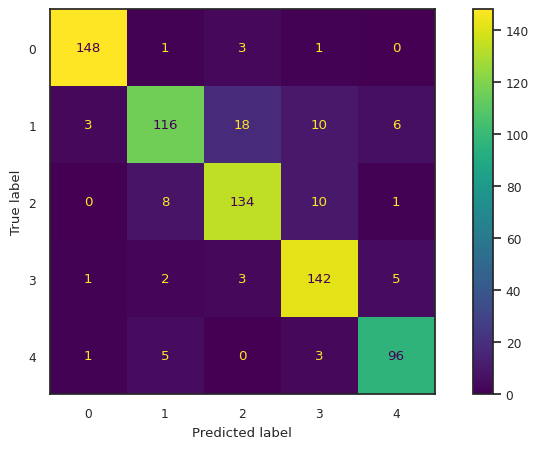

classification Error is : 11.297071129707113%
___________________________________________________________________________
Accuracy Random Forest 0.9902370990237099
Accuracy test:  0.9351851851851852
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       153
           1       0.99      0.99      0.99       153
           2       0.98      1.00      0.99       153
           3       0.99      1.00      1.00       153
           4       1.00      1.00      1.00       105

    accuracy                           0.99       717
   macro avg       0.99      0.99      0.99       717
weighted avg       0.99      0.99      0.99       717



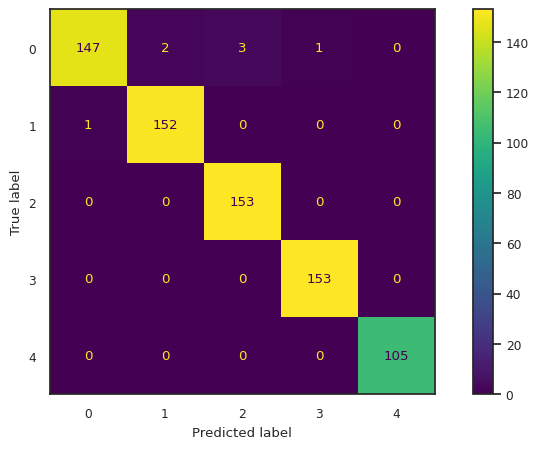

classification Error is : 0.9762900976290098%
___________________________________________________________________________
Accuracy Decision Tree 0.99860529986053
Accuracy test:  0.9907407407407407
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       1.00      1.00      1.00       153
           2       0.99      1.00      1.00       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       105

    accuracy                           1.00       717
   macro avg       1.00      1.00      1.00       717
weighted avg       1.00      1.00      1.00       717



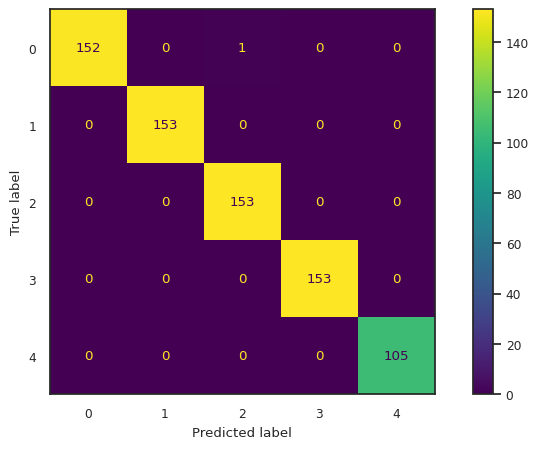

classification Error is : 0.1394700139470014%
___________________________________________________________________________
Accuracy KNearest 0.7364016736401674
Accuracy test:  0.5833333333333334
Accuracy train:  0.7635467980295566
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       153
           1       0.64      0.70      0.67       153
           2       0.75      0.76      0.76       153
           3       0.73      0.66      0.69       153
           4       0.70      0.68      0.69       105

    accuracy                           0.74       717
   macro avg       0.74      0.73      0.73       717
weighted avg       0.74      0.74      0.74       717



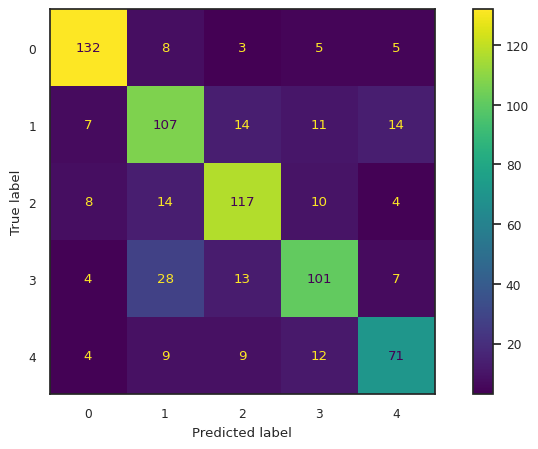

classification Error is : 26.359832635983267%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method,"V3")

info_func_LR(newdf,"Type_of_Anemia",B_method,"V3")
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method,"V3")
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method,"V3")
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method,"V3")

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NM,y_NM,B_method,ax[1][0])
# plot_decision_function(x_NM, y_NM, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on Near Miss V3 Undersampled Data:")
mean_lr = cross_val_info(lr, x_NM , y_NM)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on Near Miss V3 Undersampled Data:")
mean_rf = cross_val_info(rf, x_NM , y_NM)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on Near Miss V3 Undersampled Data:")
mean_dt = cross_val_info(dt, x_NM , y_NM)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on Near Miss V3 Undersampled Data:")
mean_kn = cross_val_info(kn, x_NM , y_NM)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on Near Miss V3 Undersampled Data:
Cross-Validation Scores: [0.64583333 0.55555556 0.58741259 0.56643357 0.66433566]
Mean Accuracy: 0.6039141414141413
Standard Deviation: 0.0434134234883569
Cross-Validation for Random Forest on Near Miss V3 Undersampled Data:
Cross-Validation Scores: [0.92361111 0.88888889 0.93706294 0.91608392 0.97902098]
Mean Accuracy: 0.9289335664335665
Standard Deviation: 0.029569760942410015
Cross-Validation for Decision Tree on Near Miss V3 Undersampled Data:
Cross-Validation Scores: [0.95138889 0.96527778 0.96503497 0.97202797 0.98601399]
Mean Accuracy: 0.9679487179487178
Standard Deviation: 0.011250298129765381
Cross-Validation for K-Nearest Neighbors on Near Miss V3 Undersampled Data:
Cross-Validation Scores: [0.1875     0.34722222 0.34965035 0.34965035 0.3006993 ]
Mean Accuracy: 0.3069444444444444
Standard Deviation: 0.06257134358580939


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on Near Miss V3 Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_NM , y_NM)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on Near Miss V3 Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on Near Miss V3 Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_NM , y_NM)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V3 Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_NM , y_NM)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on Near Miss V3 Undersampled Data:
Stratified Cross-Validation Scores: [0.64583333 0.63194444 0.71328671 0.61538462 0.55944056]
Mean Accuracy: 0.6331779331779332
Standard Deviation: 0.04966467505550593
Stratified Cross-Validation for Random Forest on Near Miss V3 Undersampled Data:
Stratified Cross-Validation Scores: [0.93055556 0.95833333 0.92307692 0.94405594 0.95804196]
Mean Accuracy: 0.9428127428127429
Standard Deviation: 0.014241520256203169
Stratified Cross-Validation for Decision Tree on Near Miss V3 Undersampled Data:
Stratified Cross-Validation Scores: [0.92361111 0.95833333 0.9020979  0.93706294 0.95104895]
Mean Accuracy: 0.9344308469308469
Standard Deviation: 0.020084342876697622
Stratified Cross-Validation for K-Nearest Neighbors on Near Miss V3 Undersampled Data:
Stratified Cross-Validation Scores: [0.40277778 0.35416667 0.34265734 0.34965035 0.27272727]
Mean Accuracy: 0.3443958818958819
Standard Deviation: 0.041643572113

4. Condensed Nearest Neighbour (Prototype Selection) (i)

  Condensed Nearest Neighbors, or CNN for short, is an undersampling technique that seeks a subset of a collection of samples that results in no loss in model performance, referred to as a minimal consistent set. Supports multi-class resampling.

In [ ]:
B_method = under_sampling.CondensedNearestNeighbour(random_state=42,n_jobs=-1)
x_CNN , y_CNN = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_CNN);newdf["Type_of_Anemia"]=y_CNN
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9002713704206241
Accuracy test:  0.8828828828828829
Accuracy train:  0.9033546325878594
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       621
           1       0.85      0.80      0.82       304
           2       0.85      0.88      0.86       324
           3       0.86      0.95      0.91       153
           4       0.81      0.60      0.69        72

    accuracy                           0.90      1474
   macro avg       0.87      0.84      0.85      1474
weighted avg       0.90      0.90      0.90      1474



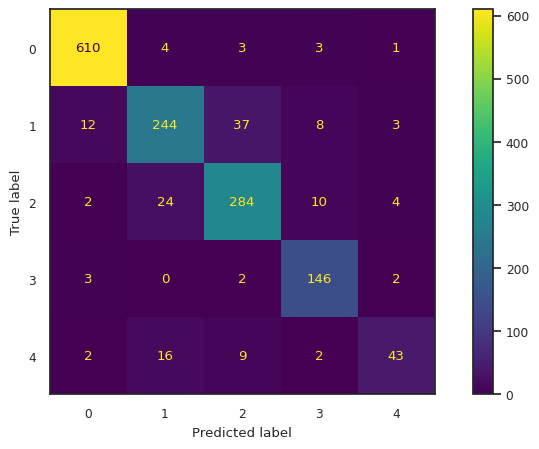

classification Error is : 9.972862957937584%
___________________________________________________________________________
Accuracy Random Forest 0.9938941655359566
Accuracy test:  0.9594594594594594
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       621
           1       0.99      1.00      1.00       304
           2       0.99      1.00      1.00       324
           3       0.98      0.99      0.99       153
           4       1.00      1.00      1.00        72

    accuracy                           0.99      1474
   macro avg       0.99      1.00      0.99      1474
weighted avg       0.99      0.99      0.99      1474



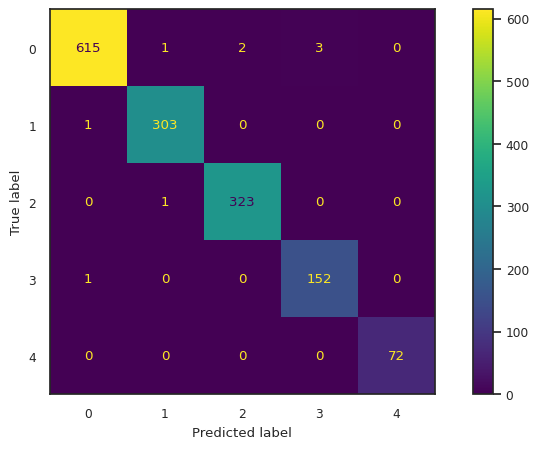

classification Error is : 0.6105834464043419%
___________________________________________________________________________
Accuracy Decision Tree 0.9979647218453188
Accuracy test:  0.9864864864864865
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       621
           1       1.00      1.00      1.00       304
           2       1.00      1.00      1.00       324
           3       0.99      0.99      0.99       153
           4       1.00      1.00      1.00        72

    accuracy                           1.00      1474
   macro avg       1.00      1.00      1.00      1474
weighted avg       1.00      1.00      1.00      1474



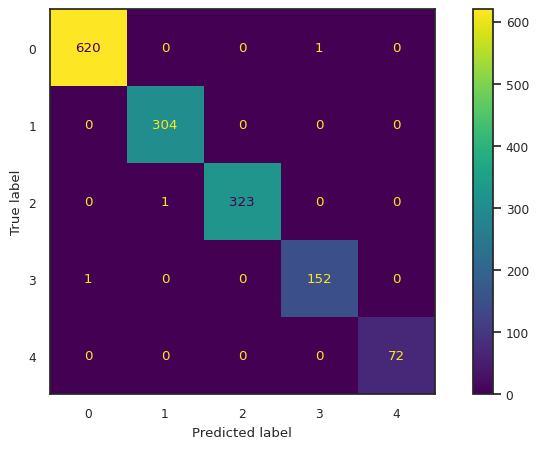

classification Error is : 0.20352781546811397%
___________________________________________________________________________
Accuracy KNearest 0.7313432835820896
Accuracy test:  0.6576576576576577
Accuracy train:  0.744408945686901
              precision    recall  f1-score   support

           0       0.80      0.97      0.87       621
           1       0.58      0.65      0.62       304
           2       0.76      0.63      0.69       324
           3       0.71      0.42      0.53       153
           4       0.56      0.14      0.22        72

    accuracy                           0.73      1474
   macro avg       0.68      0.56      0.59      1474
weighted avg       0.72      0.73      0.71      1474



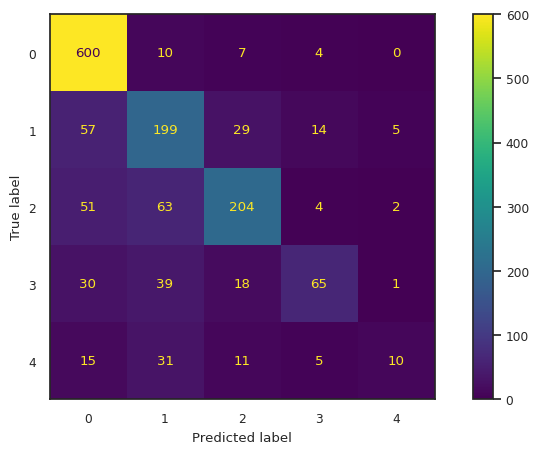

classification Error is : 26.865671641791046%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_CNN,y_CNN,B_method,ax[1][0])
# plot_decision_function(x_CNN, y_CNN, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on CNN Undersampled Data:")
mean_lr = cross_val_info(lr, x_CNN , y_CNN)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on CNN Undersampled Data:")
mean_rf = cross_val_info(rf, x_CNN , y_CNN)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on CNN Undersampled Data:")
mean_dt = cross_val_info(dt, x_CNN , y_CNN)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on CNN Undersampled Data:")
mean_kn = cross_val_info(kn, x_CNN , y_CNN)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on CNN Undersampled Data:
Cross-Validation Scores: [0.63728814 0.57288136 0.63728814 0.59661017 0.66666667]
Mean Accuracy: 0.6221468926553672
Standard Deviation: 0.033225719230714754
Cross-Validation for Random Forest on CNN Undersampled Data:
Cross-Validation Scores: [0.97966102 0.87118644 0.95932203 0.97966102 0.8537415 ]
Mean Accuracy: 0.9287144010146431
Standard Deviation: 0.05487867556376948
Cross-Validation for Decision Tree on CNN Undersampled Data:
Cross-Validation Scores: [0.99661017 0.97627119 0.99661017 0.98644068 0.92517007]
Mean Accuracy: 0.9762204542834084
Standard Deviation: 0.026616079558489696
Cross-Validation for K-Nearest Neighbors on CNN Undersampled Data:
Cross-Validation Scores: [0.36271186 0.3220339  0.30847458 0.2779661  0.32312925]
Mean Accuracy: 0.3188631384757293
Standard Deviation: 0.02731832369618911


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on CNN Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_CNN , y_CNN)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on CNN Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_CNN , y_CNN)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on CNN Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_CNN , y_CNN)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on CNN Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_CNN , y_CNN)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on CNN Undersampled Data:
Stratified Cross-Validation Scores: [0.62033898 0.64745763 0.6        0.66779661 0.63605442]
Mean Accuracy: 0.6343295284215381
Standard Deviation: 0.023106794128995096
Stratified Cross-Validation for Random Forest on CNN Undersampled Data:
Stratified Cross-Validation Scores: [0.94237288 0.96271186 0.94915254 0.94237288 0.97959184]
Mean Accuracy: 0.955240401245244
Standard Deviation: 0.014262000799498612
Stratified Cross-Validation for Decision Tree on CNN Undersampled Data:
Stratified Cross-Validation Scores: [0.95932203 0.95932203 0.94915254 0.94915254 0.96938776]
Mean Accuracy: 0.9572673815288828
Standard Deviation: 0.007576910680835549
Stratified Cross-Validation for K-Nearest Neighbors on CNN Undersampled Data:
Stratified Cross-Validation Scores: [0.30508475 0.33559322 0.31525424 0.28813559 0.29591837]
Mean Accuracy: 0.30799723279142166
Standard Deviation: 0.016511020202037253


5. Edited Nearest Neighbours (Prototype Selection) (ii)
  It is an undersampling method technique that removes the majority class to match the minority class. ENN works by removing samples whose class label differs from the class of the majority of their k nearest neighbors.It supports multi-class resampling. If you have multiple classes you need to use different sampling_strategy (it's an hyperparameter of this method).

In [ ]:
B_method = under_sampling.EditedNearestNeighbours()
x_ENN , y_ENN = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_ENN);newdf["Type_of_Anemia"]=y_ENN
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9936496736637855
Accuracy test:  0.9858989424206815
Accuracy train:  0.9950186799501868
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      0.67      0.80        18
           2       0.99      0.98      0.99       869
           3       0.95      0.95      0.95       153
           4       1.00      0.93      0.97        15

    accuracy                           0.99      5669
   macro avg       0.99      0.91      0.94      5669
weighted avg       0.99      0.99      0.99      5669



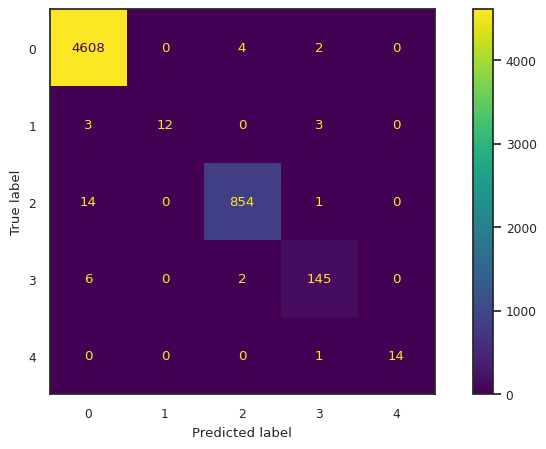

classification Error is : 0.63503263362145%
___________________________________________________________________________
Accuracy Random Forest 0.9982360204621626
Accuracy test:  0.9882491186839013
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00       869
           3       1.00      0.97      0.98       153
           4       1.00      1.00      1.00        15

    accuracy                           1.00      5669
   macro avg       1.00      0.97      0.98      5669
weighted avg       1.00      1.00      1.00      5669



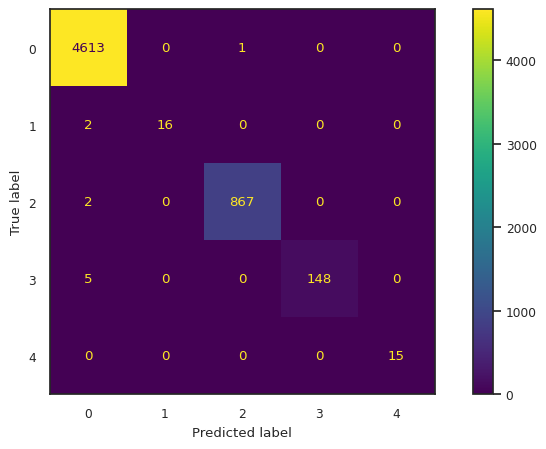

classification Error is : 0.17639795378373613%
___________________________________________________________________________
Accuracy Decision Tree 0.9987652143235138
Accuracy test:  0.9917743830787309
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00       869
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00        15

    accuracy                           1.00      5669
   macro avg       0.99      0.99      0.99      5669
weighted avg       1.00      1.00      1.00      5669



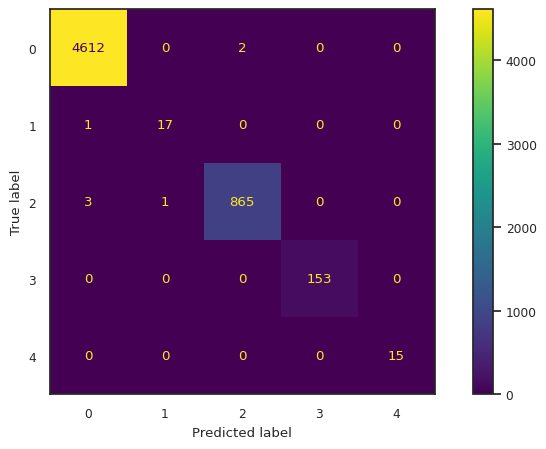

classification Error is : 0.12347856764861528%
___________________________________________________________________________
Accuracy KNearest 0.9714235314870348
Accuracy test:  0.9576968272620446
Accuracy train:  0.9738480697384807
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4614
           1       1.00      0.17      0.29        18
           2       0.98      0.91      0.95       869
           3       0.85      0.63      0.72       153
           4       0.92      0.80      0.86        15

    accuracy                           0.97      5669
   macro avg       0.95      0.70      0.76      5669
weighted avg       0.97      0.97      0.97      5669



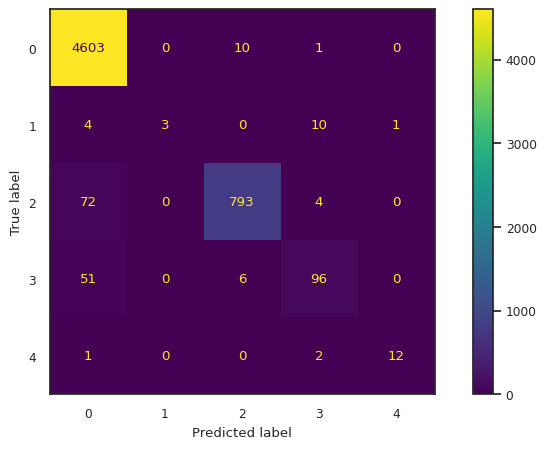

classification Error is : 2.857646851296525%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_ENN,y_ENN,B_method,ax[1][0])
# plot_decision_function(x_ENN, y_ENN, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on ENN Undersampled Data:")
mean_lr = cross_val_info(lr, x_ENN , y_ENN)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on ENN Undersampled Data:")
mean_rf = cross_val_info(rf, x_ENN , y_ENN)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on ENN Undersampled Data:")
mean_dt = cross_val_info(dt, x_ENN , y_ENN)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on ENN Undersampled Data:")
mean_kn = cross_val_info(kn, x_ENN , y_ENN)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on ENN Undersampled Data:
Cross-Validation Scores: [0.93121693 0.95149912 0.95149912 0.94973545 0.94439541]
Mean Accuracy: 0.9456692055397558
Standard Deviation: 0.0076811573533647395
Cross-Validation for Random Forest on ENN Undersampled Data:
Cross-Validation Scores: [0.96208113 0.98765432 0.99029982 0.99911817 0.99382171]
Mean Accuracy: 0.9865950302843507
Standard Deviation: 0.012843930974247427
Cross-Validation for Decision Tree on ENN Undersampled Data:
Cross-Validation Scores: [0.9638448  0.98765432 0.98765432 0.9973545  0.99029126]
Mean Accuracy: 0.9853598397287717
Standard Deviation: 0.011327992610932897
Cross-Validation for K-Nearest Neighbors on ENN Undersampled Data:
Cross-Validation Scores: [0.9329806  0.94532628 0.95238095 0.94708995 0.92850838]
Mean Accuracy: 0.9412572325193684
Standard Deviation: 0.009003894809440813


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on ENN Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_ENN , y_ENN)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on ENN Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_ENN , y_ENN)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on ENN Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_ENN , y_ENN)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on ENN Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_ENN , y_ENN)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on ENN Undersampled Data:
Stratified Cross-Validation Scores: [0.95061728 0.95238095 0.94179894 0.95238095 0.94792586]
Mean Accuracy: 0.9490207982117367
Standard Deviation: 0.00396192219339171
Stratified Cross-Validation for Random Forest on ENN Undersampled Data:
Stratified Cross-Validation Scores: [0.99118166 0.99118166 0.99294533 0.98853616 0.98323036]
Mean Accuracy: 0.9894150318098538
Standard Deviation: 0.0033978664040047843
Stratified Cross-Validation for Decision Tree on ENN Undersampled Data:
Stratified Cross-Validation Scores: [0.99029982 0.99029982 0.99118166 0.98853616 0.98852604]
Mean Accuracy: 0.9897686994774373
Standard Deviation: 0.0010605670505784079
Stratified Cross-Validation for K-Nearest Neighbors on ENN Undersampled Data:
Stratified Cross-Validation Scores: [0.94444444 0.94797178 0.93738977 0.94797178 0.94792586]
Mean Accuracy: 0.9451407276649995
Standard Deviation: 0.004107282275091073


6. Repeated Edited Nearest Neighbours (Prototype Selection) (ii)
  This method will repeat several time the ENN algorithm. Supports multi-class resampling.

In [ ]:
B_method = under_sampling.RepeatedEditedNearestNeighbours()
x_RENN , y_RENN = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_RENN);newdf["Type_of_Anemia"]=y_RENN
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9936496736637855
Accuracy test:  0.9858989424206815
Accuracy train:  0.9950186799501868
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      0.67      0.80        18
           2       0.99      0.98      0.99       869
           3       0.95      0.95      0.95       153
           4       1.00      0.93      0.97        15

    accuracy                           0.99      5669
   macro avg       0.99      0.91      0.94      5669
weighted avg       0.99      0.99      0.99      5669



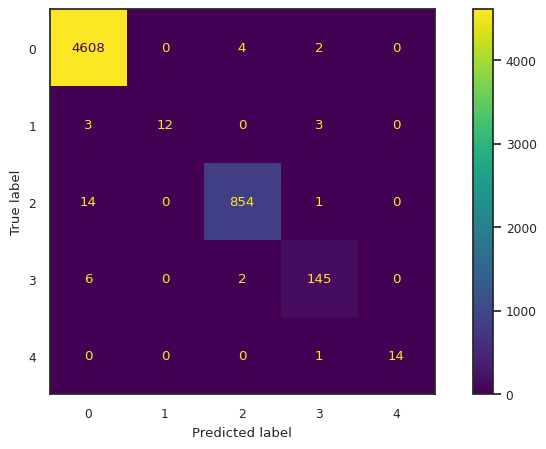

classification Error is : 0.63503263362145%
___________________________________________________________________________
Accuracy Random Forest 0.9984124184159464
Accuracy test:  0.9894242068155111
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00       869
           3       1.00      0.97      0.98       153
           4       1.00      1.00      1.00        15

    accuracy                           1.00      5669
   macro avg       1.00      0.97      0.98      5669
weighted avg       1.00      1.00      1.00      5669



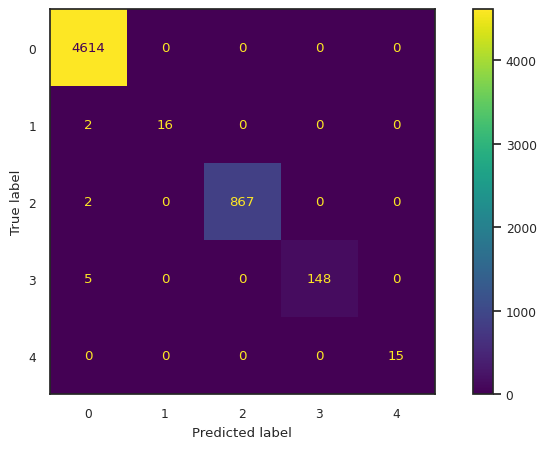

classification Error is : 0.1587581584053625%
___________________________________________________________________________
Accuracy Decision Tree 0.9985888163697301
Accuracy test:  0.9905992949471211
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4614
           1       0.94      0.94      0.94        18
           2       1.00      1.00      1.00       869
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00        15

    accuracy                           1.00      5669
   macro avg       0.99      0.99      0.99      5669
weighted avg       1.00      1.00      1.00      5669



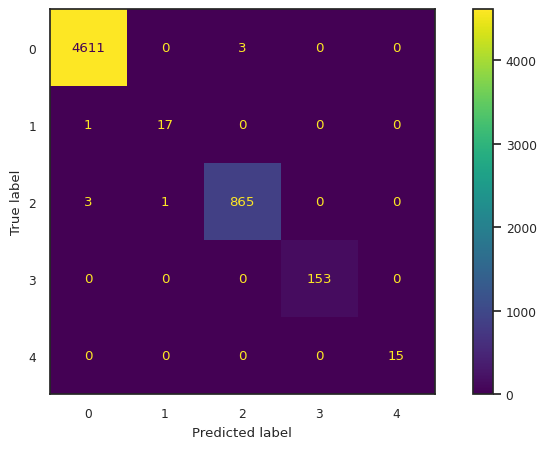

classification Error is : 0.14111836302698888%
___________________________________________________________________________
Accuracy KNearest 0.9714235314870348
Accuracy test:  0.9576968272620446
Accuracy train:  0.9738480697384807
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4614
           1       1.00      0.17      0.29        18
           2       0.98      0.91      0.95       869
           3       0.85      0.63      0.72       153
           4       0.92      0.80      0.86        15

    accuracy                           0.97      5669
   macro avg       0.95      0.70      0.76      5669
weighted avg       0.97      0.97      0.97      5669



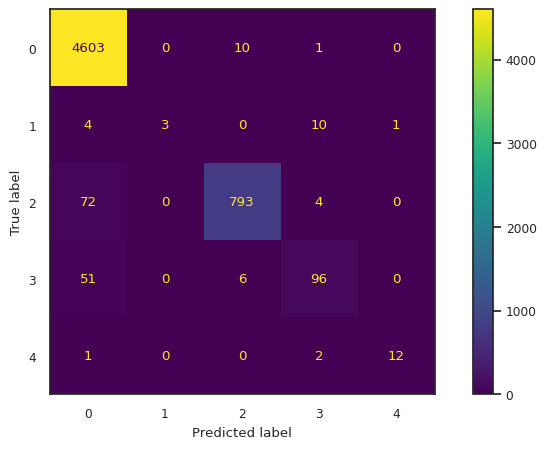

classification Error is : 2.857646851296525%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_RENN,y_RENN,B_method,ax[1][0])
# plot_decision_function(x_RENN, y_RENN, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on RENN Undersampled Data:")
mean_lr = cross_val_info(lr, x_RENN , y_RENN)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on RENN Undersampled Data:")
mean_rf = cross_val_info(rf, x_RENN , y_RENN)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on RENN Undersampled Data:")
mean_dt = cross_val_info(dt, x_RENN , y_RENN)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on RENN Undersampled Data:")
mean_kn = cross_val_info(kn, x_RENN , y_RENN)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on RENN Undersampled Data:
Cross-Validation Scores: [0.93121693 0.95149912 0.95149912 0.94973545 0.94439541]
Mean Accuracy: 0.9456692055397558
Standard Deviation: 0.0076811573533647395
Cross-Validation for Random Forest on RENN Undersampled Data:
Cross-Validation Scores: [0.96031746 0.98765432 0.99206349 0.9973545  0.99735216]
Mean Accuracy: 0.986948386624762
Standard Deviation: 0.013801409883592358
Cross-Validation for Decision Tree on RENN Undersampled Data:
Cross-Validation Scores: [0.96296296 0.99118166 0.98765432 0.9973545  0.9929391 ]
Mean Accuracy: 0.9864185077777309
Standard Deviation: 0.012136650303453355
Cross-Validation for K-Nearest Neighbors on RENN Undersampled Data:
Cross-Validation Scores: [0.9329806  0.94532628 0.95238095 0.94708995 0.92850838]
Mean Accuracy: 0.9412572325193684
Standard Deviation: 0.009003894809440813


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on RENN Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_RENN , y_RENN)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on RENN Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_RENN , y_RENN)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on RENN Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_RENN , y_RENN)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on RENN Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_RENN , y_RENN)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on RENN Undersampled Data:
Stratified Cross-Validation Scores: [0.95061728 0.95238095 0.94179894 0.95238095 0.94792586]
Mean Accuracy: 0.9490207982117367
Standard Deviation: 0.00396192219339171
Stratified Cross-Validation for Random Forest on RENN Undersampled Data:
Stratified Cross-Validation Scores: [0.99029982 0.99382716 0.99118166 0.98941799 0.9858782 ]
Mean Accuracy: 0.990120966172746
Standard Deviation: 0.0025841121792750804
Stratified Cross-Validation for Decision Tree on RENN Undersampled Data:
Stratified Cross-Validation Scores: [0.99029982 0.99118166 0.99382716 0.98853616 0.98411297]
Mean Accuracy: 0.9895915543164733
Standard Deviation: 0.0032279758208654434
Stratified Cross-Validation for K-Nearest Neighbors on RENN Undersampled Data:
Stratified Cross-Validation Scores: [0.94444444 0.94797178 0.93738977 0.94797178 0.94792586]
Mean Accuracy: 0.9451407276649995
Standard Deviation: 0.004107282275091073


7. AllKNN (Prototype Selection) (ii)

  This method will apply ENN several time and will vary the number of nearest neighbours. Supports multi-class resampling.

In [ ]:
B_method = under_sampling.AllKNN()
x_AKNN , y_AKNN = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_AKNN);newdf["Type_of_Anemia"]=y_AKNN
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9834867894315452
Accuracy test:  0.9793195463642428
Accuracy train:  0.9842223007182386
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7389
           1       0.88      0.73      0.80       221
           2       0.97      0.98      0.97      2186
           3       0.90      0.92      0.91       153
           4       0.86      0.58      0.69        43

    accuracy                           0.98      9992
   macro avg       0.92      0.84      0.87      9992
weighted avg       0.98      0.98      0.98      9992



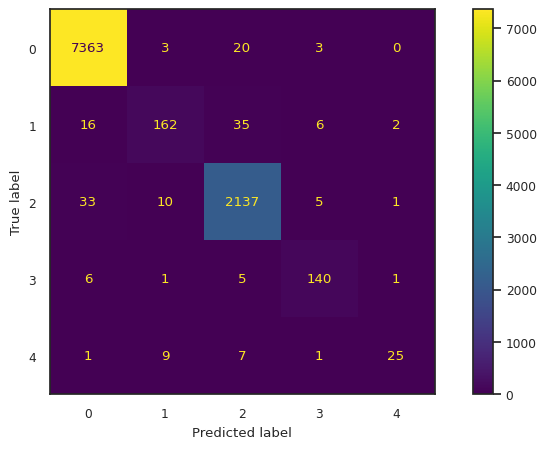

classification Error is : 1.6513210568454764%
___________________________________________________________________________
Accuracy Random Forest 0.9987990392313851
Accuracy test:  0.9919946631087392
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7389
           1       0.99      0.98      0.99       221
           2       1.00      1.00      1.00      2186
           3       1.00      0.98      0.99       153
           4       1.00      0.93      0.96        43

    accuracy                           1.00      9992
   macro avg       1.00      0.98      0.99      9992
weighted avg       1.00      1.00      1.00      9992



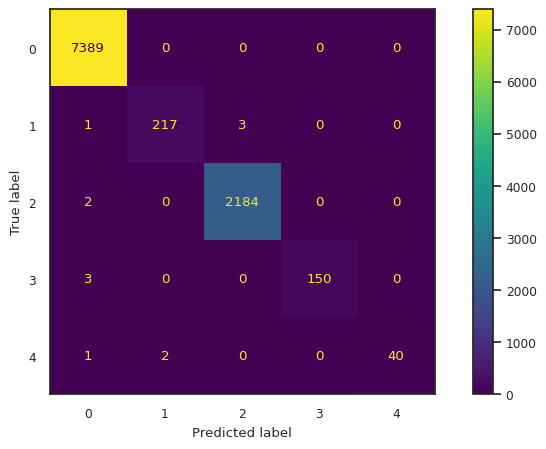

classification Error is : 0.12009607686148918%
___________________________________________________________________________
Accuracy Decision Tree 0.9998999199359487
Accuracy test:  0.9993328885923949
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7389
           1       1.00      1.00      1.00       221
           2       1.00      1.00      1.00      2186
           3       1.00      1.00      1.00       153
           4       1.00      0.98      0.99        43

    accuracy                           1.00      9992
   macro avg       1.00      1.00      1.00      9992
weighted avg       1.00      1.00      1.00      9992



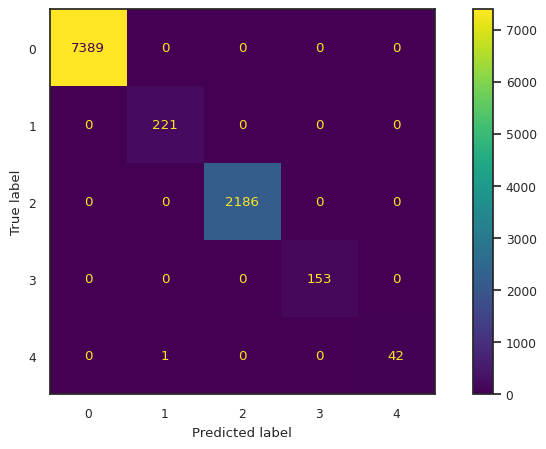

classification Error is : 0.010008006405124099%
___________________________________________________________________________
Accuracy KNearest 0.9370496397117695
Accuracy test:  0.914609739826551
Accuracy train:  0.9410102437301306
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7389
           1       0.70      0.39      0.50       221
           2       0.94      0.87      0.90      2186
           3       0.82      0.27      0.40       153
           4       0.86      0.42      0.56        43

    accuracy                           0.94      9992
   macro avg       0.85      0.59      0.67      9992
weighted avg       0.93      0.94      0.93      9992



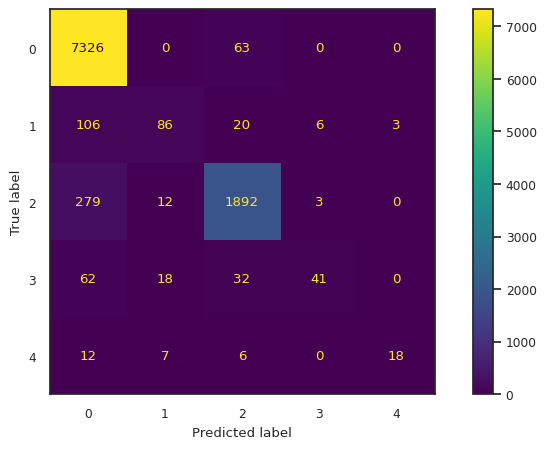

classification Error is : 6.295036028823059%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_AKNN,y_AKNN,B_method,ax[1][0])
# plot_decision_function(x_AKNN, y_AKNN, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on AllKNN Undersampled Data:")
mean_lr = cross_val_info(lr, x_AKNN , y_AKNN)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on AllKNN Undersampled Data:")
mean_rf = cross_val_info(rf, x_AKNN , y_AKNN)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on AllKNN Undersampled Data:")
mean_dt = cross_val_info(dt, x_AKNN , y_AKNN)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on AllKNN Undersampled Data:")
mean_kn = cross_val_info(kn, x_AKNN , y_AKNN)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on AllKNN Undersampled Data:
Cross-Validation Scores: [0.87393697 0.91095548 0.88038038 0.88088088 0.88188188]
Mean Accuracy: 0.885607117873251
Standard Deviation: 0.012978946172609697
Cross-Validation for Random Forest on AllKNN Undersampled Data:
Cross-Validation Scores: [0.92996498 0.98549275 0.99049049 0.99299299 0.99449449]
Mean Accuracy: 0.9786871413684821
Standard Deviation: 0.02455204219281047
Cross-Validation for Decision Tree on AllKNN Undersampled Data:
Cross-Validation Scores: [0.94947474 0.9989995  0.9984985  0.9994995  0.9994995 ]
Mean Accuracy: 0.9891943469232114
Standard Deviation: 0.01986327254455001
Cross-Validation for K-Nearest Neighbors on AllKNN Undersampled Data:
Cross-Validation Scores: [0.84092046 0.86293147 0.86536537 0.85885886 0.84884885]
Mean Accuracy: 0.8553849998072109
Standard Deviation: 0.009171354489714829


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on AllKNN Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_AKNN , y_AKNN)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on AllKNN Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_AKNN , y_AKNN)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on AllKNN Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_AKNN , y_AKNN)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on AllKNN Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_AKNN , y_AKNN)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on AllKNN Undersampled Data:
Stratified Cross-Validation Scores: [0.90295148 0.89794897 0.89139139 0.90690691 0.88788789]
Mean Accuracy: 0.8974173272822596
Standard Deviation: 0.0070439149322471225
Stratified Cross-Validation for Random Forest on AllKNN Undersampled Data:
Stratified Cross-Validation Scores: [0.989995   0.99049525 0.98898899 0.98348348 0.98698699]
Mean Accuracy: 0.9879899409164041
Standard Deviation: 0.002553780954866076
Stratified Cross-Validation for Decision Tree on AllKNN Undersampled Data:
Stratified Cross-Validation Scores: [0.9889945  0.991996   0.99049049 0.98098098 0.98748749]
Mean Accuracy: 0.9879898908413166
Standard Deviation: 0.003812829756444408
Stratified Cross-Validation for K-Nearest Neighbors on AllKNN Undersampled Data:
Stratified Cross-Validation Scores: [0.86593297 0.86043022 0.85685686 0.86336336 0.85335335]
Mean Accuracy: 0.8599873510328738
Standard Deviation: 0.004488960902611433


8. Tomek Links (Prototype Selection) (ii)

  Tomek Links is one of a modification from Condensed Nearest Neighbors (CNN, not to be confused with Convolutional Neural Network) undersampling technique that is developed by Tomek (1976). Unlike the CNN method that are only randomly select the samples with its k nearest neighbors from the majority class that wants to be removed.

In [ ]:
# for i in range(1000):
#     B_method = under_sampling.TomekLinks(n_jobs=-1)
#     x_TL , y_TL = B_method.fit_resample(X,Y)
#     X = x_TL;Y = y_TL
# newdf = pd.DataFrame(x_TL);newdf["Type_of_Anemia"]=y_TL
# newdf = newdf.reset_index(drop=True)

# shareplot(newdf,"Type_of_Anemia")

In [ ]:
# # info_func(newdf,"Type_of_Anemia",B_method)

# info_func_LR(newdf,"Type_of_Anemia",B_method)
# print('___________________________________________________________________________')
# info_func_RF(newdf,"Type_of_Anemia",B_method)
# print('___________________________________________________________________________')
# info_func_DT(newdf,"Type_of_Anemia",B_method)
# print('___________________________________________________________________________')
# info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# X = df.drop(columns="Type_of_Anemia")
# Y = df["Type_of_Anemia"]
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_TL,y_TL,B_method,ax[1][0])
# plot_decision_function(x_TL, y_TL, LogisticRegression(), ax[1][1])
# fig.tight_layout()

9. One-Sided Selection (Prototype Selection) (iii)

  One-Sided Selection, or OSS for short, is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule.
  Supports multi-class resampling.Specifically, Tomek Links are ambiguous points on the class boundary and are identified and removed in the majority class. The CNN method is then used to remove redundant examples from the majority class that are far from the decision boundary.

In [ ]:
B_method = under_sampling.OneSidedSelection(random_state=42,n_jobs=-1)
x_OSS , y_OSS = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_OSS);newdf["Type_of_Anemia"]=y_OSS
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9666803784450844
Accuracy test:  0.9654605263157895
Accuracy train:  0.9668957506533733
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7961
           1       0.84      0.70      0.76       618
           2       0.94      0.97      0.96      3307
           3       0.86      0.86      0.86       153
           4       0.77      0.52      0.62       116

    accuracy                           0.97     12155
   macro avg       0.88      0.81      0.84     12155
weighted avg       0.97      0.97      0.97     12155



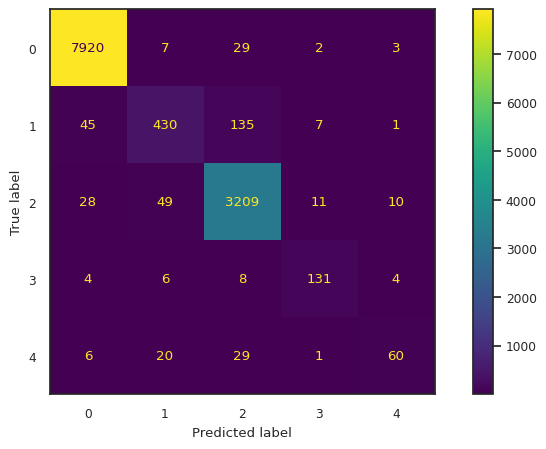

classification Error is : 3.331962155491567%
___________________________________________________________________________
Accuracy Random Forest 0.9982723159193747
Accuracy test:  0.9884868421052632
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       0.99      0.99      0.99       618
           2       1.00      1.00      1.00      3307
           3       1.00      0.97      0.99       153
           4       1.00      0.97      0.99       116

    accuracy                           1.00     12155
   macro avg       1.00      0.99      0.99     12155
weighted avg       1.00      1.00      1.00     12155



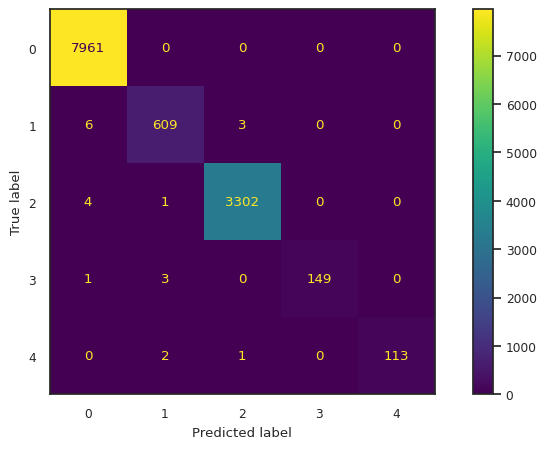

classification Error is : 0.17276840806252572%
___________________________________________________________________________
Accuracy Decision Tree 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7961
           1       1.00      1.00      1.00       618
           2       1.00      1.00      1.00      3307
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       116

    accuracy                           1.00     12155
   macro avg       1.00      1.00      1.00     12155
weighted avg       1.00      1.00      1.00     12155



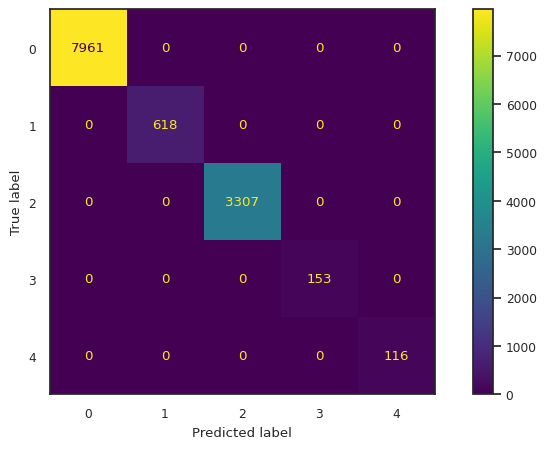

classification Error is : 0.0%
___________________________________________________________________________
Accuracy KNearest 0.9098313451254628
Accuracy test:  0.8848684210526315
Accuracy train:  0.9142386990610784
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7961
           1       0.70      0.48      0.57       618
           2       0.92      0.87      0.89      3307
           3       0.87      0.17      0.28       153
           4       0.85      0.19      0.31       116

    accuracy                           0.91     12155
   macro avg       0.85      0.54      0.60     12155
weighted avg       0.91      0.91      0.90     12155



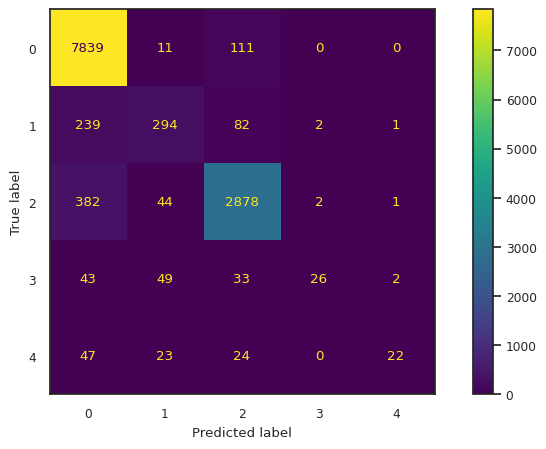

classification Error is : 9.016865487453723%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_OSS,y_OSS,B_method,ax[1][0])
# plot_decision_function(x_OSS, y_OSS, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on One-Sided Selection Undersampled Data:")
mean_lr = cross_val_info(lr, x_OSS , y_OSS)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on One-Sided Selection Undersampled Data:")
mean_rf = cross_val_info(rf, x_OSS , y_OSS)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on One-Sided Selection Undersampled Data:")
mean_dt = cross_val_info(dt, x_OSS , y_OSS)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on One-Sided Selection Undersampled Data:")
mean_kn = cross_val_info(kn, x_OSS , y_OSS)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on One-Sided Selection Undersampled Data:
Cross-Validation Scores: [0.82106129 0.86384204 0.85191279 0.83916084 0.83052242]
Mean Accuracy: 0.8412998765939943
Standard Deviation: 0.015173084991266338
Cross-Validation for Random Forest on One-Sided Selection Undersampled Data:
Cross-Validation Scores: [0.90703414 0.98272316 0.99218429 0.9938297  0.99629782]
Mean Accuracy: 0.974413821472645
Standard Deviation: 0.03400218048009169
Cross-Validation for Decision Tree on One-Sided Selection Undersampled Data:
Cross-Validation Scores: [0.99465241 0.99835459 0.99917729 1.         1.        ]
Mean Accuracy: 0.9984368572603867
Standard Deviation: 0.0019881605880040483
Cross-Validation for K-Nearest Neighbors on One-Sided Selection Undersampled Data:
Cross-Validation Scores: [0.74989716 0.75154258 0.77457836 0.76306047 0.7733443 ]
Mean Accuracy: 0.7624845742492801
Standard Deviation: 0.010418208880807366


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on One-Sided Selection Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_OSS , y_OSS)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on One-Sided Selection Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_OSS , y_OSS)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on One-Sided Selection Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_OSS , y_OSS)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on One-Sided Selection Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_OSS , y_OSS)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on One-Sided Selection Undersampled Data:
Stratified Cross-Validation Scores: [0.86137392 0.85109009 0.85561497 0.85767174 0.8527355 ]
Mean Accuracy: 0.855697243932538
Standard Deviation: 0.0036366986598602062
Stratified Cross-Validation for Random Forest on One-Sided Selection Undersampled Data:
Stratified Cross-Validation Scores: [0.99259564 0.99095023 0.98807075 0.98724805 0.99136158]
Mean Accuracy: 0.9900452488687783
Standard Deviation: 0.002038586868509082
Stratified Cross-Validation for Decision Tree on One-Sided Selection Undersampled Data:
Stratified Cross-Validation Scores: [0.99012752 0.98848211 0.99095023 0.9876594  0.98519128]
Mean Accuracy: 0.988482106129165
Standard Deviation: 0.0020152116353625593
Stratified Cross-Validation for K-Nearest Neighbors on One-Sided Selection Undersampled Data:
Stratified Cross-Validation Scores: [0.76758536 0.7725216  0.76388318 0.7663513  0.77005348]
Mean Accuracy: 0.7680789798436857
Stand

10. Neighbourhood Cleaning Rule (Prototype Selection) (iii)

  The Neighborhood Cleaning Rule, or NCR for short, is an undersampling technique that combines both the Condensed Nearest Neighbor (CNN) Rule to remove redundant examples and the Edited Nearest Neighbors (ENN) Rule to remove noisy or ambiguous examples.Like One-Sided Selection (OSS), the CSS method is applied in a one-step manner, then the examples that are misclassified according to a KNN classifier are removed, as per the ENN rule. Unlike OSS, less of the redundant examples are removed and more attention is placed on “cleaning” those examples that are retained.

In [ ]:
# for i in range(10000):
#     B_method = under_sampling.NeighbourhoodCleaningRule()
#     x_NCR , y_NCR = B_method.fit_resample(X,Y)
#     X = x_NCR;Y = y_NCR
# newdf = pd.DataFrame(x_NCR);newdf["Type_of_Anemia"]=y_NCR
# newdf = newdf.reset_index(drop=True)

# shareplot(newdf,"Type_of_Anemia")

In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

In [ ]:
# X = df.drop(columns="Type_of_Anemia")
# Y = df["Type_of_Anemia"]

# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_NCR,y_NCR,B_method,ax[1][0])
# plot_decision_function(x_NCR, y_NCR, LogisticRegression(), ax[1][1])
# fig.tight_layout()

11. Instance Hardness Threshold (Prototype Selection)
  
  Instance Hardness Threshold (IHT) is an undersampling method for alleviating class imbalance by removing hard samples. There is an implementation of IHT in imbalanced-learn library based on the article above-mentioned. Samples that are classified with a low probability will be removed from the dataset. Afterwards, the model will be built on the undersampled data.

In [ ]:
for i in range(30):
    B_method = under_sampling.InstanceHardnessThreshold(random_state=42,n_jobs=-1)
    x_IHT , y_IHT = B_method.fit_resample(X,Y)
    X = x_IHT;Y = y_IHT
newdf = pd.DataFrame(x_IHT);newdf["Type_of_Anemia"]=y_IHT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9905469277515192
Accuracy test:  0.9910313901345291
Accuracy train:  0.9904610492845787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       0.99      0.94      0.97       153
           2       1.00      1.00      1.00       153
           3       0.99      0.97      0.98       153
           4       0.93      0.99      0.96       153

    accuracy                           0.99      1481
   macro avg       0.98      0.98      0.98      1481
weighted avg       0.99      0.99      0.99      1481



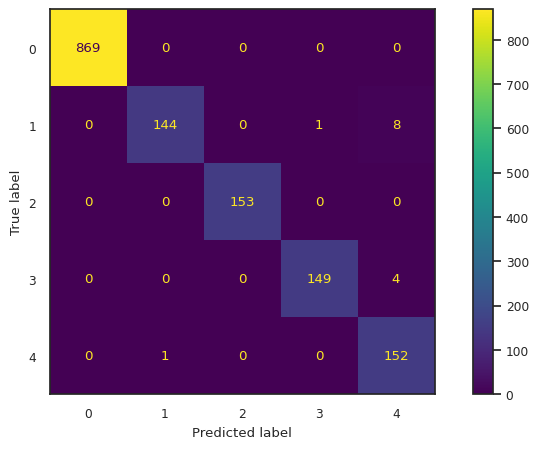

classification Error is : 0.9453072248480756%
___________________________________________________________________________
Accuracy Random Forest 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       1.00      1.00      1.00       153
           2       1.00      1.00      1.00       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00      1481
   macro avg       1.00      1.00      1.00      1481
weighted avg       1.00      1.00      1.00      1481



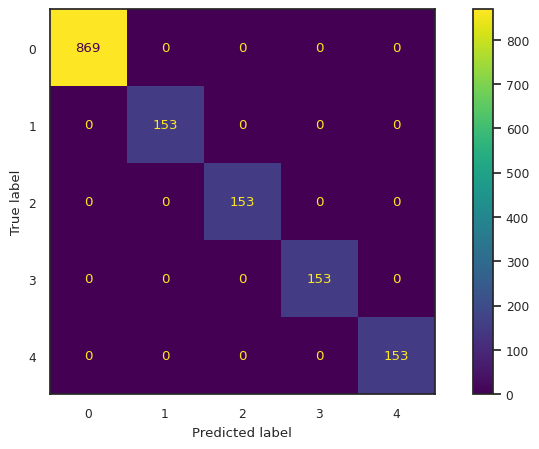

classification Error is : 0.0%
___________________________________________________________________________
Accuracy Decision Tree 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       869
           1       1.00      1.00      1.00       153
           2       1.00      1.00      1.00       153
           3       1.00      1.00      1.00       153
           4       1.00      1.00      1.00       153

    accuracy                           1.00      1481
   macro avg       1.00      1.00      1.00      1481
weighted avg       1.00      1.00      1.00      1481



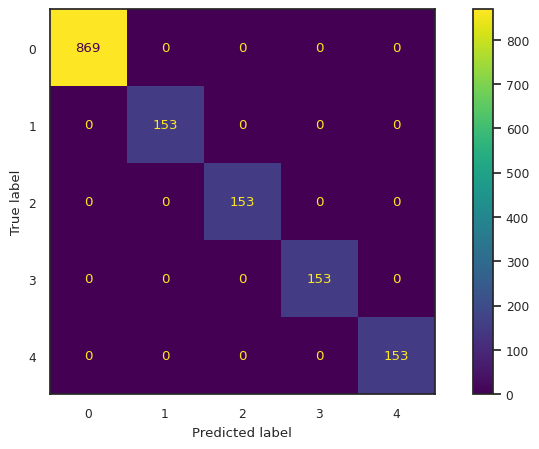

classification Error is : 0.0%
___________________________________________________________________________
Accuracy KNearest 0.9027683997299122
Accuracy test:  0.8654708520179372
Accuracy train:  0.9093799682034976
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       869
           1       0.70      0.84      0.76       153
           2       1.00      1.00      1.00       153
           3       0.79      0.68      0.73       153
           4       0.83      0.54      0.65       153

    accuracy                           0.90      1481
   macro avg       0.85      0.81      0.82      1481
weighted avg       0.90      0.90      0.90      1481



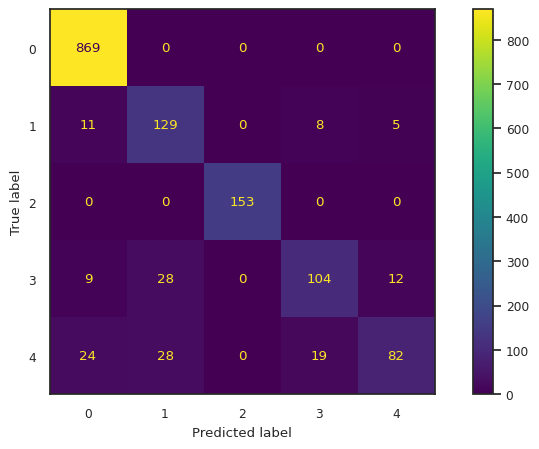

classification Error is : 9.723160027008777%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# X = df.drop(columns="Type_of_Anemia")
# Y = df["Type_of_Anemia"]

# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_IHT,y_IHT,B_method,ax[1][0])
# plot_decision_function(x_IHT, y_IHT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on IHT Undersampled Data:")
mean_lr = cross_val_info(lr, x_IHT , y_IHT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on IHT Undersampled Data:")
mean_rf = cross_val_info(rf, x_IHT , y_IHT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on IHT Undersampled Data:")
mean_dt = cross_val_info(dt, x_IHT , y_IHT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on IHT Undersampled Data:")
mean_kn = cross_val_info(kn, x_IHT , y_IHT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on IHT Undersampled Data:
Cross-Validation Scores: [0.94949495 0.91554054 0.91216216 0.89527027 0.90878378]
Mean Accuracy: 0.9162503412503412
Standard Deviation: 0.01799074129307825
Cross-Validation for Random Forest on IHT Undersampled Data:
Cross-Validation Scores: [0.996633 1.       1.       1.       1.      ]
Mean Accuracy: 0.9993265993265993
Standard Deviation: 0.0013468013468013404
Cross-Validation for Decision Tree on IHT Undersampled Data:
Cross-Validation Scores: [0.996633   0.99662162 1.         1.         1.        ]
Mean Accuracy: 0.9986509236509237
Standard Deviation: 0.0016522782551810517
Cross-Validation for K-Nearest Neighbors on IHT Undersampled Data:
Cross-Validation Scores: [0.88552189 0.86486486 0.8277027  0.81418919 0.84121622]
Mean Accuracy: 0.8466989716989716
Standard Deviation: 0.025632101414092816


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on IHT Undersampled Data:")
mean_lr = stratified_cross_val_info(lr_st, x_IHT , y_IHT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on IHT Undersampled Data:")
mean_rf = stratified_cross_val_info(rf_st, x_IHT , y_IHT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on IHT Undersampled Data:")
mean_dt = stratified_cross_val_info(rf_st, x_IHT , y_IHT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on IHT Undersampled Data:")
mean_kn = stratified_cross_val_info(kn_st, x_IHT , y_IHT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on IHT Undersampled Data:
Stratified Cross-Validation Scores: [0.91582492 0.91554054 0.93581081 0.9222973  0.93918919]
Mean Accuracy: 0.9257325507325508
Standard Deviation: 0.009964855364120206
Stratified Cross-Validation for Random Forest on IHT Undersampled Data:
Stratified Cross-Validation Scores: [1.         1.         0.99662162 1.         1.        ]
Mean Accuracy: 0.9993243243243242
Standard Deviation: 0.0013513513513513597
Stratified Cross-Validation for Decision Tree on IHT Undersampled Data:
Stratified Cross-Validation Scores: [1.         1.         0.99324324 1.         1.        ]
Mean Accuracy: 0.9986486486486486
Standard Deviation: 0.0027027027027027198
Stratified Cross-Validation for K-Nearest Neighbors on IHT Undersampled Data:
Stratified Cross-Validation Scores: [0.84175084 0.83445946 0.83783784 0.84797297 0.84459459]
Mean Accuracy: 0.8413231413231413
Standard Deviation: 0.004782532054148003


## Combination

1. SMOTE-Tomek

  This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class (that is, samples of data from the majority class that is closest with the minority class data).

In [ ]:
B_method = combine.SMOTETomek(random_state=42,n_jobs=-1)
x_SMT , y_SMT = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_SMT);newdf["Type_of_Anemia"]=y_SMT
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9923558026407228
Accuracy test:  0.9922839506172839
Accuracy train:  0.9923684927773235
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       858
           1       1.00      0.98      0.99       862
           2       1.00      1.00      1.00       869
           3       0.99      0.99      0.99       860
           4       0.97      0.99      0.98       868

    accuracy                           0.99      4317
   macro avg       0.99      0.99      0.99      4317
weighted avg       0.99      0.99      0.99      4317



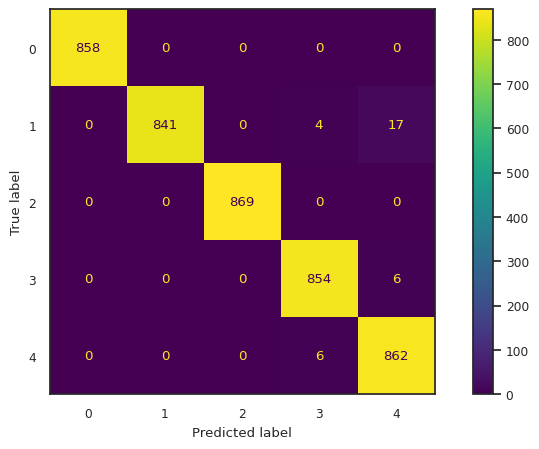

classification Error is : 0.7644197359277276%
___________________________________________________________________________
Accuracy Random Forest 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       858
           1       1.00      1.00      1.00       862
           2       1.00      1.00      1.00       869
           3       1.00      1.00      1.00       860
           4       1.00      1.00      1.00       868

    accuracy                           1.00      4317
   macro avg       1.00      1.00      1.00      4317
weighted avg       1.00      1.00      1.00      4317



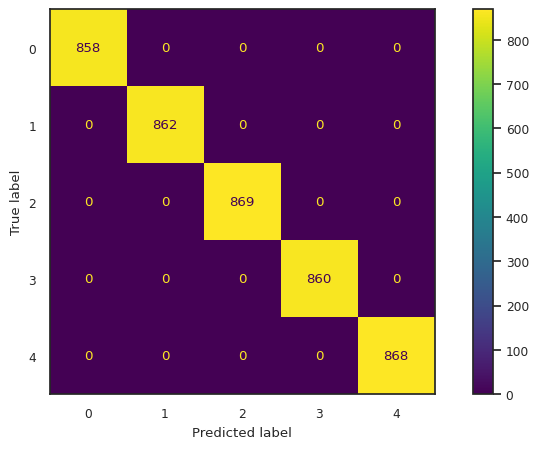

classification Error is : 0.0%
___________________________________________________________________________
Accuracy Decision Tree 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       858
           1       1.00      1.00      1.00       862
           2       1.00      1.00      1.00       869
           3       1.00      1.00      1.00       860
           4       1.00      1.00      1.00       868

    accuracy                           1.00      4317
   macro avg       1.00      1.00      1.00      4317
weighted avg       1.00      1.00      1.00      4317



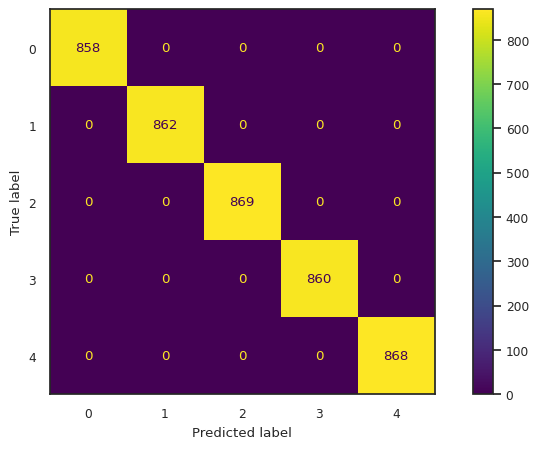

classification Error is : 0.0%
___________________________________________________________________________
Accuracy KNearest 0.9870280287236507
Accuracy test:  0.9737654320987654
Accuracy train:  0.9893704006541292
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       858
           1       0.98      0.97      0.98       862
           2       1.00      1.00      1.00       869
           3       0.98      0.98      0.98       860
           4       0.97      0.98      0.97       868

    accuracy                           0.99      4317
   macro avg       0.99      0.99      0.99      4317
weighted avg       0.99      0.99      0.99      4317



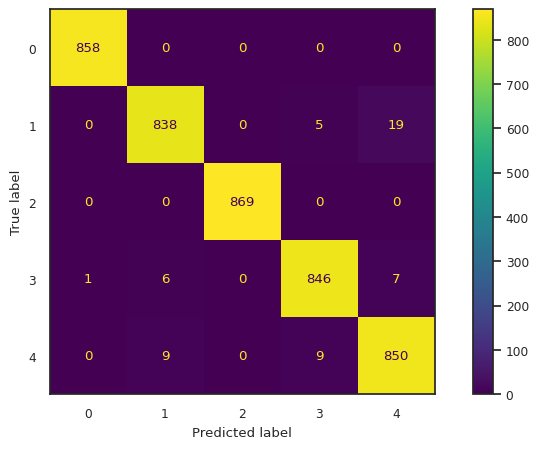

classification Error is : 1.2971971276349317%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_SMT,y_SMT,B_method,ax[1][0])
# plot_decision_function(x_SMT, y_SMT, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SMOTE-Tomek Combination Data:")
mean_lr = cross_val_info(lr, x_SMT , y_SMT)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SMOTE-Tomek Combination Data:")
mean_rf = cross_val_info(rf, x_SMT , y_SMT)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SMOTE-Tomek Combination Data:")
mean_dt = cross_val_info(dt, x_SMT , y_SMT)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SMOTE-Tomek Combination Data:")
mean_kn = cross_val_info(kn, x_SMT , y_SMT)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SMOTE-Tomek Combination Data:
Cross-Validation Scores: [0.87268519 0.92939815 0.92004635 0.91772885 0.90266512]
Mean Accuracy: 0.9085047315565855
Standard Deviation: 0.019859351304374558
Cross-Validation for Random Forest on SMOTE-Tomek Combination Data:
Cross-Validation Scores: [0.99537037 1.         1.         1.         1.        ]
Mean Accuracy: 0.999074074074074
Standard Deviation: 0.0018518518518518604
Cross-Validation for Decision Tree on SMOTE-Tomek Combination Data:
Cross-Validation Scores: [0.99537037 1.         1.         1.         1.        ]
Mean Accuracy: 0.999074074074074
Standard Deviation: 0.0018518518518518604
Cross-Validation for K-Nearest Neighbors on SMOTE-Tomek Combination Data:
Cross-Validation Scores: [0.92939815 0.94328704 0.94090382 0.93511008 0.94785632]
Mean Accuracy: 0.939311081069482
Standard Deviation: 0.006438644596875132


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SMOTE-Tomek Combination Data:")
mean_lr = stratified_cross_val_info(lr_st, x_SMT , y_SMT)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SMOTE-Tomek Combination Data:")
mean_rf = stratified_cross_val_info(rf_st, x_SMT , y_SMT)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SMOTE-Tomek Combination Data:")
mean_dt = stratified_cross_val_info(rf_st, x_SMT , y_SMT)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-Tomek Combination Data:")
mean_kn = stratified_cross_val_info(kn_st, x_SMT , y_SMT)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SMOTE-Tomek Combination Data:
Stratified Cross-Validation Scores: [0.92361111 0.90856481 0.91193511 0.91193511 0.9165701 ]
Mean Accuracy: 0.914523250075104
Standard Deviation: 0.005209197987869197
Stratified Cross-Validation for Random Forest on SMOTE-Tomek Combination Data:
Stratified Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0
Stratified Cross-Validation for Decision Tree on SMOTE-Tomek Combination Data:
Stratified Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0
Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-Tomek Combination Data:
Stratified Cross-Validation Scores: [0.94212963 0.93287037 0.95249131 0.94090382 0.93858633]
Mean Accuracy: 0.941396292004635
Standard Deviation: 0.00639479419489366


2. SMOTE-ENN

  This method combines the SMOTE ability to generate synthetic examples for minority class and ENN ability to delete some observations from both classes that are identified as having different class between the observation’s class and its K-nearest neighbor majority class.

In [ ]:
B_method = combine.SMOTEENN(random_state=42,n_jobs=-1)
x_SME , y_SME = B_method.fit_resample(X,Y)
newdf = pd.DataFrame(x_SME);newdf["Type_of_Anemia"]=y_SME
newdf = newdf.reset_index(drop=True)

shareplot(newdf,"Type_of_Anemia")

Accuracy Linear Regression 0.9918158567774936
Accuracy test:  0.989778534923339
Accuracy train:  0.9921757448089076
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      0.97      0.99       792
           2       1.00      1.00      1.00       866
           3       0.99      0.99      0.99       716
           4       0.97      0.99      0.98       852

    accuracy                           0.99      3910
   macro avg       0.99      0.99      0.99      3910
weighted avg       0.99      0.99      0.99      3910



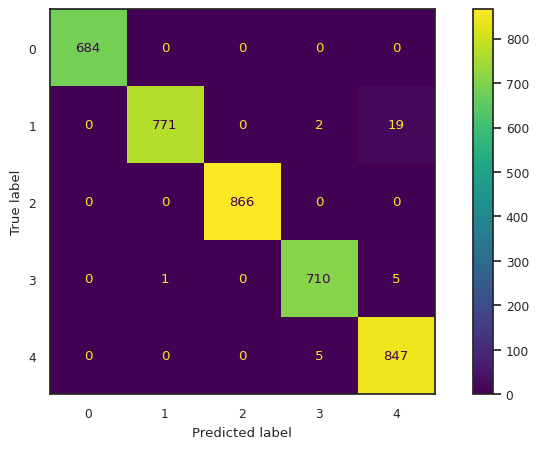

classification Error is : 0.8184143222506393%
___________________________________________________________________________
Accuracy Random Forest 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      1.00      1.00       792
           2       1.00      1.00      1.00       866
           3       1.00      1.00      1.00       716
           4       1.00      1.00      1.00       852

    accuracy                           1.00      3910
   macro avg       1.00      1.00      1.00      3910
weighted avg       1.00      1.00      1.00      3910



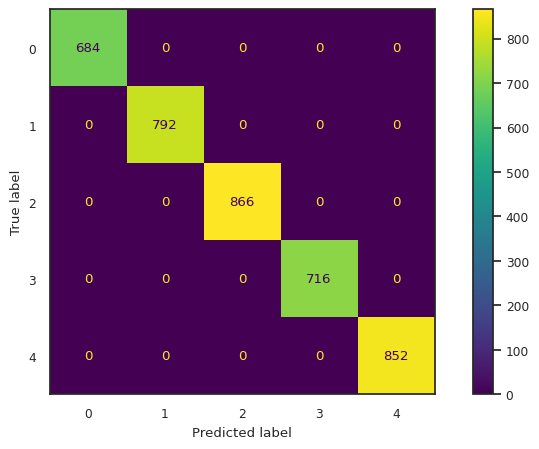

classification Error is : 0.0%
___________________________________________________________________________
Accuracy Decision Tree 1.0
Accuracy test:  1.0
Accuracy train:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       1.00      1.00      1.00       792
           2       1.00      1.00      1.00       866
           3       1.00      1.00      1.00       716
           4       1.00      1.00      1.00       852

    accuracy                           1.00      3910
   macro avg       1.00      1.00      1.00      3910
weighted avg       1.00      1.00      1.00      3910



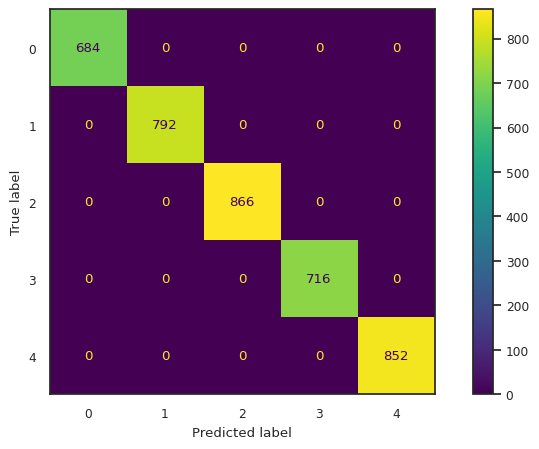

classification Error is : 0.0%
___________________________________________________________________________
Accuracy KNearest 0.9887468030690537
Accuracy test:  0.9744463373083475
Accuracy train:  0.9912729461330123
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       684
           1       0.98      0.99      0.98       792
           2       1.00      1.00      1.00       866
           3       0.99      0.98      0.98       716
           4       0.98      0.98      0.98       852

    accuracy                           0.99      3910
   macro avg       0.99      0.99      0.99      3910
weighted avg       0.99      0.99      0.99      3910



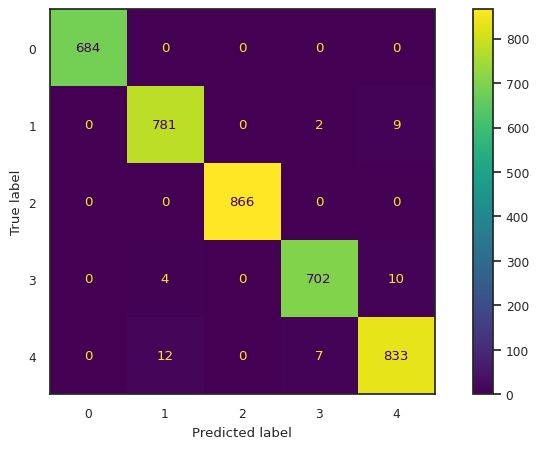

classification Error is : 1.1253196930946292%


In [ ]:
# info_func(newdf,"Type_of_Anemia",B_method)

info_func_LR(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_RF(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_DT(newdf,"Type_of_Anemia",B_method)
print('___________________________________________________________________________')
info_func_KN(newdf,"Type_of_Anemia",B_method)

In [ ]:
# fig, ax = plt.subplots(2,2,figsize=(15, 10))
# plot_resampling(X,Y,None,ax[0][0],title="Without resampling")
# plot_decision_function(X, Y, LogisticRegression(), ax[0][1])
# plot_resampling(x_SME,y_SME,B_method,ax[1][0])
# plot_decision_function(x_SME, y_SME, LogisticRegression(), ax[1][1])
# fig.tight_layout()

In [ ]:
# Cross-validation for Logistic Regression on oversampled data
print("Cross-Validation for Logistic Regression on SMOTE-ENN Combination Data:")
mean_lr = cross_val_info(lr, x_SME , y_SME)
Compare1["CV_accLR"].append(mean_lr)
Compare6["CV_accLR"].append(mean_lr)

# Cross-validation for Random Forest on oversampled data
print("Cross-Validation for Random Forest on SMOTE-ENN Combination Data:")
mean_rf = cross_val_info(rf, x_SME , y_SME)
Compare2["CV_accRF"].append(mean_rf)
Compare6["CV_accRF"].append(mean_rf)

# Cross-validation for Decision Tree on oversampled data
print("Cross-Validation for Decision Tree on SMOTE-ENN Combination Data:")
mean_dt = cross_val_info(dt, x_SME , y_SME)
Compare3["CV_accDT"].append(mean_dt)
Compare6["CV_accDT"].append(mean_dt)

# Cross-validation for K-Nearest Neighbors on oversampled data
print("Cross-Validation for K-Nearest Neighbors on SMOTE-ENN Combination Data:")
mean_kn = cross_val_info(kn, x_SME , y_SME)
Compare4["CV_accKN"].append(mean_kn)
Compare6["CV_accKN"].append(mean_kn)

Cross-Validation for Logistic Regression on SMOTE-ENN Combination Data:
Cross-Validation Scores: [0.89130435 0.91432225 0.93861893 0.91943734 0.93478261]
Mean Accuracy: 0.919693094629156
Standard Deviation: 0.016856528954766355
Cross-Validation for Random Forest on SMOTE-ENN Combination Data:
Cross-Validation Scores: [0.99488491 1.         1.         1.         1.        ]
Mean Accuracy: 0.9989769820971868
Standard Deviation: 0.002046035805626589
Cross-Validation for Decision Tree on SMOTE-ENN Combination Data:
Cross-Validation Scores: [0.99488491 1.         1.         1.         1.        ]
Mean Accuracy: 0.9989769820971868
Standard Deviation: 0.002046035805626589
Cross-Validation for K-Nearest Neighbors on SMOTE-ENN Combination Data:
Cross-Validation Scores: [0.96930946 0.98209719 0.9859335  0.96803069 0.9859335 ]
Mean Accuracy: 0.9782608695652174
Standard Deviation: 0.007965427878464186


In [ ]:
lr_st = LogisticRegression()
print("Stratified Cross-Validation for Logistic Regression on SMOTE-ENN Combination Data:")
mean_lr = stratified_cross_val_info(lr_st, x_SME , y_SME)
Compare1["STCV_accLR"].append(mean_lr)
Compare7["STCV_accLR"].append(mean_lr)

# Similar for other models
rf_st = RandomForestClassifier()
print("Stratified Cross-Validation for Random Forest on SMOTE-ENN Combination Data:")
mean_rf = stratified_cross_val_info(rf_st, x_SME , y_SME)
Compare2["STCV_accRF"].append(mean_rf)
Compare7["STCV_accRF"].append(mean_rf)

dt_st = DecisionTreeClassifier()
print("Stratified Cross-Validation for Decision Tree on SMOTE-ENN Combination Data:")
mean_dt = stratified_cross_val_info(rf_st, x_SME , y_SME)
Compare3["STCV_accDT"].append(mean_dt)
Compare7["STCV_accDT"].append(mean_dt)

kn_st = KNeighborsClassifier()
print("Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-ENN Combination Data:")
mean_kn = stratified_cross_val_info(kn_st, x_SME , y_SME)
Compare4["STCV_accKN"].append(mean_kn)
Compare7["STCV_accKN"].append(mean_kn)

Stratified Cross-Validation for Logistic Regression on SMOTE-ENN Combination Data:
Stratified Cross-Validation Scores: [0.93478261 0.90537084 0.9028133  0.92838875 0.93094629]
Mean Accuracy: 0.920460358056266
Standard Deviation: 0.013542917948719932
Stratified Cross-Validation for Random Forest on SMOTE-ENN Combination Data:
Stratified Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0
Stratified Cross-Validation for Decision Tree on SMOTE-ENN Combination Data:
Stratified Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0
Stratified Cross-Validation for K-Nearest Neighbors on SMOTE-ENN Combination Data:
Stratified Cross-Validation Scores: [0.97570332 0.98209719 0.97826087 0.96419437 0.96419437]
Mean Accuracy: 0.9728900255754475
Standard Deviation: 0.007385948377592644


In [ ]:
dfCompare1 = pd.DataFrame(Compare1)
dfCompare1

,Method,P_Count_LR,N_Count_LR,Score_P_LR,Score_N_LR,Score_accLR,CV_accLR,STCV_accLR
0,NoMethod,1019,9747,0.788035,0.992220,0.961961,0.806928,0.821765
1,RandomOverSampler,9747,9747,0.921982,0.982337,0.948046,0.712240,0.723258
2,ADASYN,9942,9747,0.942465,0.987386,0.963637,0.739446,0.756231
3,SMOTE,9747,9747,0.952004,0.985746,0.968872,0.747902,0.756417
4,BorderlineSMOTE,9747,9747,0.945834,0.986423,0.965877,0.736021,0.751801
5,SVMSMOTE,9747,9747,0.926776,0.946923,0.940866,0.716019,0.740762
6,KMeansSMOTE,9753,9747,0.954782,0.988058,0.971634,0.787740,0.802794
7,SMOTENC,9747,9747,0.924277,0.915942,0.938689,0.758900,0.736309
8,SMOTEN,9747,9747,0.966416,0.983657,0.977121,0.744721,0.767888
9,ClusterCentroids,153,153,0.856140,0.993421,0.930719,0.654902,0.657516


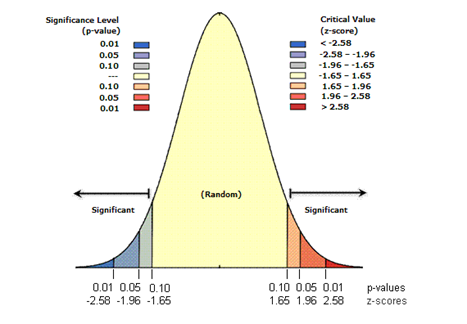

In Logistic Regression, we got:

F-statistic value = 0.10529

P-value = 0.74718

statistically speaking, there is no significant result between 5-fold cross validation and stratified cross validation

In [ ]:
dfCompare2 = pd.DataFrame(Compare2)
dfCompare2

,Method,P_Count_RF,N_Count_RF,Score_P_RF,Score_N_RF,Score_accRF,CV_accRF,STCV_accRF
0,NoMethod,1019,9747,0.992658,0.999436,0.998562,0.975817,0.991569
1,RandomOverSampler,9747,9747,0.999949,0.999897,0.999959,0.998379,0.998974
2,ADASYN,9942,9747,0.999648,0.999846,0.999819,0.997025,0.998131
3,SMOTE,9747,9747,0.999846,0.999795,0.999918,0.996840,0.998194
4,BorderlineSMOTE,9747,9747,0.999641,0.999795,0.999774,0.997025,0.998030
5,SVMSMOTE,9747,9747,0.999436,0.998359,0.999123,0.990695,0.994448
6,KMeansSMOTE,9753,9747,0.999846,0.999590,0.999815,0.988166,0.998605
7,SMOTENC,9747,9747,0.998208,0.995789,0.998297,0.982949,0.987258
8,SMOTEN,9747,9747,0.999590,0.999385,0.999651,0.972833,0.996696
9,ClusterCentroids,153,153,0.990228,0.990099,0.993464,0.985621,0.988235


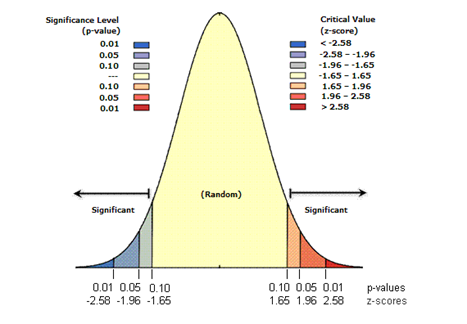

In Random Forest, we got:

F-statistic value = 1.16083

P-value = 0.28744

statistically speaking, there is no significant result between 5-fold cross validation and stratified cross validation

In [ ]:
dfCompare3 = pd.DataFrame(Compare3)
dfCompare3

,Method,P_Count_DT,N_Count_DT,Score_P_DT,Score_N_DT,Score_accDT,CV_accDT,STCV_accDT
0,NoMethod,1019,9747,0.999509,1.000000,0.999935,0.999477,0.990458
1,RandomOverSampler,9747,9747,1.000000,1.000000,1.000000,0.999672,0.998830
2,ADASYN,9942,9747,0.999648,1.000000,0.999859,0.997528,0.998231
3,SMOTE,9747,9747,0.999897,1.000000,0.999918,0.997599,0.998420
4,BorderlineSMOTE,9747,9747,0.999795,1.000000,0.999897,0.996573,0.998194
5,SVMSMOTE,9747,9747,0.999590,0.998153,0.999034,0.991369,0.994314
6,KMeansSMOTE,9753,9747,0.999897,0.999744,0.999836,0.989500,0.998339
7,SMOTENC,9747,9747,0.997795,0.994917,0.997907,0.981040,0.987381
8,SMOTEN,9747,9747,0.999897,0.999641,0.999774,0.980733,0.996758
9,ClusterCentroids,153,153,0.996743,0.990099,0.996078,0.981699,0.988235


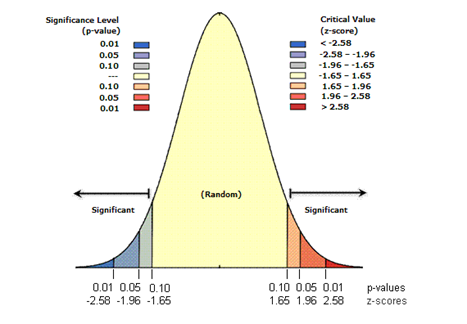

In Decision Tree, we got:

F-statistic value = 0.09123

P-value = 0.76411

statistically speaking, there is no significant result between 5-fold cross validation and stratified cross validation

In [ ]:
dfCompare4 = pd.DataFrame(Compare4)
dfCompare4

,Method,P_Count_KN,N_Count_KN,Score_P_KN,Score_N_KN,Score_accKN,CV_accKN,STCV_accKN
0,NoMethod,1019,9747,0.603104,0.942654,0.896536,0.686209,0.692026
1,RandomOverSampler,9747,9747,0.962706,0.933305,0.964563,0.865148,0.865784
2,ADASYN,9942,9747,0.960431,0.938809,0.964300,0.811088,0.861984
3,SMOTE,9747,9747,0.955773,0.938758,0.960932,0.859505,0.860778
4,BorderlineSMOTE,9747,9747,0.957191,0.939729,0.963066,0.872166,0.874833
5,SVMSMOTE,9747,9747,0.955091,0.932611,0.954688,0.861347,0.867234
6,KMeansSMOTE,9753,9747,0.952281,0.936447,0.961051,0.851180,0.882517
7,SMOTENC,9747,9747,0.936804,0.932823,0.949810,0.861927,0.862152
8,SMOTEN,9747,9747,0.959140,0.926401,0.960932,0.882938,0.899661
9,ClusterCentroids,153,153,0.766082,0.974194,0.835294,0.328105,0.324183


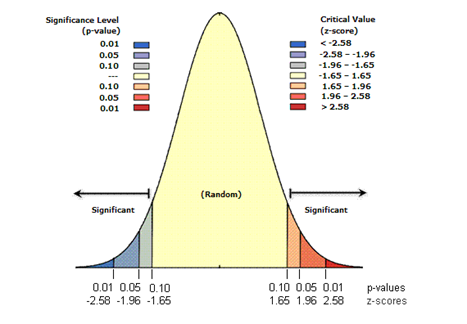

In KNN, we got:

F-statistic value = 0.03158

P-value = 0.8598

statistically speaking, there is no significant result between 5-fold cross validation and stratified cross validation

In [ ]:
dfCompare5 = pd.DataFrame(Compare5)
dfCompare5

,Method,Score_accLR,Score_accRF,Score_accDT,Score_accKN
0,NoMethod,0.961961,0.998562,0.999935,0.896536
1,RandomOverSampler,0.948046,0.999959,1.000000,0.964563
2,ADASYN,0.963637,0.999819,0.999859,0.964300
3,SMOTE,0.968872,0.999918,0.999918,0.960932
4,BorderlineSMOTE,0.965877,0.999774,0.999897,0.963066
5,SVMSMOTE,0.940866,0.999123,0.999034,0.954688
6,KMeansSMOTE,0.971634,0.999815,0.999836,0.961051
7,SMOTENC,0.938689,0.998297,0.997907,0.949810
8,SMOTEN,0.977121,0.999651,0.999774,0.960932
9,ClusterCentroids,0.930719,0.993464,0.996078,0.835294


In [ ]:
dfCompare6 = pd.DataFrame(Compare6)
dfCompare6

,Method,CV_accLR,CV_accRF,CV_accDT,CV_accKN
0,NoMethod,0.806928,0.975817,0.999477,0.686209
1,RandomOverSampler,0.712240,0.998379,0.999672,0.865148
2,ADASYN,0.739446,0.997025,0.997528,0.811088
3,SMOTE,0.747902,0.996840,0.997599,0.859505
4,BorderlineSMOTE,0.736021,0.997025,0.996573,0.872166
5,SVMSMOTE,0.716019,0.990695,0.991369,0.861347
6,KMeansSMOTE,0.787740,0.988166,0.989500,0.851180
7,SMOTENC,0.758900,0.982949,0.981040,0.861927
8,SMOTEN,0.744721,0.972833,0.980733,0.882938
9,ClusterCentroids,0.654902,0.985621,0.981699,0.328105


In [ ]:
dfCompare7 = pd.DataFrame(Compare7)
dfCompare7

,Method,STCV_accLR,STCV_accRF,STCV_accDT,STCV_accKN
0,NoMethod,0.821765,0.991569,0.990458,0.692026
1,RandomOverSampler,0.723258,0.998974,0.998830,0.865784
2,ADASYN,0.756231,0.998131,0.998231,0.861984
3,SMOTE,0.756417,0.998194,0.998420,0.860778
4,BorderlineSMOTE,0.751801,0.998030,0.998194,0.874833
5,SVMSMOTE,0.740762,0.994448,0.994314,0.867234
6,KMeansSMOTE,0.802794,0.998605,0.998339,0.882517
7,SMOTENC,0.736309,0.987258,0.987381,0.862152
8,SMOTEN,0.767888,0.996696,0.996758,0.899661
9,ClusterCentroids,0.657516,0.988235,0.988235,0.324183
